# Assignment 2
The objective of this assignment is to introduce you to function specific neural networks. In otherwords, we will try and design neural networks based on insights from existing optimization algorithms. In the process, you will realize that while deep neural networks can, in theory, be generalized to learn arbitrary functions, design choices determine how easily and quickly they are able to learn those functions.

Additionally, when the training process starts, the model has to learn a particular mapping with no prior hint about the kind of function it is looking for. By introducing a structure which correlates to optimization objectives, neural networks can effectively be helped in narrowing done the choice of functions and parameters to be learnt.

### Imports

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import torch
import pickle
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
# from google.colab import drive

np.random.seed(0)
gen = torch.Generator().manual_seed(0)

# Task 1: Sparsity and Robustness

Please add your solution to this task from the manual in the cells below.



```
# This is formatted as code
```

# Task 2: Sparsity in Contrastive Models

Please add your solution to this task from the manual in the cells below.

### Setting Up SigLIP for Zero Shot Classifcation

In [ ]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

candidate_labels = ["2 dogs", "2 cats", "2 pandas"]
candidate_labels = [f'This is a photo of {label}.' for label in candidate_labels]
# important: we pass `padding=max_length` since the model was trained with this
inputs = processor(text=candidate_labels, images=image, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

logits_per_image = outputs.logits_per_image
probs = torch.softmax(logits_per_image, dim=1) # Probs[x] indicates image, Probs[0][x] indicates the corresponding label probabilities
label_index = probs[0].argmax()
print(f"Probability: {probs[0][label_index]}, Class: {candidate_labels[label_index]}")

/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Probability: 0.9997759461402893, Class: This is a photo of 2 cats.


### Loading CIFAR-10 Dataset

In [11]:
!pip install datasets

In [12]:
from datasets import load_dataset

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
labels = [f'This is a photo of {label}' for label in labels]
# Load CIFAR-10 dataset
dataset = load_dataset('cifar10')

test_dataset = dataset['test']
print(test_dataset['label'])

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6, 0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3, 6, 2, 1, 2, 3, 7, 2, 6, 8, 8, 0, 2, 9, 3, 3, 8, 8, 1, 1, 7, 2, 5, 2, 7, 8, 9, 0, 3, 8, 6, 4, 6, 6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 6, 2, 1, 3, 0, 4, 2, 7, 8, 3, 1, 2, 8, 0, 8, 3, 5, 2, 4, 1, 8, 9, 1, 2, 9, 7, 2, 9, 6, 5, 6, 3, 8, 7, 6, 2, 5, 2, 8, 9, 6, 0, 0, 5, 2, 9, 5, 4, 2, 1, 6, 6, 8, 4, 8, 4, 5, 0, 9, 9, 9, 8, 9, 9, 3, 7, 5, 0, 0, 5, 2, 2, 3, 8, 6, 3, 4, 0, 5, 8, 0, 1, 7, 2, 8, 8, 7, 8, 5, 1, 8, 7, 1, 3, 0, 5, 7, 9, 7, 4, 5, 9, 8, 0, 7, 9, 8, 2, 7, 6, 9, 4, 3, 9, 6, 4, 7, 6, 5, 1, 5, 8, 8, 0, 4, 0, 5, 5, 1, 1, 8, 9, 0, 3, 1, 9, 2, 2, 5, 3, 9, 9, 4, 0, 3, 0, 0, 9, 8, 1, 5, 7, 0, 8, 2, 4, 7, 0, 2, 3, 6, 3, 8, 5, 0, 3, 4, 3, 9, 0, 6, 1, 0, 9, 1, 0, 7, 9, 1, 2, 6, 9, 3, 4, 6, 0, 0, 6, 6, 6, 3, 2, 6, 1, 8, 2, 1, 6, 8, 6, 8, 0, 4, 0, 7, 7, 5, 5, 3, 5, 2, 3, 4, 1, 7, 5, 4, 6, 1, 9, 3, 

### Evaluating CIFAR-10 with a Dense Latent Z

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

def evaluate_model(model, processor, labels, dataset, device, batch_size):
    model.to(device)  # Set model to evaluation mode
    all_preds = []
    all_labels = dataset['label']

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            # Batch Size is now 250

            inputs = processor(text=labels, images=dataset['img'][i:i+batch_size], padding="max_length", return_tensors="pt")
            inputs = inputs.to(device)

            with torch.no_grad():
                outputs = model(**inputs)

            logits_per_image = outputs.logits_per_image
            probs = torch.softmax(logits_per_image, dim=1) # Probs[x] indicates image, Probs[0][x] indicates the corresponding label probabilities
            preds = [prob.argmax().cpu().item() for prob in probs] #Prediction Labels

            print(f"Processed image {i} to {i+batch_size}")

            # Store predictions and actual labels
            all_preds.extend(preds)

    # Concatenate all predictions and labels

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return accuracy, precision, recall, f1

### DO NOT RUN THIS (Standard Accuracy of SigLIP on CIFAR-10)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy, precision, recall, f1 = evaluate_model(model=model, processor=processor, labels=labels, dataset=test_dataset, device=device, batch_size=500)

Processed image 0 to 500
Processed image 500 to 1000
Processed image 1000 to 1500
Processed image 1500 to 2000
Processed image 2000 to 2500
Processed image 2500 to 3000
Processed image 3000 to 3500
Processed image 3500 to 4000
Processed image 4000 to 4500
Processed image 4500 to 5000
Processed image 5000 to 5500
Processed image 5500 to 6000
Processed image 6000 to 6500
Processed image 6500 to 7000
Processed image 7000 to 7500
Processed image 7500 to 8000
Processed image 8000 to 8500
Processed image 8500 to 9000
Processed image 9000 to 9500
Processed image 9500 to 10000
Accuracy: 0.9179
Precision: 0.9230
Recall: 0.9179
F1 Score: 0.9181


### Creating Sparse Text Embeddings

We first extract the text encoder of siglip using the SiglipTokenizer

In [ ]:
from transformers import AutoTokenizer, SiglipTextModel, SiglipImageProcessor
import torch

# Load the tokenizer and model
image_processor = SiglipImageProcessor.from_pretrained('google/siglip-base-patch16-224')
tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")
text_model = SiglipTextModel.from_pretrained('google/siglip-base-patch16-224')

Next, we test the tokenizer to create sample embeddings.

In [ ]:
import numpy as np

text = "2 cats"

tokens = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    output = text_model(**tokens)


print(output.last_hidden_state)
print(output.last_hidden_state.shape)

tensor([[[-0.3132, -0.8568,  0.8199,  ...,  0.1410, -1.1800, -1.1009],
         [-0.1895, -0.5210,  0.6253,  ...,  0.1142, -1.4146, -0.9900],
         [-0.4563, -0.7785,  0.9965,  ...,  0.0295, -1.4883, -0.9871]]])
torch.Size([1, 3, 768])


### Generating Matrix A
First we extract the most frequent single token words from Flicker-30k

In [13]:
from datasets import load_dataset
ds = load_dataset("Tverous/flicker30k")

premises = ''.join(ds["test"]['premise'])


README.md:   0%|          | 0.00/671 [00:00<?, ?B/s]

(…)-00000-of-00001-8d1da3b9faa402f5.parquet:   0%|          | 0.00/49.8M [00:00<?, ?B/s]

(…)-00000-of-00001-2d6959bc15fc8e82.parquet:   0%|          | 0.00/1.79M [00:00<?, ?B/s]

(…)-00000-of-00001-0fe4bee3037158ab.parquet:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/401717 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/14740 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/14339 [00:00<?, ? examples/s]

We will take out the 1000 most frequently occuring words out of the Flicker-30k dataset. We will also through manual inspection remove redundant words like 'the', 'of' etc that do not contain a concept within them. These 1000 words (c = 1000) will be used to generate the A matrix that we will use to induce sparsity

In [14]:
import re
def word_frequency(text):
    # Split the string into words using spaces
    pattern = r'[ ,.]'

    words = re.split(pattern, text)

    # Remove any empty strings that might result from consecutive delimiters
    words = [item for item in words if item]
    # Initialize an empty dictionary to hold the word frequencies
    frequency = {}

    # Count the frequency of each word
    for word in words:
        # Convert to lowercase to ensure case-insensitivity
        word = word.lower()
        if word in frequency:
            frequency[word] += 1
        else:
            frequency[word] = 1

    return frequency


# These were removed through manual inspection
# nonconcepts = [
#     "a",
#     "in",
#     "the",
#     "and",
#     "is",
#     "on",
#     "with",
#     "an",
#     "to",
#     "at",
#     "are",
#     "while",
#     "his",
#     "her",
#     "by",
#     "as",
#     "for",
#     "from",
#     "up",
#     "their",
#     "that",
#     "who",
#     "being",
#     "across",
#     "into",
#     "along",
#     "behind",
#     "over",
#     "through",
#     "near",
#     "inside",
#     "outside",
#     "another",
#     "some",
#     "other",
#     "against",
#     "under",
#     "each",
#     "top",
#     "during",
#     "its",
#     "of",
# ]

frequencies = word_frequency(premises)

t1000 = sorted(
    (item for item in frequencies.items()),
    key=lambda item: item[1],
    reverse=True
)[:10000]

print(t1000)

[('a', 26488), ('in', 8429), ('the', 6388), ('and', 4730), ('on', 4149), ('is', 4114), ('man', 3988), ('of', 3842), ('with', 3625), ('woman', 2428), ('wearing', 1810), ('two', 1765), ('to', 1709), ('at', 1688), ('are', 1584), ('an', 1574), ('shirt', 1493), ('while', 1383), ('white', 1339), ('people', 1331), ('young', 1260), ('black', 1243), ('blue', 1190), ('boy', 1158), ('red', 1150), ('girl', 1150), ('his', 1015), ('playing', 861), ('standing', 838), ('her', 830), ('front', 824), ('sitting', 819), ('street', 810), ('dog', 790), ('men', 783), ('down', 780), ('holding', 742), ('one', 726), ('green', 657), ('walking', 649), ('group', 614), ('little', 606), ('by', 597), ('yellow', 553), ('as', 542), ('hat', 517), ('for', 501), ('water', 493), ('large', 491), ('other', 481), ('looking', 478), ('women', 463), ('next', 445), ('children', 441), ('up', 441), ('brown', 440), ('outside', 439), ('another', 427), ('from', 424), ('three', 421), ('ball', 402), ('child', 389), ('into', 387), ('perso

Now we will generate and store embeddings for all of these 1000 classes, essentially constructing our matrix A:

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
words = [item[0] for item in t1000 ]

matrixA = []

text_model.to(device)

for word in words:

    tokens = tokenizer(word, padding=True, truncation=True, return_tensors='pt')
    tokens = tokens.to(device)

    with torch.no_grad():
        output = text_model(**tokens)

    embeddings = output.last_hidden_state.squeeze()

    for token_emb in embeddings:
        matrixA.append(token_emb)
    print(f"{word} -> embeddings generated")


NameError: name 'text_model' is not defined

In [ ]:
matrixA = torch.stack(matrixA)
print(matrixA.shape)


torch.Size([2175, 768])


## Aligning the Embeddings

Aligning, Centering the text embeddings:

The value of d is 2175, initially we had 1000 words, which made 2175 tokens
We first calculate the mean value across each embedding, then, subtract it from that embedding. Then we calculate the norm and divide by the norm to normalize

In [ ]:
print(matrixA)

# mean_vector = matrixA.mean(dim = 1, keepdim=True)
# A_centered = matrixA - mean_vector

mean_scalar = matrixA.mean()  # Calculate the mean of the whole matrix
A_centered = matrixA - mean_scalar  # Subtract the scalar mean from every element

norms = A_centered.norm(p=2, dim=1, keepdim=True)
A_normalized = A_centered / norms

print(A_normalized)

tensor([[-1.0898, -0.8802, -0.0036,  ...,  0.2338, -0.0448, -0.8338],
        [-0.4590, -0.5398, -0.0463,  ...,  0.1554, -0.1710, -0.3796],
        [-1.1377, -2.2184,  0.2240,  ...,  0.1480, -0.9517, -0.5463],
        ...,
        [-0.7201, -1.3746,  0.1089,  ...,  0.6567, -0.5178, -0.3963],
        [-1.3079, -1.5525, -0.9879,  ..., -0.4102, -1.4321, -0.0669],
        [-1.4634, -1.8958, -1.1545,  ..., -0.6742, -1.5127, -0.3275]],
       device='cuda:0')
tensor([[-0.0511, -0.0401,  0.0056,  ...,  0.0179,  0.0034, -0.0377],
        [-0.0206, -0.0253,  0.0038,  ...,  0.0157, -0.0036, -0.0159],
        [-0.0445, -0.0912,  0.0145,  ...,  0.0112, -0.0364, -0.0189],
        ...,
        [-0.0284, -0.0589,  0.0102,  ...,  0.0357, -0.0190, -0.0133],
        [-0.0537, -0.0646, -0.0393,  ..., -0.0134, -0.0592,  0.0019],
        [-0.0555, -0.0733, -0.0429,  ..., -0.0231, -0.0576, -0.0089]],
       device='cuda:0')


Normalizing sample image embeddings


In [ ]:
def center_image(img):
    img = img.squeeze()
    mean_vector = img.mean(dim = 1, keepdim=True)
    img_centered = img - mean_vector
    norms = img_centered.norm(p=2, dim=1, keepdim=True)
    img_normalized = img_centered / norms

    return img_normalized

from transformers import SiglipVisionModel

vision_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224")
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")


url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)


inputs = processor(images=image, return_tensors="pt")
outputs = vision_model(**inputs)


z = outputs.last_hidden_state
zc = center_image(z)

print(z)
print(zc)


tensor([[[ 1.5043,  1.0727, -1.0006,  ...,  0.1915,  0.4427,  0.1436],
         [ 2.9307,  1.5942, -3.0625,  ..., -1.9061,  1.2034, -1.3176],
         [-2.6649, -1.4071,  1.2768,  ...,  2.6287, -0.1845,  1.8088],
         ...,
         [-0.3709,  0.9243, -0.3417,  ..., -1.2403,  2.2878, -1.8902],
         [ 1.5686,  1.5671, -0.7977,  ..., -1.1208, -1.8426, -0.2380],
         [ 2.0946,  0.4167, -1.0450,  ..., -2.1405, -1.1457, -0.9372]]],
       grad_fn=<NativeLayerNormBackward0>)
tensor([[ 0.0226,  0.0163, -0.0140,  ...,  0.0034,  0.0071,  0.0027],
        [ 0.0477,  0.0262, -0.0488,  ..., -0.0302,  0.0199, -0.0207],
        [-0.0400, -0.0209,  0.0199,  ...,  0.0404, -0.0023,  0.0280],
        ...,
        [-0.0064,  0.0164, -0.0059,  ..., -0.0218,  0.0404, -0.0332],
        [ 0.0248,  0.0247, -0.0120,  ..., -0.0170, -0.0282, -0.0033],
        [ 0.0319,  0.0067, -0.0152,  ..., -0.0317, -0.0167, -0.0136]],
       grad_fn=<DivBackward0>)


## Solving the Optimization Problem

The optimization problem can be modelled as a Lasso Regression Problem. We will use sklearns lasso class to solve this optimization problem. For each image in the CIFAR10 Dataset. We will induce varying degrees of sparsity by controlling the 'alpha' or (lambda) constant against the regularization expression. Larger value would mean that we give more significance to sparsity. We will use multiple values.



Alpha Values for MOST to LEAST Sparse w matrix
1.5e^-4 \\
1e^-4 \\
9e^-5 \\
5e^-5 \\
3e^-5 \\

In [ ]:
from sklearn.linear_model import Lasso
# Assuming A_c is your input matrix and z_c is your target vector
# and lambda_ is your regularization parameter lambda

print(zc.shape)
print(A_normalized.shape)

torch.Size([196, 768])
torch.Size([2175, 768])


## Sending all of these to CPU to process with scikit

In [ ]:
zc = zc.cpu()
A_normalized = A_normalized.cpu()
zc = zc.detach().numpy()
A_normalized = A_normalized.numpy()

In [ ]:
A_normalized = A_normalized.transpose(1, 0)
zc = zc.transpose(1, 0)

In [ ]:
print(A_normalized.shape)
print(zc.shape)

model = Lasso(alpha=1.5e-4, fit_intercept=False)  # Set fit_intercept=False if you don't want an intercept term
model.fit(A_normalized, zc) #zc == image latent
w = model.coef_

print(sum(sum(w)))

(768, 2175)
(768, 196)
-0.6711361014749855


### Reconstructing the Sparse Latent Z_img using the content dictionary and learned weights

In [ ]:
print(A_normalized.shape)
print(w.shape)

# mean_scalar.to(device)
# A_normalized = A_normalized.to(device)
# w = w.to(device)

ones = np.ones((196, 768))
uc = mean_scalar.cpu() * ones
uc = uc.T

z_sparse = A_normalized @ w.T

print(z_sparse.shape)

(768, 2175)
(196, 2175)
(768, 196)


In [ ]:
uc = uc.numpy()

z_sparse = z_sparse + uc

print(z_sparse)

[[-0.11012886 -0.11012886 -0.11012886 ... -0.11012886 -0.11012886
  -0.11017904]
 [-0.11012886 -0.11012886 -0.11012886 ... -0.11012886 -0.11012886
  -0.11039197]
 [-0.11012886 -0.11012886 -0.11012886 ... -0.11012886 -0.11012886
  -0.11028374]
 ...
 [-0.11012886 -0.11012886 -0.11012886 ... -0.11012886 -0.11012886
  -0.10980013]
 [-0.11012886 -0.11012886 -0.11012886 ... -0.11012886 -0.11012886
  -0.11033095]
 [-0.11012886 -0.11012886 -0.11012886 ... -0.11012886 -0.11012886
  -0.11004887]]


## Let's now conduct zero shot classification on this sparse representation

In [ ]:
import torch.nn.functional as F

#[1.5e^-4, 1e^-4, 9e^-5, 5e^-5, 3e^-5]
sparsity_levels = [0.00015, 0.0001, 0.00009, 0.00005, 0.00003]


def CreateTextEmbeddings(word):
    tokens = tokenizer(word, padding=True, truncation=True, return_tensors='pt')
    tokens = tokens.to(device)
    with torch.no_grad():
        output = text_model(**tokens)
    embeddings = output.last_hidden_state.squeeze()
    embeddings = embeddings.cpu()
    embeddings = embeddings.detach().numpy()

    # Normalize the embeddings
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    normalized_embeddings = embeddings / norms

    return normalized_embeddings

def CreateImageEmbeddings(img):
    inputs = image_processor(images=img, padding="max_length", return_tensors="pt" )
    outputs = vision_model(**inputs)
    z = outputs.last_hidden_state
    # Normalize
    zc = center_image(z)
    zc = zc.cpu()
    zc = zc.detach().numpy()
    return zc

def SparsifyImageEmbeddings(z, level, A_c):
    print(z.shape)
    sparser = Lasso(alpha=level, fit_intercept=False)
    sparser.fit(A_c, z.T)
    w = sparser.coef_
    ones = np.ones((196, 768)) # Might have to change this if z changes
    uc = mean_scalar.cpu() * ones # Mean Scalar of Original Concept Matrix
    uc = uc.T
    z_sparse = A_c @ w.T
    return z_sparse


def MaxPool(embedding):
    return np.max(embedding, axis=0)

def MinPool(embedding):
    return np.min(embedding, axis=0)

def AvgPool(embedding):
    return np.mean(embedding, axis=0)


def CosineSimilarity(img_emb, txt_emb):
    # print("Image and Text are same: ", (img_emb == txt_emb).all())

    img_emb_norm = img_emb / np.linalg.norm(img_emb)
    txt_emb_norm = txt_emb / np.linalg.norm(txt_emb)

    sim = np.dot(img_emb_norm, txt_emb_norm)

    # print("Similarity: ", sim)

    return sim


def Classify(img_emb, txt_embs):
  logits = []
  for i, txt_emb in enumerate(txt_embs):
    sim = CosineSimilarity(img_emb, txt_emb)
    logits.append(sim)
  return logits


## Run the pipeline we built for one sample of CIFAR-10

First we setup text embeddings for all our labels

In [ ]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# labels = [f'This is a photo of {label}' for label in labels]



min_text_embeddings = []
max_text_embeddings = []
avg_text_embeddings = []
for label in labels:
  emb = CreateTextEmbeddings(label)
  min_text_embeddings.append(MinPool(emb))
  max_text_embeddings.append(MaxPool(emb))
  avg_text_embeddings.append(AvgPool(emb))


print((min_text_embeddings[0] == min_text_embeddings[1]).all())
print((min_text_embeddings[1] == min_text_embeddings[2]).all())
print((min_text_embeddings[0] == min_text_embeddings[2]).all())


False
False
False


## Now we create both Sparse and Regular Embeddings for our Image

/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SiglipImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


(196, 768)
Dense Logits:  [-0.27707773, -0.3713051, -0.47446418, -0.25288904, -0.25931072, -0.23553964, -0.25688165, -0.37374717, -0.29438618, -0.32869145]
Sparse Logits:  [-0.43778518, -0.48374408, -0.608814, -0.33950594, -0.37626895, -0.35827035, -0.44652015, -0.5207848, -0.46849644, -0.4829851]
True Label: airplane, Dense Prediction: dog, Sparse Prediction: cat


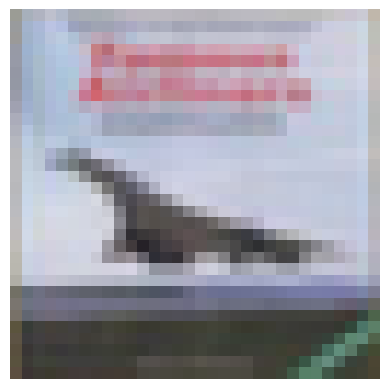

In [ ]:
Controller = 3

img = test_dataset["img"][Controller]
trueindex = test_dataset["label"][Controller]

embs = CreateImageEmbeddings(img)

sparse_embs = SparsifyImageEmbeddings(embs, sparsity_levels[0], A_normalized)

z = MaxPool(embs)
zs = MaxPool(sparse_embs.T)

index_dense = Classify(z, min_text_embeddings)
index_sparse = Classify(zs, min_text_embeddings)


print("Dense Logits: ", index_dense)
print("Sparse Logits: ", index_sparse)
print(f"True Label: {labels[trueindex]}, Dense Prediction: {labels[index_dense.index(max(index_dense))]}, Sparse Prediction: {labels[index_sparse.index(max(index_sparse))]}")

plt.imshow(img)
plt.axis('off')
plt.show()

## RETRY WITH SIGLIP MODEL SIMPLE

Reconstructing Matrix A

In [16]:
from transformers import SiglipTextModel, SiglipTokenizer

text_model = SiglipTextModel.from_pretrained('google/siglip-base-patch16-224')
tokenizer = SiglipTokenizer.from_pretrained("google/siglip-base-patch16-224")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
words = [item[0] for item in t1000 ]

matrixA = []

for word in words:

    tokens = tokenizer(word, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        output = text_model(**tokens, return_dict=True)

    embeddings = output.pooler_output

    for token_emb in embeddings:
        matrixA.append(token_emb)
    print(f"{word} -> embeddings generated")


matrixA = torch.stack(matrixA)
mean_A = matrixA.mean()
A_c = matrixA - mean_A  # Subtract the scalar mean from every element

print(A_c.shape)

norms = A_c.norm(p=2, dim=1, keepdim=True)
A_c = A_c / norms


a -> embeddings generated
in -> embeddings generated
the -> embeddings generated
and -> embeddings generated
on -> embeddings generated
is -> embeddings generated
man -> embeddings generated
of -> embeddings generated
with -> embeddings generated
woman -> embeddings generated
wearing -> embeddings generated
two -> embeddings generated
to -> embeddings generated
at -> embeddings generated
are -> embeddings generated
an -> embeddings generated
shirt -> embeddings generated
while -> embeddings generated
white -> embeddings generated
people -> embeddings generated
young -> embeddings generated
black -> embeddings generated
blue -> embeddings generated
boy -> embeddings generated
red -> embeddings generated
girl -> embeddings generated
his -> embeddings generated
playing -> embeddings generated
standing -> embeddings generated
her -> embeddings generated
front -> embeddings generated
sitting -> embeddings generated
street -> embeddings generated
dog -> embeddings generated
men -> embeddings

In [27]:
from sklearn.linear_model import Lasso

def normalize(vector):
    mean = torch.mean(vector, dim=1, keepdim=True)
    centered_vector = vector - mean
    l2_norm = torch.norm(centered_vector, p=2, dim=1, keepdim=True)
    normalized_vector = centered_vector / l2_norm
    return normalized_vector


def CudaToNumpy(tensor):
    tensor = tensor.cpu()
    tensor = tensor.detach().numpy()
    return tensor


def SparsifyImageEmbeddings(zc, A_c, level):
    zc = normalize(torch.tensor(zc))
    # zc = CudaToNumpy(zc)
    A_c = A_c.numpy()


    sparser = Lasso(alpha=level, fit_intercept=False)
    sparser.fit(A_c.T, zc.T)
    w = sparser.coef_
    ones = np.ones((1, 768)) # Might have to change this if z changes
    uc = mean_A * ones # Mean Scalar of Original Concept Matrix


    #print(matrixA.shape)
    #print(w.shape)

    # 1)
    # z_sparse = matrixA.T @ w
    # print("Sparse Sum: ", z_sparse.sum())
    # return z_sparse.unsqueeze(dim=0)

    # 2)
    z_sparse = A_c.T @ w

    print("Sparsity: ", (1 - np.count_nonzero(w) / 4539) * 100)

    z = np.add(z_sparse, uc)
    z = torch.tensor(z)

    return z





def CosineSimilarity(img_emb, txt_emb):
    # print("Image and Text are same: ", (img_emb == txt_emb).all())

    img_emb_norm = img_emb / np.linalg.norm(img_emb)
    txt_emb_norm = txt_emb / np.linalg.norm(txt_emb)

    sim = np.dot(img_emb_norm, txt_emb_norm)

    # print("Similarity: ", sim)

    return sim


def Classify(img_emb, txt_embs):
  logits = []
  for i, txt_emb in enumerate(txt_embs):
    sim = CosineSimilarity(img_emb, txt_emb)
    logits.append(sim)
  return logits

In [18]:
Controller = 32



from transformers import SiglipModel, SiglipProcessor

img = test_dataset["img"][Controller]
trueindex = test_dataset["label"][Controller]

main_model = SiglipModel.from_pretrained("google/siglip-base-patch16-224")
main_processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")

inputs = main_processor(text=labels, images=img, padding="max_length", return_tensors="pt")

with torch.no_grad():
    outputs = main_model(**inputs, return_dict=True) # THIS IS TRUE DOCU IS WRONG

# Val0: 1e-5
# Val1: 1e-6
# Val2: 1e-7
# Val3: 1e-8
# Val4: 1e-9
# Val4: 1e-10
# Val4: 1e-11
# Val4: 1e-12
# Val4: 1e-13




txt_embs = outputs.text_embeds
img_emb = outputs.image_embeds
sparse_img_emb = SparsifyImageEmbeddings(img_emb, A_c, 1e-5)


# print(outputs.text_embeds.shape)
# print(outputs.image_embeds.shape)
# print(output.text_embeds)
# print(output.image_embeds)

print(img_emb.shape)
print(sparse_img_emb.shape)



dense_logits = Classify(txt_embs, img_emb)
dense_logits = dense_logits[0]


sparse_logits = Classify(txt_embs, sparse_img_emb)
sparse_logits = sparse_logits[0]




print("Dense Logits: ", dense_logits)
print("Sparse Logits: ", sparse_logits)

print(f"True Label: {trueindex}, Dense Prediction: {np.argmax(dense_logits)}")
print(f"True Label: {trueindex}, Sparse Prediction: {np.argmax(sparse_logits)}")


<ipython-input-17-c1836798c4b4>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zc = normalize(torch.tensor(zc))


Sparsity:  83.07997356245869
torch.Size([1, 768])
torch.Size([1, 768])
Dense Logits:  [-0.00246225 -0.00613629  0.01610332  0.02099988  0.02479945  0.01738833
  0.01173501  0.01286649 -0.00233503  0.00115294]
Sparse Logits:  [-0.00122067 -0.0052801   0.01304436  0.01941347  0.0197839   0.01140056
  0.008775    0.01141852  0.00083421 -0.0001006 ]
True Label: 4, Dense Prediction: 4
True Label: 4, Sparse Prediction: 4


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.834e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


## Finally we conduct classification

Sparsity Regulator: 1e-10

In [26]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# labels = [f'This is a photo of {label}' for label in labels]
def evaluate(level, n):
    main_model.to(device)
    all_labels = []
    all_preds = test_dataset["label"][0:n]

    for i in range(n):
        img = test_dataset["img"][i]
        inputs = main_processor(text=labels, images=img, padding="max_length", return_tensors="pt")
        inputs = inputs.to(device)

        if(i % 5 == 0):
            print(f"{i} done")

        with torch.no_grad():
            outputs = main_model(**inputs, return_dict=True)

        txt_embs = outputs.text_embeds
        img_emb = outputs.image_embeds


        txt_embs = CudaToNumpy(txt_embs)
        img_emb = CudaToNumpy(img_emb)

        if(level == -1):
            dense_logits = Classify(txt_embs, normalize(torch.tensor(img_emb)).numpy())
            dense_logits = dense_logits[0]
            all_labels.append(np.argmax(dense_logits))

        else:
            sparse_img_emb = SparsifyImageEmbeddings(img_emb, A_c, level)
            sparse_logits = Classify(txt_embs, sparse_img_emb)
            sparse_logits = sparse_logits[0]
            all_labels.append(np.argmax(sparse_logits))




    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [ ]:
evaluate(-1)

0 done
500 done
1000 done
1500 done
2000 done
2500 done
3000 done
3500 done
4000 done
4500 done
5000 done
5500 done
6000 done
6500 done
7000 done
7500 done
8000 done
8500 done
9000 done
9500 done
Accuracy: 0.9100
Precision: 0.9135
Recall: 0.9100
F1 Score: 0.9092


In [ ]:
evaluate(1e-10)

/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.421e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9927195
Sparse Sum:  0.4358461


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13202453
Sparse Sum:  0.2294206


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17124963
Sparse Sum:  0.17258923


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44045377
Sparse Sum:  0.037125513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62991655
Sparse Sum:  0.32936606


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.384e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12576616
Sparse Sum:  0.10719252


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6179717
Sparse Sum:  1.6982942


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7756926
Sparse Sum:  1.3926309


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.089524835
Sparse Sum:  1.0809915


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5702423
Sparse Sum:  0.65634286


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4107731
Sparse Sum:  1.0130765


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31653547
Sparse Sum:  0.81084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9561947
Sparse Sum:  0.6225008


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6498945
Sparse Sum:  0.3812561


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1348636
Sparse Sum:  2.0561256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2663902
Sparse Sum:  0.5915978


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3416138
Sparse Sum:  0.7219228


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1028683
Sparse Sum:  0.935586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14045744
Sparse Sum:  0.22115527


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.416528
Sparse Sum:  0.9489193


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.16895136
Sparse Sum:  -0.015474081


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9030305
Sparse Sum:  0.9805581


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.649055
Sparse Sum:  1.0519614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48668483
Sparse Sum:  0.6886669


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2880307
Sparse Sum:  0.62648517


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.368e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.07548411
Sparse Sum:  -0.1538293


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.396e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36539674
Sparse Sum:  0.87755334


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4288023
Sparse Sum:  0.9958651


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4234618
Sparse Sum:  0.50439376


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50224024
Sparse Sum:  0.25840777


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1797826
Sparse Sum:  0.67919874


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3393072
Sparse Sum:  0.010994256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6970437
Sparse Sum:  0.5845108


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5890526
Sparse Sum:  0.54282355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.036852032
Sparse Sum:  0.9459213


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37992698
Sparse Sum:  1.3855648


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22129558
Sparse Sum:  0.20389614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33638203
Sparse Sum:  0.77527887


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82825494
Sparse Sum:  0.17600802


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.193e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.632051
Sparse Sum:  0.2453602


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4947537
Sparse Sum:  1.6077921


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4691223
Sparse Sum:  1.4445052


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3604591
Sparse Sum:  0.7896661


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7168256
Sparse Sum:  0.5134342


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75532985
Sparse Sum:  0.38039708


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.312e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25304905
Sparse Sum:  1.6453173


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1318767
Sparse Sum:  0.6513422


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0851868
Sparse Sum:  1.2529938


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1055534
Sparse Sum:  0.16666839


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39377448
Sparse Sum:  1.4746597


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.510301
Sparse Sum:  0.33149812


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2956689
Sparse Sum:  0.64910483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96874976
Sparse Sum:  1.4129255


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9109223
Sparse Sum:  0.8658422


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.252635
Sparse Sum:  0.68019587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7107003
Sparse Sum:  1.5612738


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51583457
Sparse Sum:  0.34912515


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56284964
Sparse Sum:  0.92894864


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9817002
Sparse Sum:  0.04859394


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.147165
Sparse Sum:  1.0015774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9031572
Sparse Sum:  0.59305006


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7339272
Sparse Sum:  1.0719386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40019226
Sparse Sum:  -0.08586678


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7381425
Sparse Sum:  1.2470132


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67843413
Sparse Sum:  0.95514023


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94233614
Sparse Sum:  1.0684146


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68384
Sparse Sum:  0.78465354


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5980392
Sparse Sum:  0.9930567


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79069924
Sparse Sum:  0.25942343


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11347914
Sparse Sum:  1.1267593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.790e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.964942
Sparse Sum:  0.55524474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1613227
Sparse Sum:  0.9630804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26140946
Sparse Sum:  0.3934513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1962867
Sparse Sum:  1.0307302


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3095129
Sparse Sum:  0.55120885


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4452201
Sparse Sum:  -0.13280895


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8018459
Sparse Sum:  0.8548529


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.356e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6698078
Sparse Sum:  1.2722638


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2916864
Sparse Sum:  0.42173967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64364916
Sparse Sum:  0.88673127


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30934367
Sparse Sum:  0.7602389


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1501278
Sparse Sum:  0.56463665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.00069764256
Sparse Sum:  1.1522794


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2628613
Sparse Sum:  0.6990821


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19627851
Sparse Sum:  0.7377173


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53442705
Sparse Sum:  1.2911185


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6433736
Sparse Sum:  0.5395447


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.011651143
Sparse Sum:  0.43075538


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.508801
Sparse Sum:  0.39360842


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.37349668
Sparse Sum:  0.3923773


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25072783
Sparse Sum:  0.13373634


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.24773943
Sparse Sum:  0.26911178


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7432756
Sparse Sum:  0.63543713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48428422
Sparse Sum:  1.1362293


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2540682
Sparse Sum:  0.3850552


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62174875
Sparse Sum:  0.4839717


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6578187
Sparse Sum:  0.23461697


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6961031
Sparse Sum:  0.24173304


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.65424246
Sparse Sum:  0.019079596


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8889357
Sparse Sum:  0.7190968


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5916842
Sparse Sum:  -0.06107965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8422533
Sparse Sum:  0.6837508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34724346
Sparse Sum:  1.0626671


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2838295
Sparse Sum:  1.0207273


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0349555
Sparse Sum:  0.9722417


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.578e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0072645
Sparse Sum:  -0.08774546


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15615414
Sparse Sum:  1.0581875


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.018085867
Sparse Sum:  0.80988324


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.8453937
Sparse Sum:  1.2865672


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6466266
Sparse Sum:  0.7919869


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55417365
Sparse Sum:  0.88896066


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0539875
Sparse Sum:  0.9964998


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26500475
Sparse Sum:  1.1554826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3022852
Sparse Sum:  0.36461568


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0476928
Sparse Sum:  0.22945592


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45724523
Sparse Sum:  0.2084558


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.74650383
Sparse Sum:  0.13795012


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90485907
Sparse Sum:  -0.08181286


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54432464
Sparse Sum:  0.7184142


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4596545
Sparse Sum:  -0.13426657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.11036
Sparse Sum:  0.67296684


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1211691
Sparse Sum:  0.41896906


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1826609
Sparse Sum:  0.18924643


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54618454
Sparse Sum:  0.84778607


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.245e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1555377
Sparse Sum:  1.0458643


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6387416
Sparse Sum:  0.5163435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5358392
Sparse Sum:  0.2781273


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55413276
Sparse Sum:  0.60325754


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87226105
Sparse Sum:  0.57471406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.623637
Sparse Sum:  0.4350231


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11706665
Sparse Sum:  0.4993223
Sparse Sum:  0.973903


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71645296
Sparse Sum:  0.36379963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8938077
Sparse Sum:  0.04660377


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.082524225
Sparse Sum:  0.5889711


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.141e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40374446
Sparse Sum:  0.95686466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70772535
Sparse Sum:  1.1254371


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0361401
Sparse Sum:  0.90547514


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38873705
Sparse Sum:  1.3957336


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1547396
Sparse Sum:  0.6132468


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.335e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0864165
Sparse Sum:  0.39414197


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0702201
Sparse Sum:  0.96388155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18611786
Sparse Sum:  1.3302443


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.347e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22111514
Sparse Sum:  0.8732938


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49066046
Sparse Sum:  0.7764321


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.517575
Sparse Sum:  0.5759256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.19933899
Sparse Sum:  1.2074324


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6013715
Sparse Sum:  0.4637176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.928858
Sparse Sum:  0.23753124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69650954
Sparse Sum:  -0.1894839


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7298981
Sparse Sum:  0.7738434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43534482
Sparse Sum:  0.63667023


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.134e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4105611
Sparse Sum:  0.54658234


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8782474
Sparse Sum:  0.30978194


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79541826
Sparse Sum:  0.50457567


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90264255
Sparse Sum:  1.179635


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29219812
Sparse Sum:  1.3140278


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.220e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.19977066
Sparse Sum:  0.03483805


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16798526
Sparse Sum:  0.9843546


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11542426
Sparse Sum:  0.08369896


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1973178
Sparse Sum:  1.3108007


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3146273
Sparse Sum:  0.7575455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30495918
Sparse Sum:  0.5991348


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22201832
Sparse Sum:  0.21004322


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48372903
Sparse Sum:  0.55493355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5148647
Sparse Sum:  0.71889853


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7462146
Sparse Sum:  0.47724587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.415e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.23986056
Sparse Sum:  0.8263532


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8203447
Sparse Sum:  -0.35595518


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6775236
Sparse Sum:  0.868186
3500 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18565328
Sparse Sum:  0.7512502


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8780223
Sparse Sum:  0.6442854


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45084625
Sparse Sum:  1.5090209


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4541782
Sparse Sum:  1.0914825


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5525359
Sparse Sum:  0.6360352


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46207216
Sparse Sum:  0.40962017


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7234795
Sparse Sum:  1.3351285


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3393609
Sparse Sum:  0.880037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26648396
Sparse Sum:  0.34857976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75030994
Sparse Sum:  -0.09794515


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0527512
Sparse Sum:  1.2055404


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15591526
Sparse Sum:  0.57804203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2385502
Sparse Sum:  0.31740052


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1051555
Sparse Sum:  0.13058686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2908538
Sparse Sum:  0.77766323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73008317
Sparse Sum:  0.054555267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75353676
Sparse Sum:  0.1899226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0558448
Sparse Sum:  0.8094356


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36189044
Sparse Sum:  0.30458063


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.283e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84213156
Sparse Sum:  0.4276201


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1673844
Sparse Sum:  0.62346506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0539818
Sparse Sum:  0.13255148


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23582539
Sparse Sum:  0.79201496


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25450653
Sparse Sum:  1.2528183


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2424531
Sparse Sum:  0.5210788


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08014378
Sparse Sum:  0.9268725


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3805821
Sparse Sum:  0.46767426


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49356714
Sparse Sum:  0.67593896


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.15221217
Sparse Sum:  -0.00825721


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25090677
Sparse Sum:  1.2455573


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56216264
Sparse Sum:  0.75440073


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22916114
Sparse Sum:  0.19625632


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.871554
Sparse Sum:  0.8459312


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76404595
Sparse Sum:  0.12450558


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.033285588
Sparse Sum:  -0.006385237


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73459697
Sparse Sum:  0.66814876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.484e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47223547
Sparse Sum:  1.2529012


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8428241
Sparse Sum:  1.2142802


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4309609
Sparse Sum:  0.3504356


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.164e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.047364
Sparse Sum:  1.1698396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44781786
Sparse Sum:  1.1023917


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37275577
Sparse Sum:  0.53263605


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8011872
Sparse Sum:  0.7072704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9265578
Sparse Sum:  0.20917344


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13850406
Sparse Sum:  1.4441314


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1913276
Sparse Sum:  0.8575452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5034584
Sparse Sum:  0.49025917


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1594899
Sparse Sum:  1.2749475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.325807
Sparse Sum:  0.3657404


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.950959
Sparse Sum:  1.1314516


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0047588
Sparse Sum:  0.088106155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.479e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36782634
Sparse Sum:  0.16595264


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7766614
Sparse Sum:  0.37064493


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99776775
Sparse Sum:  0.4464162


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47526556
Sparse Sum:  0.9750185


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6959641
Sparse Sum:  0.14937446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14143091
Sparse Sum:  0.79744333


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28684926
Sparse Sum:  0.5211217


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.229e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4994919
Sparse Sum:  0.65275455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9887489
Sparse Sum:  0.5022868


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38323206
Sparse Sum:  1.5075724


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0379048
Sparse Sum:  0.8521665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2033374
Sparse Sum:  1.0116737


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2569666
Sparse Sum:  0.23268287


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68843484
Sparse Sum:  0.63847184


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2147229
Sparse Sum:  0.37050244


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10051653
Sparse Sum:  0.7388082


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3765798
Sparse Sum:  1.3059669


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86307687
Sparse Sum:  0.27169102


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5424357
Sparse Sum:  1.4561357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13296756
Sparse Sum:  1.2221143


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40164563
Sparse Sum:  0.13529699


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24216104
Sparse Sum:  -0.024373814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0748891
Sparse Sum:  1.4008384


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3595223
Sparse Sum:  0.9987041


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17686975
Sparse Sum:  0.5756608


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7001387
Sparse Sum:  -0.40557685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66056705
Sparse Sum:  0.9203704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50592744
Sparse Sum:  0.9526984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83704746
Sparse Sum:  0.43912286


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88561726
Sparse Sum:  0.26967126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.10958579
Sparse Sum:  0.9001934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41006243
Sparse Sum:  1.4987007


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85198915
Sparse Sum:  0.49975488


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1714125
Sparse Sum:  0.7594212


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82159626
Sparse Sum:  1.2654414


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68729365
Sparse Sum:  1.0029665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2178396
Sparse Sum:  0.6629374


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.009104155
Sparse Sum:  0.607956


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.417e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7108696
Sparse Sum:  0.79589814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2979036
Sparse Sum:  1.218209


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6485525
Sparse Sum:  -0.10196116


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72359073
Sparse Sum:  0.117708504


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7138026
Sparse Sum:  0.77255225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82967556
Sparse Sum:  1.1371272


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.073301256
Sparse Sum:  0.89136696


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87700605
Sparse Sum:  0.8312634


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0378389
Sparse Sum:  0.7170965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63380694
Sparse Sum:  0.90841866


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34208378
Sparse Sum:  0.49326628


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7453231
Sparse Sum:  0.45050102


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82597077
Sparse Sum:  0.42904937


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6456281
Sparse Sum:  0.37728143


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.638003
Sparse Sum:  0.31666976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35043067
Sparse Sum:  0.44491452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0389476
Sparse Sum:  -0.5352954


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2672236
Sparse Sum:  0.2584436


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80211735
Sparse Sum:  0.54274404


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47678724
Sparse Sum:  0.12834616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.406e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17099842
Sparse Sum:  0.7459488


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54052246
Sparse Sum:  0.716058


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.8699342
Sparse Sum:  1.0647722


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.306e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.20315224
Sparse Sum:  0.41211325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7763991
Sparse Sum:  0.7754937


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.611662
Sparse Sum:  0.6406236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28191322
Sparse Sum:  0.20978037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58784056
Sparse Sum:  0.27583843


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.93155944
Sparse Sum:  0.478803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25871623
Sparse Sum:  0.6500921


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.307e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2387292
Sparse Sum:  0.8898126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86145025
Sparse Sum:  0.12255865


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.635869
Sparse Sum:  0.5612561


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2235883
Sparse Sum:  0.8458265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86206627
Sparse Sum:  0.7010608


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1307666
Sparse Sum:  -0.0072817206


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21814698
Sparse Sum:  1.7770501


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.12876183
Sparse Sum:  -0.045125097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1842838
Sparse Sum:  0.22306612


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.151973
Sparse Sum:  0.24280962


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5190325
Sparse Sum:  0.6592973


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5605252
Sparse Sum:  0.61967796


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.066864036
Sparse Sum:  0.72612554


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89103436
Sparse Sum:  -0.11026953


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5692071
Sparse Sum:  0.17285955


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.143e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18541735
Sparse Sum:  -0.093158975


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44377446
Sparse Sum:  0.60220015


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.225e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2714869
Sparse Sum:  0.3763547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.1463834
Sparse Sum:  0.20939152


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.008737
Sparse Sum:  1.3318691


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3250868
Sparse Sum:  0.17747346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88164127
Sparse Sum:  0.6756936


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43386787
Sparse Sum:  1.0000198


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58480895
Sparse Sum:  0.14119521


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.338243
Sparse Sum:  0.7985666


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1770709
Sparse Sum:  0.54630935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1831126
Sparse Sum:  0.6962341


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6228303
Sparse Sum:  0.50002


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8657826
Sparse Sum:  1.2626055


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1145562
Sparse Sum:  0.35072035


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.93126726
Sparse Sum:  0.16440663


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.227e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.077169664
Sparse Sum:  0.71208763


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0328627
Sparse Sum:  0.40656075


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9489325
Sparse Sum:  0.1863966


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08470312
Sparse Sum:  -0.12493393


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6668698
Sparse Sum:  0.49906278


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97669345
Sparse Sum:  1.71647


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47674656
Sparse Sum:  0.08302416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6911641
Sparse Sum:  0.6782279


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4336982
Sparse Sum:  0.38791513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9282056
Sparse Sum:  0.35413554


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.20120424
Sparse Sum:  0.9870106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0280008
Sparse Sum:  1.2708776


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6106864
Sparse Sum:  0.56275845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29019696
Sparse Sum:  0.97457814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62578046
Sparse Sum:  1.1152364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6732724
Sparse Sum:  0.4608078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7716133
Sparse Sum:  0.51697123


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.10937387
Sparse Sum:  1.3959732


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.215e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5090212
Sparse Sum:  0.96838343


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8992779
Sparse Sum:  0.75820124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0657991
Sparse Sum:  0.58694416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3328658
Sparse Sum:  1.1537347


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97596234
Sparse Sum:  0.46346933


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8454113
Sparse Sum:  0.6370424


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.93854225
Sparse Sum:  0.91798085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55991685
Sparse Sum:  0.9441156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91573614
Sparse Sum:  0.599519


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23034415
Sparse Sum:  0.5347432


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67583346
Sparse Sum:  0.116312176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8532055
Sparse Sum:  0.9981411


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.302285
Sparse Sum:  0.6002676


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7115969
Sparse Sum:  0.40597686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.254e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.1399572
Sparse Sum:  1.4123517


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.120397985
Sparse Sum:  0.5887225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1054692
Sparse Sum:  1.1584353


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42876837
Sparse Sum:  0.7204009


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0406657
Sparse Sum:  1.3886862


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1937772
Sparse Sum:  0.5150378


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2852576
Sparse Sum:  0.8104298


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88828605
Sparse Sum:  0.546368


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35743058
Sparse Sum:  1.4081218


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.022598892
Sparse Sum:  0.8033485


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0590571
Sparse Sum:  0.37243095


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98895556
Sparse Sum:  0.67113394


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10303146
Sparse Sum:  -0.19166371


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.006063
Sparse Sum:  0.9850837


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.083e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6523906
Sparse Sum:  1.1729819


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.93465304
Sparse Sum:  0.22840829


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41195387
Sparse Sum:  0.3421914


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20077956
Sparse Sum:  0.4720086


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0764734
Sparse Sum:  0.24139446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.284e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59031546
Sparse Sum:  0.08431816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.008664787
Sparse Sum:  0.16668957


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.800815
Sparse Sum:  0.65609324


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.654141
Sparse Sum:  0.6318792


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6638263
Sparse Sum:  0.54932106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1891251
Sparse Sum:  1.3100979


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3855884
Sparse Sum:  0.97166586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0900161
Sparse Sum:  1.2693393


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9970317
Sparse Sum:  1.2374954


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52924776
Sparse Sum:  0.5306513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22094688
Sparse Sum:  0.755128


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.345e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4972226
Sparse Sum:  -0.17788121


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.200e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6676488
Sparse Sum:  0.38733923


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9721983
Sparse Sum:  0.50655353


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6134709
Sparse Sum:  0.9826813


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2040179
Sparse Sum:  0.0809734


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34260744
Sparse Sum:  0.879473


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5084877
Sparse Sum:  1.4462723


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32737997
Sparse Sum:  0.64938664


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.157137
Sparse Sum:  -0.13378538


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6689948
Sparse Sum:  0.8255584


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.157361
Sparse Sum:  1.0684867


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.264864
Sparse Sum:  0.5826511


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2735283
Sparse Sum:  1.020898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9608356
Sparse Sum:  0.77676815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32877922
Sparse Sum:  0.48469973


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6184177
Sparse Sum:  0.72929084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4576874
Sparse Sum:  1.0979685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6782036
Sparse Sum:  0.86967933


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1321067
Sparse Sum:  0.6994037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.851356
Sparse Sum:  0.26010734


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6309599
Sparse Sum:  0.70597124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7206614
Sparse Sum:  0.9359288


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16509166
Sparse Sum:  0.97348344


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5381354
Sparse Sum:  0.4109059


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0280619
Sparse Sum:  0.31503415
Sparse Sum:  0.26182652
Sparse Sum:  1.5309342


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.34004503
Sparse Sum:  0.22253852


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79939973
Sparse Sum:  0.8476527


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.20895681
Sparse Sum:  0.8437334


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88022834
Sparse Sum:  0.6640982


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12323641
Sparse Sum:  1.5122573


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9683352
Sparse Sum:  0.7484629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.38640326
Sparse Sum:  0.5588231


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0337517
Sparse Sum:  0.7168572


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66072667
Sparse Sum:  0.09301266


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3248285
Sparse Sum:  0.92638856


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.029529423
Sparse Sum:  1.4046283


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.107016
Sparse Sum:  0.4250622
4000 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13004577
Sparse Sum:  0.3212242


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23386218
Sparse Sum:  0.57472175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29195562
Sparse Sum:  0.7010501


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23818925
Sparse Sum:  0.56683826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85990536
Sparse Sum:  0.71371627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1813909
Sparse Sum:  0.54397213


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4026818
Sparse Sum:  0.49114248


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8251382
Sparse Sum:  0.84493595


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17538819
Sparse Sum:  0.87810224


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.247e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28251436
Sparse Sum:  1.1007814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5647042
Sparse Sum:  0.9339678


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.267e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.038460672
Sparse Sum:  0.005297616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5889355
Sparse Sum:  0.62387764


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.189e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79360175
Sparse Sum:  1.1371585


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08547968
Sparse Sum:  1.4670072


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23450801
Sparse Sum:  0.6453865


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0761826
Sparse Sum:  0.10795401


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7415849
Sparse Sum:  0.92029506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90429807
Sparse Sum:  0.50301397


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22649193
Sparse Sum:  1.1833214


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7173822
Sparse Sum:  1.2307436


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0715901
Sparse Sum:  1.0609281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.697873
Sparse Sum:  1.1556089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8749086
Sparse Sum:  1.3146901


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80795264
Sparse Sum:  0.8774604


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94594574
Sparse Sum:  0.7841744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.356e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27176392
Sparse Sum:  0.7487062


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22105297
Sparse Sum:  0.17178223


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75616616
Sparse Sum:  0.55952114


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.821665
Sparse Sum:  0.55919856


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25710547
Sparse Sum:  1.0316068


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55733454
Sparse Sum:  0.8890346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3170971
Sparse Sum:  0.94416976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11317876
Sparse Sum:  0.5147908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8624252
Sparse Sum:  0.86582464


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.983e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5083833
Sparse Sum:  0.0017314255


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7944366
Sparse Sum:  -0.2505228


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7240211
Sparse Sum:  0.7311125


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.142e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2813106
Sparse Sum:  0.9820156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1595051
Sparse Sum:  0.6316266


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14901355
Sparse Sum:  0.54662126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29217649
Sparse Sum:  0.4119583


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2080301
Sparse Sum:  0.7811385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1808381
Sparse Sum:  0.9870936


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0083274
Sparse Sum:  -0.0061077774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2587928
Sparse Sum:  0.6725475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4534569
Sparse Sum:  0.41854882


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6277042
Sparse Sum:  0.76414406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2145147
Sparse Sum:  0.56267834


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8339083
Sparse Sum:  1.0795201


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6493003
Sparse Sum:  0.47532296


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60912395
Sparse Sum:  0.9591701


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37074098
Sparse Sum:  1.4953752


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6215037
Sparse Sum:  0.8742367


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4148881
Sparse Sum:  0.3892909
Sparse Sum:  1.0695797


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50157166
Sparse Sum:  0.65725374


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86565125
Sparse Sum:  0.5393085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90664047
Sparse Sum:  1.16058


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4000797
Sparse Sum:  0.24711746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7396276
Sparse Sum:  0.7824949


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2624321
Sparse Sum:  0.025476396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.259e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37337393
Sparse Sum:  1.073581


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89955527
Sparse Sum:  0.08688678


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.029880598
Sparse Sum:  0.43904147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70696384
Sparse Sum:  0.83994234


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5189347
Sparse Sum:  0.5844422


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6909546
Sparse Sum:  0.5768211


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.09032416
Sparse Sum:  1.0532626


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61318994
Sparse Sum:  1.4810236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6867166
Sparse Sum:  0.7419506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9615952
Sparse Sum:  -0.067736425


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3489853
Sparse Sum:  0.23169023


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3939326
Sparse Sum:  1.0411783


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0232215
Sparse Sum:  0.6400533


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.227e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.107748
Sparse Sum:  0.2686203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19991612
Sparse Sum:  0.59252965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8998687
Sparse Sum:  1.6180948


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98329043
Sparse Sum:  0.03343147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9608605
Sparse Sum:  0.839188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1762309
Sparse Sum:  0.83085406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.30328944
Sparse Sum:  -0.13334192


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5850278
Sparse Sum:  0.5777044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6356159
Sparse Sum:  0.6842294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.281e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79578984
Sparse Sum:  0.95788616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.236372
Sparse Sum:  -0.0061704665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3514285
Sparse Sum:  0.89920783


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7217684
Sparse Sum:  0.7502284


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4156705
Sparse Sum:  0.5737486


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4439634
Sparse Sum:  1.5913305


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10420391
Sparse Sum:  1.2174628


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40770283
Sparse Sum:  1.5909454


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7496661
Sparse Sum:  0.8382143


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4742508
Sparse Sum:  1.2154866


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43581355
Sparse Sum:  0.78189456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59941506
Sparse Sum:  1.165195


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85020286
Sparse Sum:  0.4961549


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1740614
Sparse Sum:  0.23949331


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42721108
Sparse Sum:  1.1666629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8758753
Sparse Sum:  0.3896984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3747807
Sparse Sum:  1.3078102


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.411e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.744691
Sparse Sum:  0.6980168


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7059741
Sparse Sum:  0.33005214


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0710914
Sparse Sum:  0.4719736


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.00018699467
Sparse Sum:  0.35638225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.409e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.014353
Sparse Sum:  -0.17497744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9398705
Sparse Sum:  0.29411054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3063687
Sparse Sum:  1.0972168


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.005818546
Sparse Sum:  0.36854008


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.06670183
Sparse Sum:  0.9719082


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5906025
Sparse Sum:  1.0477096


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0459635
Sparse Sum:  -0.096937776


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5830569
Sparse Sum:  0.96768284


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24972251
Sparse Sum:  0.6460674


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7092588
Sparse Sum:  0.46591437


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2739886
Sparse Sum:  0.22638948


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.475893
Sparse Sum:  0.38821414


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49771076
Sparse Sum:  0.9954232


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62558395
Sparse Sum:  1.0915812


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.034676254
Sparse Sum:  0.8407839


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2163332
Sparse Sum:  0.8159714


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6322415
Sparse Sum:  1.3575859


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0421897
Sparse Sum:  0.8404357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0465302
Sparse Sum:  0.89624697


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0708355
Sparse Sum:  0.81195474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9554784
Sparse Sum:  -0.054729313


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.022812
Sparse Sum:  0.48138493


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.285e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60406685
Sparse Sum:  0.9079455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33626276
Sparse Sum:  0.9772566


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.216e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.105968714
Sparse Sum:  0.45308363


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.145468
Sparse Sum:  0.7239828


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41572613
Sparse Sum:  0.9881412


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.004502803
Sparse Sum:  1.3122364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37792003
Sparse Sum:  0.6270873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.11407
Sparse Sum:  0.79918134


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68710005
Sparse Sum:  0.47261757


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7861872
Sparse Sum:  1.6895261


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79877865
Sparse Sum:  0.18491066


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29148865
Sparse Sum:  0.29499203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30731812
Sparse Sum:  1.0112894


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5542098
Sparse Sum:  0.91548824


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95335025
Sparse Sum:  0.63721395


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21850841
Sparse Sum:  0.79448473


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2610175
Sparse Sum:  0.5753439


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27154034
Sparse Sum:  0.19968054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66583353
Sparse Sum:  0.44070378


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6154968
Sparse Sum:  1.1097898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10281858
Sparse Sum:  0.06347984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.601736
Sparse Sum:  0.5878555


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0290391
Sparse Sum:  0.29877353


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2752029
Sparse Sum:  1.1434762


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.553519
Sparse Sum:  0.87953043


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66291
Sparse Sum:  0.40977305


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5637407
Sparse Sum:  0.8520689


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9347624
Sparse Sum:  0.38067997


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84541297
Sparse Sum:  1.4202204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2200085
Sparse Sum:  1.1449839


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9298057
Sparse Sum:  0.9418984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9157193
Sparse Sum:  0.6495545


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.021142
Sparse Sum:  0.10355504


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8294259
Sparse Sum:  0.59637016


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2528282
Sparse Sum:  1.2980746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8937391
Sparse Sum:  0.859234


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6707632
Sparse Sum:  1.6509012


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.214175
Sparse Sum:  0.6735444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.23485665
Sparse Sum:  0.7792629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4107682
Sparse Sum:  1.238755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9671106
Sparse Sum:  1.1929859


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86260366
Sparse Sum:  1.2763234


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50005776
Sparse Sum:  0.871881


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4284134
Sparse Sum:  0.7722124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70202035
Sparse Sum:  0.8066386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37904555
Sparse Sum:  1.5099281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7473921
Sparse Sum:  0.3954734


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46150112
Sparse Sum:  0.06585084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0549096
Sparse Sum:  1.147702


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89355993
Sparse Sum:  0.77441454


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3250334
Sparse Sum:  1.642741


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48925513
Sparse Sum:  0.75190866


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69983244
Sparse Sum:  0.5139317


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96233094
Sparse Sum:  -0.32053322


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4375209
Sparse Sum:  1.5533438


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5906171
Sparse Sum:  0.16534504


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.293e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58690083
Sparse Sum:  0.073926315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41106173
Sparse Sum:  0.54874647


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4567098
Sparse Sum:  0.40518075


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.249e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.536279
Sparse Sum:  1.0302069


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66981536
Sparse Sum:  0.19920756


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75028074
Sparse Sum:  1.0272906


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.361e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9092661
Sparse Sum:  0.920559


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09308243
Sparse Sum:  0.47472736


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5501459
Sparse Sum:  1.1133533


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55070025
Sparse Sum:  0.5360967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63027024
Sparse Sum:  0.27326864


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.37374508
Sparse Sum:  0.6152855


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6724937
Sparse Sum:  1.1350394


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5095695
Sparse Sum:  1.124646


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9069263
Sparse Sum:  1.1687129


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3839751
Sparse Sum:  0.8645936


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59107256
Sparse Sum:  0.9972333


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2815818
Sparse Sum:  0.79037184


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51988167
Sparse Sum:  0.95922446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25522068
Sparse Sum:  0.18206942


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14276302
Sparse Sum:  0.78305185


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.325e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78838044
Sparse Sum:  -0.060722068


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6425001
Sparse Sum:  0.43020296


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9922062
Sparse Sum:  0.99501014


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6875565
Sparse Sum:  0.6987219


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44902524
Sparse Sum:  0.29124004


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.11123377
Sparse Sum:  0.34713513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1933009
Sparse Sum:  0.9428756


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49321365
Sparse Sum:  -0.09564456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.012032889
Sparse Sum:  0.851107


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5991107
Sparse Sum:  1.0008268


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.41042
Sparse Sum:  0.6844938


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5610844
Sparse Sum:  0.80876267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.054216623
Sparse Sum:  0.9610032


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.797281
Sparse Sum:  0.5873463


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5478922
Sparse Sum:  0.62987494


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81300986
Sparse Sum:  0.54618084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31717765
Sparse Sum:  1.241306


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3896658
Sparse Sum:  -0.1408099


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0599664
Sparse Sum:  -0.12936205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44096583
Sparse Sum:  0.23994344


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1331542
Sparse Sum:  0.8702216


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28847724
Sparse Sum:  -0.101434916


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1631577
Sparse Sum:  0.014245957


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4454154
Sparse Sum:  0.1394071


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5780425
Sparse Sum:  1.0874976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.274e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8842703
Sparse Sum:  0.89307904


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.052984
Sparse Sum:  0.878441


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8912453
Sparse Sum:  0.13200274


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6878645
Sparse Sum:  0.41010445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.40095693
Sparse Sum:  0.38377938


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67270505
Sparse Sum:  0.31041408


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42456806
Sparse Sum:  0.53056544


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8735057
Sparse Sum:  0.9690565


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86156595
Sparse Sum:  0.501848


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.635095
Sparse Sum:  0.22807059


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29405642
Sparse Sum:  0.12783054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66076124
Sparse Sum:  0.45262375


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14411159
Sparse Sum:  0.081620574


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50200766
Sparse Sum:  1.3026813


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.286e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15959965
Sparse Sum:  -0.3792522


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41212857
Sparse Sum:  0.99698853


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.406e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9549772
Sparse Sum:  -0.11094126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35788557
Sparse Sum:  0.42543846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.265e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.676881
Sparse Sum:  0.4482585


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3253375
Sparse Sum:  0.43836936


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6581414
Sparse Sum:  0.75804085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8386774
4500 done
Sparse Sum:  0.5487156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6839043
Sparse Sum:  1.3669201


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3173244
Sparse Sum:  -0.30175763


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7742659
Sparse Sum:  0.07940638


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9134678
Sparse Sum:  0.7690078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5641085
Sparse Sum:  0.3771352


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8292312
Sparse Sum:  0.70450354


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0043581426
Sparse Sum:  0.8328415


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11469248
Sparse Sum:  0.3453893


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.304e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8060701
Sparse Sum:  0.97579944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23154207
Sparse Sum:  1.2160227


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7958385
Sparse Sum:  1.1326592


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1111202
Sparse Sum:  0.1847316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.460e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32929242
Sparse Sum:  1.138344


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64744407
Sparse Sum:  1.3542645


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42789134
Sparse Sum:  0.7120162


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0084573
Sparse Sum:  0.40225494


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7115094
Sparse Sum:  0.89095044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79956585
Sparse Sum:  0.7967016


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6931339
Sparse Sum:  0.956547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4619452
Sparse Sum:  0.4237882


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.266e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24543145
Sparse Sum:  1.1368117


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08928162
Sparse Sum:  1.585451


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3268057
Sparse Sum:  0.1711433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58213764
Sparse Sum:  -0.20700637


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.790e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6601928
Sparse Sum:  0.34591264
Sparse Sum:  0.5526204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.097203
Sparse Sum:  0.65147394


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2664769
Sparse Sum:  0.49378097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15664215
Sparse Sum:  0.59283316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.258e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7980838
Sparse Sum:  0.12970914


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68459547
Sparse Sum:  1.0481652


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3094587
Sparse Sum:  0.64358836


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3488234
Sparse Sum:  -0.20522979


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6549397
Sparse Sum:  0.29572558


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.543316
Sparse Sum:  0.6684475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5710867
Sparse Sum:  1.4630833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79250944
Sparse Sum:  1.1181166


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36335316
Sparse Sum:  -0.033294156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0583829
Sparse Sum:  -0.11780511


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.901034
Sparse Sum:  0.34129912


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33585232
Sparse Sum:  0.4594217


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.009372488
Sparse Sum:  1.2055132


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85323507
Sparse Sum:  0.76995146


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.32213008
Sparse Sum:  0.60642564


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2187036
Sparse Sum:  0.74939644


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24564263
Sparse Sum:  0.922052


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.265e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1734642
Sparse Sum:  0.65905285


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71438265
Sparse Sum:  0.25585508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2156061
Sparse Sum:  0.4062365


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91885614
Sparse Sum:  0.37311095


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.244e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99197817
Sparse Sum:  1.1565645


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.142e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6470832
Sparse Sum:  0.31039175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3484538
Sparse Sum:  0.20108265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0364168
Sparse Sum:  0.09271548


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64759195
Sparse Sum:  0.7903793


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.061026245
Sparse Sum:  0.54481155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1887385
Sparse Sum:  0.7181375


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5789113
Sparse Sum:  0.5871697


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1260334
Sparse Sum:  0.4575212


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19023658
Sparse Sum:  0.7705681


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2860154
Sparse Sum:  0.8832619


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35467488
Sparse Sum:  0.92729443


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95927536
Sparse Sum:  1.077627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7443907
Sparse Sum:  0.511691


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5781486
Sparse Sum:  1.1093978


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7982341
Sparse Sum:  1.1546816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.079e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5500685
Sparse Sum:  0.55878526


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26393038
Sparse Sum:  1.2141986


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0379843
Sparse Sum:  0.57516915


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1962798
Sparse Sum:  0.013606444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.04657492
Sparse Sum:  1.3193212


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.710651
Sparse Sum:  0.4519385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.703e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87013364
Sparse Sum:  1.0427682


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.119069755
Sparse Sum:  0.5981157


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.12357521
Sparse Sum:  0.6826867


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.251e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.471e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31746885
Sparse Sum:  0.2118579


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24470776
Sparse Sum:  1.2597709


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21484493
Sparse Sum:  1.1470264


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5309173
Sparse Sum:  1.3210013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.476e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55291903
Sparse Sum:  0.44952297


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48844507
Sparse Sum:  0.14394224


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.06394738
Sparse Sum:  1.1502806


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9534477
Sparse Sum:  0.77031153


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87115276
Sparse Sum:  0.9187844


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.011597425
Sparse Sum:  0.2696544


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47453004
Sparse Sum:  0.5059059


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6169397
Sparse Sum:  0.25804454


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77818877
Sparse Sum:  1.05436


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.301e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3949634
Sparse Sum:  0.4921373


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4960121
Sparse Sum:  1.0383112


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.182191
Sparse Sum:  0.09035322


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61694074
Sparse Sum:  1.315294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.620005
Sparse Sum:  0.52206945


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32163757
Sparse Sum:  0.65136325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9197682
Sparse Sum:  0.98718166
Sparse Sum:  0.79921657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5204413
Sparse Sum:  0.98662174


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4289275
Sparse Sum:  1.235322


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24045107
Sparse Sum:  0.68509173


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8679256
Sparse Sum:  0.20694412


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64747363
Sparse Sum:  -0.019483581


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62219197
Sparse Sum:  0.1606479


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0149721
Sparse Sum:  0.75657654


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06384361
Sparse Sum:  0.892418


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2299802
Sparse Sum:  0.8658558


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08220188
Sparse Sum:  0.13016754


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8983538
Sparse Sum:  0.29925263


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5676253
Sparse Sum:  0.75783354


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.079e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19445378
Sparse Sum:  0.99231696


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44348344
Sparse Sum:  0.6511072


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.229e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63057435
Sparse Sum:  -0.11219013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0523279
Sparse Sum:  0.5025122


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59643865
Sparse Sum:  0.4066106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6318419
Sparse Sum:  0.3813175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7368268
Sparse Sum:  1.1975939


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76352024
Sparse Sum:  0.17678034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3423085
Sparse Sum:  0.49038753


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.19280988
Sparse Sum:  0.93041974


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.02042064
Sparse Sum:  1.100984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6558889
Sparse Sum:  1.0686228


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44073188
Sparse Sum:  0.52890253


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46850595
Sparse Sum:  0.71348983


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.18202144
Sparse Sum:  0.24541867


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2738595
Sparse Sum:  0.6749429


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23447946
Sparse Sum:  0.13825653


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.023919046
Sparse Sum:  0.03220176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44392508
Sparse Sum:  0.45873225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19194719
Sparse Sum:  0.3622148


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46376377
Sparse Sum:  0.34783673


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2942625
Sparse Sum:  0.82791746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5830136
Sparse Sum:  0.34361804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80485123
Sparse Sum:  0.62058187


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.607e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39202482
Sparse Sum:  0.6292614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48361373
Sparse Sum:  1.3882902


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9166449
Sparse Sum:  1.1081564


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62790334
Sparse Sum:  0.06913793


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3470145
Sparse Sum:  0.59103835


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43223718
Sparse Sum:  0.79940414


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6788907
Sparse Sum:  0.15076111


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76959246
Sparse Sum:  0.01923284


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6973167
Sparse Sum:  -0.09200826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0474688
Sparse Sum:  0.74921614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61561704
Sparse Sum:  0.1590371


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37011492
Sparse Sum:  -0.3212754


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7892697
Sparse Sum:  0.6734799


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8008027
Sparse Sum:  0.4514152


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4073908
Sparse Sum:  1.0636822


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2563964
Sparse Sum:  0.78933686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73703945
Sparse Sum:  1.1231238


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.090556
Sparse Sum:  0.52275693


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.590391
Sparse Sum:  0.91684616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0879718
Sparse Sum:  0.8886934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.321168
Sparse Sum:  -0.16823019


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.238e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7243897
Sparse Sum:  0.91100514


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7047131
Sparse Sum:  0.72533464


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3535808
Sparse Sum:  0.7039497


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.329e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1684095
Sparse Sum:  0.41694427


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9980006
Sparse Sum:  0.093312204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5431616
Sparse Sum:  0.26931423


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8331024
Sparse Sum:  0.54943216


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.936908
Sparse Sum:  0.56267774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2719012
Sparse Sum:  0.4671538


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86888385
Sparse Sum:  0.7958256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1880698
Sparse Sum:  0.36060524


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.740034
Sparse Sum:  0.93115205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5943515
Sparse Sum:  0.085059464


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9215667
Sparse Sum:  1.2443359


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.041446984
Sparse Sum:  0.36093616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6079853
Sparse Sum:  0.9641358


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7255205
Sparse Sum:  -0.16254169


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3572651
Sparse Sum:  0.30009347


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1361303
Sparse Sum:  0.523445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08097243
Sparse Sum:  0.9760566


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7310242
Sparse Sum:  -0.09716001


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45917398
Sparse Sum:  0.7720625


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.337e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39761296
Sparse Sum:  0.22513717
Sparse Sum:  0.17270389


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46198416
Sparse Sum:  1.5183213


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0563447
Sparse Sum:  0.6604614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2694182
Sparse Sum:  0.04326284


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1007807
Sparse Sum:  -0.07167816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7005846
Sparse Sum:  0.4232384


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78253824
Sparse Sum:  0.59272766


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.028200105
Sparse Sum:  0.56700504


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.917e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89146847
Sparse Sum:  0.87247765


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0058217943
Sparse Sum:  0.09864992


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41747397
Sparse Sum:  1.2574176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.06862402
Sparse Sum:  0.62684596


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56005347
Sparse Sum:  0.20353958


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5050144
Sparse Sum:  -0.20671737


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.130361
Sparse Sum:  0.12626493


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87828004
Sparse Sum:  0.26600873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44153443
Sparse Sum:  0.94446313


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98773485
Sparse Sum:  0.032430008


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71703875
Sparse Sum:  0.77124196


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1882247
Sparse Sum:  0.94459516


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5431431
Sparse Sum:  0.46029663


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0220348
Sparse Sum:  1.2389572


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.29778174
Sparse Sum:  0.5628202


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4750459
Sparse Sum:  0.25769165


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29965982
Sparse Sum:  0.76331586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.302e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31956524
Sparse Sum:  0.22510566


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.067467
Sparse Sum:  0.26294857


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.07990438
Sparse Sum:  1.5153188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51203007
Sparse Sum:  1.2896233


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5779474
Sparse Sum:  0.063608065


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.121014446
Sparse Sum:  1.6463727


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.265e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66573405
Sparse Sum:  0.39061713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77667624
Sparse Sum:  0.7748961


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.299351
Sparse Sum:  0.41068947


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8310682
Sparse Sum:  0.91339546


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3087986
Sparse Sum:  0.23921436


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.337e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.099529
Sparse Sum:  0.29088384


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.265827
Sparse Sum:  0.56556493


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98510134
Sparse Sum:  0.94043523


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.391e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8924681
Sparse Sum:  0.39123237


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.300e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37079176
Sparse Sum:  0.17808092


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12261368
Sparse Sum:  0.20588908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5521646
Sparse Sum:  0.2889409


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54901767
Sparse Sum:  1.0047816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.65886176
Sparse Sum:  0.40376762


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16925642
Sparse Sum:  0.47492898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8731946
Sparse Sum:  0.152942


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10952157
Sparse Sum:  0.2828051


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96184874
Sparse Sum:  0.47667187


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5804684
Sparse Sum:  0.5274465


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2029119
Sparse Sum:  0.9052706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96611434
Sparse Sum:  0.91646147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28145865
Sparse Sum:  1.3367463


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59194005
Sparse Sum:  0.74204826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2264612
Sparse Sum:  1.517552


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2304584
Sparse Sum:  0.808557


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5613303
Sparse Sum:  0.5333593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0253642
Sparse Sum:  0.12374785


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6977675
Sparse Sum:  0.37506503


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1416056
Sparse Sum:  0.73086846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6610422
Sparse Sum:  0.90287024


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58561575
Sparse Sum:  0.936958


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8602008
Sparse Sum:  0.58779013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86215353
Sparse Sum:  0.32504323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10977243
Sparse Sum:  0.7764318


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.281e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15277037
Sparse Sum:  0.8703014


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46929288
Sparse Sum:  0.46649778


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6859681
Sparse Sum:  0.6381898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49045804
Sparse Sum:  0.32975116


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7854696
Sparse Sum:  0.4066306


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.160e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.687268
Sparse Sum:  1.0235817


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.349e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5309705
Sparse Sum:  0.25784722


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6166731
Sparse Sum:  1.0964636


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4422344
Sparse Sum:  0.6598117


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9522407
Sparse Sum:  0.17711806
5000 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0883536
Sparse Sum:  0.3786653


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2742424
Sparse Sum:  0.55570215


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83149195
Sparse Sum:  0.93619204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2749838
Sparse Sum:  0.58073056


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97493523
Sparse Sum:  0.44946265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2259429
Sparse Sum:  1.0322813


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.069648355
Sparse Sum:  0.4336092


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0399898
Sparse Sum:  0.8838086


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3807295
Sparse Sum:  0.9891518


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4740566
Sparse Sum:  0.10423532


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3622241
Sparse Sum:  0.35623994


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0917519
Sparse Sum:  -0.04517311


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62220824
Sparse Sum:  0.8612771


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85274315
Sparse Sum:  0.6660973


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6034993
Sparse Sum:  0.63957775


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24033491
Sparse Sum:  1.2886572


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36194897
Sparse Sum:  0.49514288


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4261148
Sparse Sum:  1.2146595


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6745843
Sparse Sum:  0.79462826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2805199
Sparse Sum:  0.30244797


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7096566
Sparse Sum:  -0.22455893


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75754225
Sparse Sum:  0.27774197


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1765301
Sparse Sum:  1.073912


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31071702
Sparse Sum:  0.8171907


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08881655
Sparse Sum:  1.2351966


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7971138
Sparse Sum:  0.5474567


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5246412
Sparse Sum:  0.7657691


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2263911
Sparse Sum:  0.05022636


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2744742
Sparse Sum:  1.216714


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54376805
Sparse Sum:  0.9775181


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46231258
Sparse Sum:  0.20924568


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8737496
Sparse Sum:  0.34833455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69661397
Sparse Sum:  0.81304574


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53688353
Sparse Sum:  1.0656279


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0970383
Sparse Sum:  0.7481898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0619706
Sparse Sum:  0.34359658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.177e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.2101026
Sparse Sum:  0.8574028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10568632
Sparse Sum:  0.30627966


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.424e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91932386
Sparse Sum:  0.7425846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71041787
Sparse Sum:  1.1457037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95868
Sparse Sum:  0.9877806


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8962382
Sparse Sum:  1.0579612


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31308502
Sparse Sum:  0.7165339


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35608193
Sparse Sum:  0.45413768


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7992519
Sparse Sum:  -0.21491428


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43884057
Sparse Sum:  0.46084785


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25538862
Sparse Sum:  1.0745368


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.309e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33078146
Sparse Sum:  0.49593666


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21335027
Sparse Sum:  1.311778


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5016997
Sparse Sum:  1.1166325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61319685
Sparse Sum:  0.6610695


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8707989
Sparse Sum:  0.538967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.04917583
Sparse Sum:  0.94241256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38255346
Sparse Sum:  0.56845856


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.13017878
Sparse Sum:  0.5908386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6903706
Sparse Sum:  -0.009053946


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5046388
Sparse Sum:  0.6969336


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3522623
Sparse Sum:  0.0769662


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5155129
Sparse Sum:  0.6052315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3566041
Sparse Sum:  1.1464312


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26345897
Sparse Sum:  0.3723258


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28374025
Sparse Sum:  0.5153069


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69010484
Sparse Sum:  0.7678466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34342346
Sparse Sum:  0.5420471


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17321119
Sparse Sum:  0.2804519


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66645503
Sparse Sum:  -0.13841286


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.13300046
Sparse Sum:  1.3105652


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.143e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36117256
Sparse Sum:  0.8043823


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49103394
Sparse Sum:  0.75948


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.403e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1727746
Sparse Sum:  0.91219616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.097187296
Sparse Sum:  0.16328731


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3130645
Sparse Sum:  1.2440015


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75162184
Sparse Sum:  1.0506474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0452693
Sparse Sum:  0.51688325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71274364
Sparse Sum:  0.64745444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2234757
Sparse Sum:  0.54558027


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7231954
Sparse Sum:  1.1639938


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08622402
Sparse Sum:  1.0406547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26728246
Sparse Sum:  0.4704913


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.643401
Sparse Sum:  0.26435876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.282132
Sparse Sum:  0.6699437


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6582383
Sparse Sum:  0.42930275


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6994205
Sparse Sum:  1.2327199


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3166135
Sparse Sum:  0.28840083


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6650862
Sparse Sum:  0.50853926


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5283392
Sparse Sum:  1.2914364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7119868
Sparse Sum:  0.13714954


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.241e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.03503838
Sparse Sum:  0.60828686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35167813
Sparse Sum:  0.8403052


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59466124
Sparse Sum:  0.75581


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4850499
Sparse Sum:  1.1755166


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.07324365
Sparse Sum:  1.0443695


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8483938
Sparse Sum:  0.2520544


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.542734
Sparse Sum:  0.8064541


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7896272
Sparse Sum:  0.6924749


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.34362945
Sparse Sum:  0.29343468


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7331401
Sparse Sum:  0.4467665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96882993
Sparse Sum:  1.0083456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21994306
Sparse Sum:  0.34368813


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.80654305
Sparse Sum:  0.51445854


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3912664
Sparse Sum:  0.66902405


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.390e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76032686
Sparse Sum:  0.07612834


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5116237
Sparse Sum:  0.7105012


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14702159
Sparse Sum:  -0.02950728


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88271976
Sparse Sum:  1.636124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.060026705
Sparse Sum:  0.5998386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6886892
Sparse Sum:  -0.16469607


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.868073
Sparse Sum:  1.0323019


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16844349
Sparse Sum:  0.33745044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6564666
Sparse Sum:  1.3779235


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11197889
Sparse Sum:  1.3686926


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8579016
Sparse Sum:  -0.13322048


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36711857
Sparse Sum:  0.726411


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5333867
Sparse Sum:  0.34955704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7108328
Sparse Sum:  -0.23895535


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6970545
Sparse Sum:  0.8240884


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5146973
Sparse Sum:  0.011599749


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91175544
Sparse Sum:  0.0830003


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.384e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8615247
Sparse Sum:  1.1032889


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25228474
Sparse Sum:  0.9374142


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24022567
Sparse Sum:  0.64672387


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2866586
Sparse Sum:  0.80634993


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1788329
Sparse Sum:  1.0644672


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0919138
Sparse Sum:  1.3551028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1684105
Sparse Sum:  0.61103123


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1252872
Sparse Sum:  0.6072258


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1458466
Sparse Sum:  0.75968146


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.313e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36652133
Sparse Sum:  0.8249097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5569197
Sparse Sum:  0.8346714


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5054019
Sparse Sum:  0.40971634


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.336e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8381957
Sparse Sum:  1.0531106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12977134
Sparse Sum:  0.1791318


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18011506
Sparse Sum:  0.9256561


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28401548
Sparse Sum:  0.27449965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7751051
Sparse Sum:  0.73109967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.130e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59272593
Sparse Sum:  1.0344753


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.237e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.061016575
Sparse Sum:  0.49131143


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.175e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9288454
Sparse Sum:  1.8870175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8667046
Sparse Sum:  0.7822472


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31507292
Sparse Sum:  0.18658172


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34111804
Sparse Sum:  0.7111528


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3942144
Sparse Sum:  0.5958481


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.525e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73986447
Sparse Sum:  0.9865433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.15888745
Sparse Sum:  0.5733174


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37473258
Sparse Sum:  0.9592527


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36015224
Sparse Sum:  0.2368455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3280098
Sparse Sum:  0.075771004


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23162663
Sparse Sum:  0.699196


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2811679
Sparse Sum:  0.001516439
Sparse Sum:  0.70233047


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0536306
Sparse Sum:  0.39192995


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0988768
Sparse Sum:  0.3550498


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0359429
Sparse Sum:  1.1859221


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82474107
Sparse Sum:  0.92708576


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0056062043
Sparse Sum:  0.7890774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5032024
Sparse Sum:  -0.08422068


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.091737986
Sparse Sum:  0.869334


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4480489
Sparse Sum:  1.0277402


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6995971
Sparse Sum:  1.1435673


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2820879
Sparse Sum:  0.19374973


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.120829
Sparse Sum:  0.7215242


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7496842
Sparse Sum:  1.0356736


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6848562
Sparse Sum:  0.5612416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.055617474
Sparse Sum:  1.1901804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2950536
Sparse Sum:  -0.10961725


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84775394
Sparse Sum:  0.41985276


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8687831
Sparse Sum:  0.7129673


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.152671
Sparse Sum:  0.13572086


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0496206
Sparse Sum:  0.58766884


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6942253
Sparse Sum:  0.50129706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21432236
Sparse Sum:  1.0777746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4392823
Sparse Sum:  0.41754243


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8171292
Sparse Sum:  0.56066537


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0688654
Sparse Sum:  1.3487982


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39613926
Sparse Sum:  0.123520136


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5410614
Sparse Sum:  0.28887355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86482877
Sparse Sum:  0.6411972


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45336998
Sparse Sum:  0.28749034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.652307
Sparse Sum:  1.3971117


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6162798
Sparse Sum:  1.0571439


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.409e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46097422
Sparse Sum:  1.0390854


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.264e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59781134
Sparse Sum:  1.732655


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1783434
Sparse Sum:  0.89954597


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.04993394
Sparse Sum:  -0.40284935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7608123
Sparse Sum:  0.48177013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36607537
Sparse Sum:  1.187777


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.467e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5101979
Sparse Sum:  0.5130552


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9068029
Sparse Sum:  0.5489476


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5579832
Sparse Sum:  0.49134186


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5604732
Sparse Sum:  0.6321335


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3179047
Sparse Sum:  1.1865342


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4545644
Sparse Sum:  0.6231345


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.461e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.020879358
Sparse Sum:  -0.43278083


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5256828
Sparse Sum:  -0.3631218


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5361946
Sparse Sum:  0.33422586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88339394
Sparse Sum:  0.43539038


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32118982
Sparse Sum:  0.35594782


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2421639
Sparse Sum:  1.1557345


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6796559
Sparse Sum:  0.5317503
Sparse Sum:  0.65299654


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.03771375
Sparse Sum:  0.123028755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.277e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95041203
Sparse Sum:  0.6162405
Sparse Sum:  1.3918618


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2271862
Sparse Sum:  0.88091564
Sparse Sum:  0.41410482


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2424042
Sparse Sum:  1.5686756


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40502328
Sparse Sum:  0.32353455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45316252
Sparse Sum:  0.88289416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6865226
Sparse Sum:  0.5571176
Sparse Sum:  0.4447868


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.1885514
Sparse Sum:  1.4839307


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.113e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1171296
Sparse Sum:  0.7691846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84059453
Sparse Sum:  0.76266456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.10305759
Sparse Sum:  0.58640385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40145108
Sparse Sum:  0.41132626


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.413e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33876362
Sparse Sum:  0.475605


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.57419217
Sparse Sum:  1.3307188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4135375
Sparse Sum:  0.9421883


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2207832
Sparse Sum:  1.0039675


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7418485
Sparse Sum:  0.43674475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0179458
Sparse Sum:  0.09775211


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.251e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37004787
Sparse Sum:  0.8187248


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72757834
Sparse Sum:  0.8451001


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34274828
Sparse Sum:  0.6885135


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12884106
Sparse Sum:  0.41943526


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1750696
Sparse Sum:  0.5848967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73812324
Sparse Sum:  1.0998259


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9056045
Sparse Sum:  0.70804685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2864736
Sparse Sum:  0.26076126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86119366
Sparse Sum:  0.443888


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3674863
Sparse Sum:  0.002066508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2833111
Sparse Sum:  0.55465454


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.444e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7525537
Sparse Sum:  0.1897942


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41095024
Sparse Sum:  -0.010302335


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9501826
Sparse Sum:  1.290245


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5659251
Sparse Sum:  0.7359114


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10165317
Sparse Sum:  0.18667263


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6480282
Sparse Sum:  0.41642925


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.581125
Sparse Sum:  0.44755664


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5065984
Sparse Sum:  0.7041389


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0074408
Sparse Sum:  0.1489335


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5708864
Sparse Sum:  0.120232046
Sparse Sum:  0.7178605


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5409142
Sparse Sum:  0.7456818
Sparse Sum:  0.7217146


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20516849
Sparse Sum:  0.6468587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71289194
Sparse Sum:  0.7395265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11382605
Sparse Sum:  0.58761543


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8231726
Sparse Sum:  1.3053346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39049292
Sparse Sum:  0.99407935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66932327
Sparse Sum:  0.8090768


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.377e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1610128
Sparse Sum:  0.9076483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0450935
Sparse Sum:  0.35397917


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12636715
5500 done
Sparse Sum:  0.8143171


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19363698
Sparse Sum:  0.5160821


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25183666
Sparse Sum:  0.8496756


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4119263
Sparse Sum:  0.79397845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.004934594
Sparse Sum:  1.4338689


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7007127
Sparse Sum:  0.803118


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36048892
Sparse Sum:  0.53056216


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08949709
Sparse Sum:  0.45523965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.085698694
Sparse Sum:  0.4082005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.468e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.041282162
Sparse Sum:  0.70851827


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.099855825
Sparse Sum:  0.72848105


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62050426
Sparse Sum:  0.608337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45855457
Sparse Sum:  0.98117924


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0371605
Sparse Sum:  1.1052063


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6748681
Sparse Sum:  0.7947116


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.07755436
Sparse Sum:  0.7217718


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8919813
Sparse Sum:  0.7758849


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.363e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5420569
Sparse Sum:  0.5609627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7200243
Sparse Sum:  0.35430092


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7273302
Sparse Sum:  0.6004684


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11206194
Sparse Sum:  1.0144528


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4238605
Sparse Sum:  1.0715202


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6580694
Sparse Sum:  0.1363883


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9312184
Sparse Sum:  1.4807627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30101556
Sparse Sum:  0.929168


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6469501
Sparse Sum:  1.0788976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6767894
Sparse Sum:  0.69903386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2628964
Sparse Sum:  0.328252


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0342882
Sparse Sum:  0.27712196


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9300385
Sparse Sum:  0.6266151


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6368392
Sparse Sum:  0.5835488
Sparse Sum:  0.13986646


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36986297
Sparse Sum:  -0.03804022


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.046667144
Sparse Sum:  0.4618371


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3283331
Sparse Sum:  0.04281053


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0398259
Sparse Sum:  0.42095315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45514676
Sparse Sum:  0.21413964


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.398e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.033282086
Sparse Sum:  0.22924986


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.8465445
Sparse Sum:  0.44609964


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7807625
Sparse Sum:  0.51498526


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4576112
Sparse Sum:  0.3670119


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9143667
Sparse Sum:  0.091079414


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.443213
Sparse Sum:  0.38492316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63724303
Sparse Sum:  0.4724814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.586395
Sparse Sum:  0.8092365


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7186746
Sparse Sum:  1.069601


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92572474
Sparse Sum:  0.3288718


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63632053
Sparse Sum:  1.0380142


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.484e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8217201
Sparse Sum:  0.09537819


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8936317
Sparse Sum:  0.5521927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7937691
Sparse Sum:  0.8507761


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23030224
Sparse Sum:  1.4828514
Sparse Sum:  1.476898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.059415
Sparse Sum:  0.6435075
Sparse Sum:  -0.017956853


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94859254
Sparse Sum:  0.761229


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29599348
Sparse Sum:  0.43561158


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6091473
Sparse Sum:  0.24757117


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.925256
Sparse Sum:  0.6101796


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5095698
Sparse Sum:  0.49864268


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14178345
Sparse Sum:  0.4865986


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06951809
Sparse Sum:  0.5130724


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2518643
Sparse Sum:  0.6885328


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.560908
Sparse Sum:  0.52960265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6076761
Sparse Sum:  1.0070136


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85745156
Sparse Sum:  0.18802628


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4290828
Sparse Sum:  0.267902


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.128e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44904116
Sparse Sum:  0.76739955


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5150306
Sparse Sum:  0.83621716
Sparse Sum:  0.8693997


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2546158
Sparse Sum:  0.7848854


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.685679
Sparse Sum:  0.5284936


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8594676
Sparse Sum:  -0.15514326
Sparse Sum:  1.240267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0442683
Sparse Sum:  0.32833147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.583e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.252e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1965767
Sparse Sum:  0.24486709


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2729234
Sparse Sum:  0.36297154


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2603815
Sparse Sum:  0.85527885


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8705881
Sparse Sum:  0.7738658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92146313
Sparse Sum:  -0.27904195


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5262636
Sparse Sum:  0.898232


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31897017
Sparse Sum:  0.8800107


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28125432
Sparse Sum:  0.002631843


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33334076
Sparse Sum:  1.1144185


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6966215
Sparse Sum:  0.44803602
Sparse Sum:  0.32968366


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.252934
Sparse Sum:  0.27042335


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.037192732
Sparse Sum:  1.7360902


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16568193
Sparse Sum:  1.1383847


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6859543
Sparse Sum:  0.49372873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87681043
Sparse Sum:  1.0720205
Sparse Sum:  1.572226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30724293
Sparse Sum:  1.0678207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.185e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17080903
Sparse Sum:  0.34031174


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2998965
Sparse Sum:  0.116102695


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70108056
Sparse Sum:  0.5776576


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3083428
Sparse Sum:  1.0083672


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25049162
Sparse Sum:  0.54158986
Sparse Sum:  0.69951254


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24948448
Sparse Sum:  0.94977343


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1754348
Sparse Sum:  0.56528044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0866172
Sparse Sum:  0.3796658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2701315
Sparse Sum:  0.94825613


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0175772
Sparse Sum:  0.22890675


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1540587
Sparse Sum:  0.9209812


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12236075
Sparse Sum:  1.3140999


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23962048
Sparse Sum:  1.5939919


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8649464
Sparse Sum:  1.5841205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23523208
Sparse Sum:  -0.27981997


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5419095
Sparse Sum:  0.25339285


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.014235809
Sparse Sum:  1.4887435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89329594
Sparse Sum:  1.0295782


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6278411
Sparse Sum:  0.4633279


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06105727
Sparse Sum:  0.5343977


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.6011002
Sparse Sum:  0.58459187


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46472284
Sparse Sum:  0.2122232


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5852554
Sparse Sum:  1.1903424


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7137096
Sparse Sum:  1.0658941


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.032761812
Sparse Sum:  1.3042266


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.358e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11222237
Sparse Sum:  0.36968687


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.258e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3399705
Sparse Sum:  0.36481136


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.023649126
Sparse Sum:  -0.0024496317


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.373e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27297682
Sparse Sum:  -0.016999796


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.412e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5297353
Sparse Sum:  0.67271733


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8538425
Sparse Sum:  0.81194925


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6301619
Sparse Sum:  1.2628944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.398e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27235812
Sparse Sum:  0.17276987


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.516917
Sparse Sum:  1.4837005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5552801
Sparse Sum:  0.81572735
Sparse Sum:  0.168614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.059202135
Sparse Sum:  0.89834154


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3824834
Sparse Sum:  0.74982375


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.141e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.215e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92694753
Sparse Sum:  0.07204683
Sparse Sum:  1.2431116


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9918424
Sparse Sum:  0.5253455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6545346
Sparse Sum:  0.14293367


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.35838565
Sparse Sum:  0.25278643


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.752412
Sparse Sum:  1.3711886


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5770956
Sparse Sum:  0.6282431


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1969111
Sparse Sum:  1.3718596


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6422584
Sparse Sum:  0.7185327


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81852627
Sparse Sum:  1.1874038


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.821061
Sparse Sum:  0.71462405


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.079e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.8380289
Sparse Sum:  1.1924396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0003995
Sparse Sum:  1.61128


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6114103
Sparse Sum:  1.2578337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25449783
Sparse Sum:  1.3716838


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38724935
Sparse Sum:  0.7979652


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41726464
Sparse Sum:  0.49869204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32189018
Sparse Sum:  0.31766355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.676e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7571764
Sparse Sum:  0.2516744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58254135
Sparse Sum:  0.729898


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7126975
Sparse Sum:  -0.33041704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0010222
Sparse Sum:  0.9202949


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.312e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.058653325
Sparse Sum:  0.57853705


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.511e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4917995
Sparse Sum:  0.86531943


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5158495
Sparse Sum:  0.71859074


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5631439
Sparse Sum:  0.09226903


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5731647
Sparse Sum:  0.2855182


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21000296
Sparse Sum:  0.44413266


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14716022
Sparse Sum:  0.7882136


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5724013
Sparse Sum:  1.0101893


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6190199
Sparse Sum:  0.543004


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.312e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64686894
Sparse Sum:  0.40219688


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1009293
Sparse Sum:  1.2794279


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7866653
Sparse Sum:  -0.19234315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89400667
Sparse Sum:  1.1967654


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44550782
Sparse Sum:  0.7614073


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4898722
Sparse Sum:  0.54692054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46556467
Sparse Sum:  0.98703784


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7454986
Sparse Sum:  0.44320333


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.21695848
Sparse Sum:  0.3048627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.055775106
Sparse Sum:  0.8077099


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0088124275
Sparse Sum:  0.18487689


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.031150147
Sparse Sum:  0.7236931


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46294594
Sparse Sum:  -0.20817026


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5440769
Sparse Sum:  0.5040525


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39056206
Sparse Sum:  0.6616194


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86714965
Sparse Sum:  0.60632974


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97008085
Sparse Sum:  0.8675845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63331956
Sparse Sum:  0.11361861
Sparse Sum:  0.3785984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6010313
Sparse Sum:  0.84002864
Sparse Sum:  0.5480511


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3549068
Sparse Sum:  0.94288933


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.043079585
Sparse Sum:  1.420159


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19834454
Sparse Sum:  1.1093999


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48925442
Sparse Sum:  0.21989182
Sparse Sum:  1.3431325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2781248
Sparse Sum:  0.42701608
Sparse Sum:  1.3270254


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.711453
Sparse Sum:  0.6736835


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4793194
Sparse Sum:  1.1688845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5506935
Sparse Sum:  0.9050736


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69438004
Sparse Sum:  0.8389869


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6693734
Sparse Sum:  0.015154719
Sparse Sum:  1.0111402


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6606933
Sparse Sum:  0.4625954


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7421696
Sparse Sum:  0.94070977


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.660987
Sparse Sum:  0.014609605
Sparse Sum:  0.9224367


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4092245
Sparse Sum:  1.0843633
Sparse Sum:  0.48997742


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9596346
Sparse Sum:  0.37503424
Sparse Sum:  0.28360203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0059949
Sparse Sum:  0.9464279
Sparse Sum:  0.06617147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34987873
Sparse Sum:  0.17442012


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34699515
Sparse Sum:  1.0950019


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96873134
Sparse Sum:  0.6271212
Sparse Sum:  0.56042963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27026492
Sparse Sum:  0.33324307


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1375489
Sparse Sum:  0.6874751


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.137811
Sparse Sum:  0.7286642


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6864077
Sparse Sum:  0.693304


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59234273
Sparse Sum:  0.030388907


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13422705
Sparse Sum:  0.34667447


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0648084
Sparse Sum:  0.2954367


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3702513
Sparse Sum:  0.54988146


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5266086
Sparse Sum:  0.22786552


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30050823
Sparse Sum:  -0.045582987


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5577858
Sparse Sum:  1.3332155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98787326
Sparse Sum:  0.75752175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7067294
Sparse Sum:  0.92075765


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23224875
Sparse Sum:  0.9708804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.327228
Sparse Sum:  1.1133927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78213406
Sparse Sum:  1.0535676


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7881777
Sparse Sum:  1.0478756


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47342265
Sparse Sum:  0.90936446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71696734
Sparse Sum:  0.37775028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8219877
Sparse Sum:  0.7749616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34568486
Sparse Sum:  0.9971588


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4512889
Sparse Sum:  0.5174405


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67317086
Sparse Sum:  -0.15246338


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.934933
Sparse Sum:  1.4188893


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18741462
Sparse Sum:  0.35583508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52982956
Sparse Sum:  0.49207056


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.201e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0099971
Sparse Sum:  0.643058


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9959728
Sparse Sum:  0.81791437


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1167332
Sparse Sum:  0.04966815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33217248
Sparse Sum:  -0.17053741


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21330556
Sparse Sum:  0.42619437


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.03346479
Sparse Sum:  0.61231554


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2081428
Sparse Sum:  0.90356773


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0397847
Sparse Sum:  -0.018536873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3102335
Sparse Sum:  0.5229994


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7258737
Sparse Sum:  0.03381747


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.070203215
Sparse Sum:  0.44023097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19650674
Sparse Sum:  0.021776915


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.394e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.43113393
Sparse Sum:  0.2344721


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5881108
Sparse Sum:  0.69882494


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8816668
Sparse Sum:  0.52860856


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84077615
Sparse Sum:  0.80570555


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6954555
Sparse Sum:  1.0782845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29745147
Sparse Sum:  0.9130156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2393762
Sparse Sum:  0.98095757


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.016277805
Sparse Sum:  1.0117995


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30778426
Sparse Sum:  1.112366


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81992173
Sparse Sum:  0.681103


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67780805
Sparse Sum:  1.4973121


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52368265
6000 done
Sparse Sum:  0.04341729


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17617005
Sparse Sum:  0.9189247


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58381504
Sparse Sum:  1.3353345


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3976542
Sparse Sum:  0.08543667


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6669154
Sparse Sum:  -0.09636083


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9216217
Sparse Sum:  0.2609184


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6012875
Sparse Sum:  0.97920555


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.040646166
Sparse Sum:  0.8720226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35576755
Sparse Sum:  0.6941442


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19398662
Sparse Sum:  0.8475518


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0594621
Sparse Sum:  0.42358872


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13800116
Sparse Sum:  0.8489227


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5014982
Sparse Sum:  0.1993663


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47382325
Sparse Sum:  0.47573543


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8228303
Sparse Sum:  0.32712018


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.295e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7458652
Sparse Sum:  -0.026064947


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5289718
Sparse Sum:  1.4035276


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.524658
Sparse Sum:  -0.17443395


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5536548
Sparse Sum:  0.5617849


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0048627
Sparse Sum:  1.0551546


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.10391086
Sparse Sum:  0.8501648


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.012026623
Sparse Sum:  0.19848995


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.418e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23450184
Sparse Sum:  0.75938743


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70290166
Sparse Sum:  1.0632713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.108e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9131452
Sparse Sum:  0.85927355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0047648
Sparse Sum:  1.2222718


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.776912
Sparse Sum:  0.7510839


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37528083
Sparse Sum:  0.36669308


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1934814
Sparse Sum:  0.7841096
Sparse Sum:  0.44957167


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.06510544
Sparse Sum:  0.46638256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97344077
Sparse Sum:  0.28401634


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6965548
Sparse Sum:  0.14667337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0680652
Sparse Sum:  0.49086037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3304152
Sparse Sum:  0.13233076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8502412
Sparse Sum:  0.48120612


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95287734
Sparse Sum:  -0.075042665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8207358
Sparse Sum:  0.55091584


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7554631
Sparse Sum:  1.0916504


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9464431
Sparse Sum:  0.41254193


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67569363
Sparse Sum:  0.49672163


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.227e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54165393
Sparse Sum:  0.30923963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27736777
Sparse Sum:  0.98312616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.192805
Sparse Sum:  1.3911588


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4510212
Sparse Sum:  0.29631737


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.313e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23425452
Sparse Sum:  1.4461145


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90533686
Sparse Sum:  0.5146837


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.57709265
Sparse Sum:  0.3647133


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21583174
Sparse Sum:  0.68346703


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.290e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.013731651
Sparse Sum:  0.54601073


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37468538
Sparse Sum:  1.2923932


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06291917
Sparse Sum:  0.24552245


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5262453
Sparse Sum:  0.36664233


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9393237
Sparse Sum:  0.75445837


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8027767
Sparse Sum:  0.884524


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1178275
Sparse Sum:  0.8606996


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.247769
Sparse Sum:  0.77755105


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1222852
Sparse Sum:  0.9555621


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.246e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9015722
Sparse Sum:  1.0000608


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43910146
Sparse Sum:  1.094901


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53955907
Sparse Sum:  1.2503104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34215984
Sparse Sum:  0.039874822


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.913207
Sparse Sum:  1.1803565


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49586734
Sparse Sum:  0.6191728


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61543965
Sparse Sum:  0.18266568


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6208221
Sparse Sum:  0.316944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.012721896
Sparse Sum:  0.6355891


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94619524
Sparse Sum:  0.38525477


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6629541
Sparse Sum:  0.06770173


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38681072
Sparse Sum:  1.06907


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7833035
Sparse Sum:  0.86401904


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51919013
Sparse Sum:  0.7655878


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.318e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59971607
Sparse Sum:  0.6940601


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2290363
Sparse Sum:  0.68753743


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.032330886
Sparse Sum:  0.8399049


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6008172
Sparse Sum:  1.4082923


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4225191
Sparse Sum:  0.08036871


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15081976
Sparse Sum:  1.2723274


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71523726
Sparse Sum:  0.89849955


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29832834
Sparse Sum:  0.48704848


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8018667
Sparse Sum:  0.6187122


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47229356
Sparse Sum:  0.614686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6439488
Sparse Sum:  0.94300866


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88904124
Sparse Sum:  0.29404023


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.369e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7998048
Sparse Sum:  0.022070765


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.405e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2171725
Sparse Sum:  0.60735464


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82900983
Sparse Sum:  0.52085215


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.605603
Sparse Sum:  0.40302548


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.111032665
Sparse Sum:  1.0315233


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96474344
Sparse Sum:  0.6136389


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39287674
Sparse Sum:  0.056250945


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.322e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09191677
Sparse Sum:  0.37946445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3019972
Sparse Sum:  0.65499234


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27537358
Sparse Sum:  1.3393949


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71249545
Sparse Sum:  0.68696433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6342074
Sparse Sum:  0.20716226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33803993
Sparse Sum:  0.28770772


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06867641
Sparse Sum:  0.7205431


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.272e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41511127
Sparse Sum:  0.45617104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13672726
Sparse Sum:  0.2862073
Sparse Sum:  1.3004391
Sparse Sum:  0.79590887


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.83447933
Sparse Sum:  0.8824967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58962756
Sparse Sum:  0.8587031


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63891387
Sparse Sum:  0.6438545


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2844668
Sparse Sum:  0.68351346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73794746
Sparse Sum:  0.71539545


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6424281
Sparse Sum:  0.010309085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0905106
Sparse Sum:  0.97796685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3138445
Sparse Sum:  0.54909205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21416646
Sparse Sum:  0.23404433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29582894
Sparse Sum:  1.1044043


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9292419
Sparse Sum:  0.4114101


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.899e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97003436
Sparse Sum:  1.4724536


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50571865
Sparse Sum:  0.8569155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8794503
Sparse Sum:  0.36791438


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8584966
Sparse Sum:  0.21354803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9597172
Sparse Sum:  0.44952166


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5562614
Sparse Sum:  1.5864104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5277106
Sparse Sum:  0.12650517


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.432e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6711869
Sparse Sum:  1.1680979


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2951635
Sparse Sum:  0.50867057


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79694796
Sparse Sum:  0.6888882


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2091938
Sparse Sum:  0.40566206


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18915209
Sparse Sum:  0.6171601


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1251712
Sparse Sum:  0.327967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1024671
Sparse Sum:  0.34513056


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.74684024
Sparse Sum:  0.2656328


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7611623
Sparse Sum:  0.7961334


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.062747
Sparse Sum:  0.44066942


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50453
Sparse Sum:  0.99990785


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78140175
Sparse Sum:  1.2850475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60119843
Sparse Sum:  0.4017998


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.261e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8742057
Sparse Sum:  1.2712076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52260834
Sparse Sum:  1.008497


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5147575
Sparse Sum:  0.7807785


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77333796
Sparse Sum:  1.1284895


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7528459
Sparse Sum:  0.19800991


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.700511
Sparse Sum:  0.3287474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9241539
Sparse Sum:  0.26502833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5795571
Sparse Sum:  0.66258585
Sparse Sum:  0.9206119


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56891453
Sparse Sum:  -0.5425515


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6915307
Sparse Sum:  0.329613


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31990692
Sparse Sum:  0.34936807


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.103739
Sparse Sum:  0.86948323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38466755
Sparse Sum:  -0.077320755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4757784
Sparse Sum:  0.6031147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2625155
Sparse Sum:  0.33173293


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8306962
Sparse Sum:  0.29690257


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64971596
Sparse Sum:  1.5180681


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.240e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5069648
Sparse Sum:  0.4640352


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92349523
Sparse Sum:  0.66668946


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8913139
Sparse Sum:  0.18086788


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4365959
Sparse Sum:  1.0798929


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0600395
Sparse Sum:  0.31966758


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3811982
Sparse Sum:  0.4200806


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1289656
Sparse Sum:  0.74584407


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21775648
Sparse Sum:  0.7516755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44719112
Sparse Sum:  0.2595612


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46246734
Sparse Sum:  1.0056281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28895637
Sparse Sum:  0.9008827


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1494528
Sparse Sum:  0.8465613


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64801705
Sparse Sum:  1.1911342


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6619264
Sparse Sum:  1.3662385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4884564
Sparse Sum:  0.071947455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5931411
Sparse Sum:  0.25094312


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33036804
Sparse Sum:  0.38297912


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2303986
Sparse Sum:  0.41696656


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9866112
Sparse Sum:  0.33676028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9498929
Sparse Sum:  0.32148483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56174386
Sparse Sum:  1.1904721


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25840956
Sparse Sum:  0.7302238


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53153884
Sparse Sum:  1.1252418


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7511555
Sparse Sum:  0.7268694


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09529255
Sparse Sum:  0.6894662


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6484564
Sparse Sum:  0.8172816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8499549
Sparse Sum:  0.5017792


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2052454
Sparse Sum:  0.82548755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.0030750036
Sparse Sum:  0.8825787


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51522386
Sparse Sum:  0.17041034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0385458
Sparse Sum:  0.7960292


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2216774
Sparse Sum:  0.9449833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.028409883
Sparse Sum:  1.071013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46195102
Sparse Sum:  0.43358874


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98823863
Sparse Sum:  1.225557


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66779095
Sparse Sum:  1.455337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.604e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46390647
Sparse Sum:  0.2428222


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19289887
Sparse Sum:  0.38977832


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3391583
Sparse Sum:  0.5389323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18593311
Sparse Sum:  0.6620234


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99287707
Sparse Sum:  0.6355418


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60839283
Sparse Sum:  0.3685013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.185e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43305588
Sparse Sum:  1.3832239


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.05682075
Sparse Sum:  0.41918713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8123243
Sparse Sum:  0.6990714


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.396e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8387606
Sparse Sum:  0.080847144
Sparse Sum:  0.9013833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4242611
Sparse Sum:  -0.0667579
Sparse Sum:  0.5143745


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.312e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24838525
Sparse Sum:  0.98713726
Sparse Sum:  0.6210456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.14142
Sparse Sum:  0.71449846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44254208
Sparse Sum:  0.5411712


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.015404999
Sparse Sum:  0.600602


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6046457
Sparse Sum:  0.29276294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.330394
Sparse Sum:  0.18709084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8167698
Sparse Sum:  1.2282591


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20719074
Sparse Sum:  0.23352331


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0961589
Sparse Sum:  0.29739767


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39922833
Sparse Sum:  0.31066656


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.487e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7097869
Sparse Sum:  0.40439874


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3817306
Sparse Sum:  0.9196611


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4628217
Sparse Sum:  0.33179852


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71823376
Sparse Sum:  0.9136969


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0374103
Sparse Sum:  0.9682032


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2154187
Sparse Sum:  0.6295987


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.170e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.479e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8321618
Sparse Sum:  1.1375451


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.258e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51216406
Sparse Sum:  0.1864963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17240247
Sparse Sum:  0.992555


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73214614
Sparse Sum:  0.38747376


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9402826
Sparse Sum:  0.43342423


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95833015
Sparse Sum:  0.9452232


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8180971
Sparse Sum:  0.736866


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7116133
Sparse Sum:  0.22930922


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38312063
Sparse Sum:  0.09972617


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36466253
Sparse Sum:  -0.043764293
Sparse Sum:  1.5364397


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67245716
Sparse Sum:  1.2603695
Sparse Sum:  1.0056283


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41126406
Sparse Sum:  -0.015284449
Sparse Sum:  0.7143136


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30992895
Sparse Sum:  0.38533354
Sparse Sum:  1.0875027


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0002012
Sparse Sum:  0.4608572
Sparse Sum:  0.75850433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53134173
Sparse Sum:  1.0079184


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.075005
Sparse Sum:  0.68455774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1883274
Sparse Sum:  1.0169126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.097535
Sparse Sum:  -0.08447206


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7631882
Sparse Sum:  0.561916


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08576378
Sparse Sum:  1.0190214


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27189142
Sparse Sum:  0.4682982


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28463763
Sparse Sum:  0.11614397


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5936774
Sparse Sum:  0.43161958


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92680514
Sparse Sum:  1.3172368


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1313674
Sparse Sum:  -0.08470784


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.01717873
Sparse Sum:  1.0944067


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11955427
Sparse Sum:  0.84758425


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76725423
Sparse Sum:  0.5587668


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32575357
Sparse Sum:  0.14487925


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0230304
Sparse Sum:  0.70228976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.31005403
Sparse Sum:  0.37081975


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.367e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20571786
Sparse Sum:  0.60121554


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4504206
Sparse Sum:  1.0394034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5062686
Sparse Sum:  0.76313406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.944597
6500 done
Sparse Sum:  0.14953746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73645586
Sparse Sum:  0.37142295


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98531044
Sparse Sum:  0.75504017


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3211444
Sparse Sum:  0.6396792


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1439968
Sparse Sum:  0.6740176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.425e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6783086
Sparse Sum:  1.4154507


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7313447
Sparse Sum:  0.7004091


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95992994
Sparse Sum:  0.744281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.105181694
Sparse Sum:  0.46329498


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55527407
Sparse Sum:  0.98200554


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4087262
Sparse Sum:  0.39312768


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1889461
Sparse Sum:  0.82568216


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5384998
Sparse Sum:  0.1346095


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0273695
Sparse Sum:  0.38959306


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55881065
Sparse Sum:  0.5770439


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.07294951
Sparse Sum:  0.07907866


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7038769
Sparse Sum:  0.9612222


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1871746
Sparse Sum:  1.6403298
Sparse Sum:  0.43963584


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6715107
Sparse Sum:  1.0155965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60338145
Sparse Sum:  1.5305116


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21738678
Sparse Sum:  0.3764243


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1767773
Sparse Sum:  0.011012226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7031561
Sparse Sum:  0.54262555


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24132504
Sparse Sum:  0.3235907


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26901096
Sparse Sum:  -0.025534272


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69193745
Sparse Sum:  0.92058027


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6354018
Sparse Sum:  0.7619386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.104911
Sparse Sum:  0.87484473


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.20862897
Sparse Sum:  0.52592134


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94115674
Sparse Sum:  0.8966553


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.810035
Sparse Sum:  0.13513732


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.010e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37715298
Sparse Sum:  0.8444586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.208e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.823698
Sparse Sum:  1.1986198


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.17991072
Sparse Sum:  1.0260978


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50638354
Sparse Sum:  -0.47209603


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.013890862
Sparse Sum:  0.6757665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.329e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1588327
Sparse Sum:  0.48741746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.794576
Sparse Sum:  0.8378239


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.079e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1317232
Sparse Sum:  0.980085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31971332
Sparse Sum:  0.4925555


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56018424
Sparse Sum:  0.5363405


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.201248
Sparse Sum:  0.9296405


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.212e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21865866
Sparse Sum:  0.636682


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.079e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38539407
Sparse Sum:  1.0227439


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.660815
Sparse Sum:  0.6530127


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36089778
Sparse Sum:  0.5659803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9276191
Sparse Sum:  0.23945174


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.051536754
Sparse Sum:  1.033391


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7687838
Sparse Sum:  0.6145114


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32866842
Sparse Sum:  0.9395981


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4633774
Sparse Sum:  0.4583351


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6675183
Sparse Sum:  1.1561564


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5977342
Sparse Sum:  -0.14362818


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72743386
Sparse Sum:  1.1692815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.115e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5570008
Sparse Sum:  0.6598795


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90231466
Sparse Sum:  0.581015


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9142152
Sparse Sum:  0.22122243


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.412317
Sparse Sum:  1.1551363
Sparse Sum:  1.1609753


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95905524
Sparse Sum:  0.7153505


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9386969
Sparse Sum:  0.9158548


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38525
Sparse Sum:  1.163208


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54085445
Sparse Sum:  0.8858543


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10743469
Sparse Sum:  0.7300421


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34591696
Sparse Sum:  0.75598884


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45171428
Sparse Sum:  0.7002483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.561e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9721035
Sparse Sum:  0.93845737


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78107154
Sparse Sum:  1.0188066


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.347e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45424742
Sparse Sum:  1.2629316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24280806
Sparse Sum:  0.92727876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.411e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8568174
Sparse Sum:  1.4220059


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.075394824
Sparse Sum:  0.15779513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.267e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24399747
Sparse Sum:  0.6086568


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49436694
Sparse Sum:  0.22909653


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.650792
Sparse Sum:  0.8464011


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38773197
Sparse Sum:  0.72519314


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15664804
Sparse Sum:  0.8457644


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7624103
Sparse Sum:  0.39666176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.264e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0471804
Sparse Sum:  0.43486208


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9763973
Sparse Sum:  0.5480569


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.252e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9770899
Sparse Sum:  0.2023722


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80402535
Sparse Sum:  0.12451188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.330e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.415836
Sparse Sum:  1.2215042


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6622304
Sparse Sum:  0.8032153


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1080439
Sparse Sum:  0.18379658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79853725
Sparse Sum:  0.9188962


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.613e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9720303
Sparse Sum:  1.1125348


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5552756
Sparse Sum:  0.5392357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6425398
Sparse Sum:  0.3724358


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2125652
Sparse Sum:  1.2517323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2478546
Sparse Sum:  0.7864957


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39418256
Sparse Sum:  1.1859962


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0189664
Sparse Sum:  0.60870004


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31984904
Sparse Sum:  0.49818552


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5421959
Sparse Sum:  0.5088235


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55413043
Sparse Sum:  0.88409686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73492175
Sparse Sum:  -0.22476253


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18881446
Sparse Sum:  0.34720916


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23718074
Sparse Sum:  0.2926078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9965627
Sparse Sum:  0.69222695


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8870056
Sparse Sum:  -0.095558524


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87657106
Sparse Sum:  -0.30676937


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4177302
Sparse Sum:  0.47793102


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8404421
Sparse Sum:  0.034210235


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90311575
Sparse Sum:  1.3383327


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37491232
Sparse Sum:  0.59389985


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80307865
Sparse Sum:  0.13966483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23126128
Sparse Sum:  0.5523467


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6171386
Sparse Sum:  0.6285028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.070921004
Sparse Sum:  0.4121459


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8358918
Sparse Sum:  0.76718354


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7730179
Sparse Sum:  0.8520422


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3763454
Sparse Sum:  0.6795927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1446486
Sparse Sum:  0.27698016


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1696851
Sparse Sum:  0.82335275


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.014298767
Sparse Sum:  0.68105745


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.061353877
Sparse Sum:  0.6793431


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0209732
Sparse Sum:  0.64441943


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30178887
Sparse Sum:  0.553447


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87117636
Sparse Sum:  0.9039959


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.193e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28651637
Sparse Sum:  0.933499


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77186716
Sparse Sum:  0.89927375


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.320e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.777881
Sparse Sum:  0.60252845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75100935
Sparse Sum:  0.8413321


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41675225
Sparse Sum:  0.3385665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1075388
Sparse Sum:  -0.018387645


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0516438
Sparse Sum:  0.35110638


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.296e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.041896284
Sparse Sum:  0.82130927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.328e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.299e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.537549
Sparse Sum:  0.17205957


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3326653
Sparse Sum:  0.65056396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3335665
Sparse Sum:  0.83705974


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94592655
Sparse Sum:  0.61408275


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52502155
Sparse Sum:  0.3034954


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79307055
Sparse Sum:  0.57701993


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34496585
Sparse Sum:  0.78358835


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8694717
Sparse Sum:  0.20804538


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.04511738
Sparse Sum:  0.39395076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68304056
Sparse Sum:  -0.019817859


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66265774
Sparse Sum:  1.0685079


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.579e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.875e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9775547
Sparse Sum:  0.62282825


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89516187
Sparse Sum:  1.547683


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.411338
Sparse Sum:  0.8378466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15943906
Sparse Sum:  0.2837894


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.687208
Sparse Sum:  0.50564706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9208205
Sparse Sum:  0.32973713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31846336
Sparse Sum:  0.82474786


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6941446
Sparse Sum:  -0.13528645


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1781521
Sparse Sum:  0.63401634


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15103897
Sparse Sum:  0.7234312


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88434505
Sparse Sum:  0.22193463


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.527e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.319e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.5347421
Sparse Sum:  -0.017227873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.144e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39769685
Sparse Sum:  0.29817683


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5929819
Sparse Sum:  0.42191368


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09842932
Sparse Sum:  1.3515104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1061766
Sparse Sum:  0.64043474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6242757
Sparse Sum:  0.039821923


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6477935
Sparse Sum:  0.15828894


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20253697
Sparse Sum:  -0.03552556


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0375227
Sparse Sum:  0.10522121


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42457426
Sparse Sum:  1.4960151


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59773576
Sparse Sum:  0.84754235


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.372e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.16740674
Sparse Sum:  1.0573386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53360754
Sparse Sum:  -0.11354788


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.290e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4089746
Sparse Sum:  0.0043545663


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.57549435
Sparse Sum:  0.4473812


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9916357
Sparse Sum:  0.6217124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1349663
Sparse Sum:  -0.09834725


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7017421
Sparse Sum:  0.671148


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81750095
Sparse Sum:  0.65525293


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6919897
Sparse Sum:  0.67920774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.108e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14387491
Sparse Sum:  0.63265675


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17668572
Sparse Sum:  0.87177193


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2964723
Sparse Sum:  1.5688188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0290183
Sparse Sum:  0.74611396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34996328
Sparse Sum:  0.23618281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9602141
Sparse Sum:  0.017685257


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42416543
Sparse Sum:  0.713171


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1825844
Sparse Sum:  0.1009005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3475916
Sparse Sum:  0.43501186


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81486666
Sparse Sum:  0.76105785


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.058e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7053168
Sparse Sum:  0.5792634


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8797835
Sparse Sum:  1.2443721


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.474e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.109341785
Sparse Sum:  0.51311827


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53965014
Sparse Sum:  0.35440463


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24397036
Sparse Sum:  -0.012640804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37641966
Sparse Sum:  1.0233405


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.471e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29519588
Sparse Sum:  0.1659845


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5120618
Sparse Sum:  0.989672


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8140696
Sparse Sum:  0.85225976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.293e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63316953
Sparse Sum:  0.29633144


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63528895
Sparse Sum:  0.82709205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15312946
Sparse Sum:  0.54925764


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8839587
Sparse Sum:  0.28685567


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.284e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47109136
Sparse Sum:  0.55916595


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53323036
Sparse Sum:  0.8851082


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9304787
Sparse Sum:  0.8903356
Sparse Sum:  0.84521794


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64303905
Sparse Sum:  0.91545314


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.401e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20772678
Sparse Sum:  0.6884435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4178214
Sparse Sum:  0.1922779


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6501031
Sparse Sum:  0.39443082


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.328e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33443505
Sparse Sum:  0.21822867


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.086157
Sparse Sum:  0.110815704
Sparse Sum:  0.71564674


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3817648
Sparse Sum:  0.559977


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42571554
Sparse Sum:  0.40838128


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1144956
Sparse Sum:  1.2855008


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.242e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09277605
Sparse Sum:  0.4343142
Sparse Sum:  0.12896997


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40484387
Sparse Sum:  0.7405826
Sparse Sum:  0.44958875


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.043704256
Sparse Sum:  0.6763309


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9172858
Sparse Sum:  0.7791921
Sparse Sum:  -0.16814871


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6766215
Sparse Sum:  0.2684445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46331748
Sparse Sum:  0.8779033


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.06304014
Sparse Sum:  0.38172853


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0443364
Sparse Sum:  0.43912303


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.511e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7218812
Sparse Sum:  0.8654205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1094686
Sparse Sum:  -0.23880787


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.106949985
Sparse Sum:  1.1318609


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4971686
Sparse Sum:  -0.28133193


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32166392
Sparse Sum:  0.98651457


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.29487082
Sparse Sum:  1.1800817


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.133e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45957553
Sparse Sum:  0.56982434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9931723
Sparse Sum:  1.0536281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31674945
Sparse Sum:  0.78576803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34696108
Sparse Sum:  0.33011705


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9836483
Sparse Sum:  0.2469545


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6551783
Sparse Sum:  0.22773573


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4697382
Sparse Sum:  0.8168042


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.745e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.372e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5736755
Sparse Sum:  0.20692003


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.051418185
Sparse Sum:  0.66679835


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47774357
Sparse Sum:  0.34182748


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.296e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2750132
Sparse Sum:  0.2744461
Sparse Sum:  0.95818835


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.120e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.15968384
Sparse Sum:  0.48806638


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4503765
Sparse Sum:  0.6023582


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5677825
Sparse Sum:  0.11330655


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.499e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27402902
Sparse Sum:  0.6780672


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60014427
Sparse Sum:  0.4917435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6966306
Sparse Sum:  0.81226456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0666989
Sparse Sum:  0.8229731


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46355823
Sparse Sum:  0.68185246


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90730435
Sparse Sum:  0.33794445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.09736734
Sparse Sum:  0.5774622


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.066001266
Sparse Sum:  0.8475671


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.743999
Sparse Sum:  1.5191319


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2055976
Sparse Sum:  1.018441


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9514541
Sparse Sum:  0.13408183


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9164214
Sparse Sum:  0.8772965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11775711
Sparse Sum:  0.52294236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9277708
Sparse Sum:  1.1168078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49036413
7000 done
Sparse Sum:  0.37282857
Sparse Sum:  0.14144877


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84520626
Sparse Sum:  0.7085315
Sparse Sum:  0.6705417


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5017084
Sparse Sum:  0.038804114
Sparse Sum:  0.50207996


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.480e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3132855
Sparse Sum:  0.36731893
Sparse Sum:  0.93260294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0752351
Sparse Sum:  1.4659477


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28491324
Sparse Sum:  0.8920172


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.87462574
Sparse Sum:  0.4342963
Sparse Sum:  0.09395909


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.212e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21613212
Sparse Sum:  0.5696853
Sparse Sum:  1.0105157


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2719024
Sparse Sum:  0.5268155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97672737
Sparse Sum:  0.2438356


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.367e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40883252
Sparse Sum:  0.4531207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9549072
Sparse Sum:  0.10716382


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.315462
Sparse Sum:  0.385359


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.342e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5640354
Sparse Sum:  0.38994506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0142941
Sparse Sum:  0.7724273


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1171999
Sparse Sum:  0.8833666


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6691405
Sparse Sum:  0.36741313
Sparse Sum:  1.1094704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7199811
Sparse Sum:  0.6638262
Sparse Sum:  0.20169637


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.084973454
Sparse Sum:  0.8246851
Sparse Sum:  0.5136419


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09737764
Sparse Sum:  0.21420875


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11303496
Sparse Sum:  0.7794489
Sparse Sum:  0.09110512


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.695e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9336276
Sparse Sum:  0.8099797
Sparse Sum:  0.97999996


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78064704
Sparse Sum:  0.6842384


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0704137
Sparse Sum:  0.066636324


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3292662
Sparse Sum:  0.63787144


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7806245
Sparse Sum:  -0.23840186
Sparse Sum:  0.42643028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24985614
Sparse Sum:  0.5211195
Sparse Sum:  0.26732132


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.355e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08715299
Sparse Sum:  0.9043177
Sparse Sum:  0.19321929


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4581663
Sparse Sum:  1.5277832


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3683092
Sparse Sum:  0.39251038


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.101267666
Sparse Sum:  0.28524315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23638311
Sparse Sum:  -0.31290203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77625555
Sparse Sum:  1.0231559


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1655287
Sparse Sum:  0.48952097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0893426
Sparse Sum:  0.72553563


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35413596
Sparse Sum:  0.700239


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.874157
Sparse Sum:  1.3831916


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0149527
Sparse Sum:  1.2453349


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5524993
Sparse Sum:  0.5456778


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4551498
Sparse Sum:  0.7024934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0881605
Sparse Sum:  1.1417658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4974637
Sparse Sum:  0.80700403


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37145162
Sparse Sum:  1.0737016


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6880816
Sparse Sum:  0.7021784


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.07218826
Sparse Sum:  -0.025469735


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50685126
Sparse Sum:  0.68739283


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54578424
Sparse Sum:  0.67777514


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5889317
Sparse Sum:  0.8017803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9806116
Sparse Sum:  1.3332305


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8294175
Sparse Sum:  0.48077813


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2977697
Sparse Sum:  0.63760346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.19553652
Sparse Sum:  0.26991522


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.057e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0004508
Sparse Sum:  0.9377197


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.225e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.07200298
Sparse Sum:  0.67152464


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37940335
Sparse Sum:  0.5619323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.526528
Sparse Sum:  0.29289293


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67889243
Sparse Sum:  0.44106215


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.033909112
Sparse Sum:  1.1120124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.05295807
Sparse Sum:  0.18175441


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50259477
Sparse Sum:  1.2150732


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3331035
Sparse Sum:  0.90474963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48410377
Sparse Sum:  0.34023726


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6418402
Sparse Sum:  1.1740446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6823738
Sparse Sum:  0.7448783


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46748108
Sparse Sum:  0.1207868


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7844502
Sparse Sum:  0.9731312


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6708894
Sparse Sum:  -0.24645263


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.678189
Sparse Sum:  0.8752768


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82300687
Sparse Sum:  0.28006434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3067085
Sparse Sum:  0.12081361


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9506294
Sparse Sum:  0.86890364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.273e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3851836
Sparse Sum:  0.6478745


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3443388
Sparse Sum:  1.1105626


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30879736
Sparse Sum:  0.5059881


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.23421472
Sparse Sum:  0.9021415
Sparse Sum:  0.60438466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5576798
Sparse Sum:  0.14846078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6767191
Sparse Sum:  1.1723372


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29731488
Sparse Sum:  0.39462098


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42801774
Sparse Sum:  -0.050333887


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34456033
Sparse Sum:  0.10653737


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.029605
Sparse Sum:  0.94131935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08409916
Sparse Sum:  0.5832128


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45642936
Sparse Sum:  0.37391847
Sparse Sum:  0.08033921


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41758823
Sparse Sum:  0.5687475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.220e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15556958
Sparse Sum:  0.7134403
Sparse Sum:  0.82818294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.182e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6753905
Sparse Sum:  1.0300063
Sparse Sum:  1.0816503


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4319698
Sparse Sum:  0.86562115


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.223516
Sparse Sum:  1.3399316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.2811501
Sparse Sum:  0.88732034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2729055
Sparse Sum:  0.9657739
Sparse Sum:  0.95331


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91438043
Sparse Sum:  0.58777606


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1616895
Sparse Sum:  0.31714398
Sparse Sum:  0.90194243


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.447e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.761721
Sparse Sum:  1.2212179


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06939492
Sparse Sum:  0.8160253


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7877654
Sparse Sum:  0.36580947


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12357794
Sparse Sum:  0.35792905


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2701056
Sparse Sum:  1.5889819


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4765007
Sparse Sum:  0.78174883


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19094484
Sparse Sum:  0.90997565


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.25913066
Sparse Sum:  0.38425386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3974584
Sparse Sum:  0.74280787


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1411058
Sparse Sum:  0.08426812


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96315706
Sparse Sum:  0.84844744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78484434
Sparse Sum:  0.6941


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8198415
Sparse Sum:  0.94869614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.05533591
Sparse Sum:  0.8758586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5437703
Sparse Sum:  0.80850494


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7350992
Sparse Sum:  0.9661579


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2569501
Sparse Sum:  -0.016804188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2973006
Sparse Sum:  0.060913503
Sparse Sum:  0.9654419


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.264583
Sparse Sum:  0.7424389


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.065765224
Sparse Sum:  0.26895997


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.219521
Sparse Sum:  1.012506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1487028
Sparse Sum:  0.916815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40192902
Sparse Sum:  0.18206382


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26397857
Sparse Sum:  1.1499596


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0819664
Sparse Sum:  1.4238005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68694973
Sparse Sum:  0.6622061


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3525999
Sparse Sum:  -0.009584889


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6998648
Sparse Sum:  0.8711626


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.688462
Sparse Sum:  1.1276689


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7398617
Sparse Sum:  0.9425887


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9092121
Sparse Sum:  0.5257724


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79899305
Sparse Sum:  0.5486799


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7782796
Sparse Sum:  0.8672629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53511417
Sparse Sum:  1.6142744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.365e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75744486
Sparse Sum:  0.8712325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.143e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.0028009415
Sparse Sum:  0.95453906


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5721306
Sparse Sum:  0.46238658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0332898
Sparse Sum:  0.40834337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47220927
Sparse Sum:  1.6258879


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43903023
Sparse Sum:  0.7985776


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.182e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6467219
Sparse Sum:  0.21341208


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.057e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6314868
Sparse Sum:  0.23553443


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2350812
Sparse Sum:  0.022137344


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29641998
Sparse Sum:  0.90773714


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41039225
Sparse Sum:  1.1885865


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1241893
Sparse Sum:  1.0073582


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0688958
Sparse Sum:  0.77882165


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7257548
Sparse Sum:  0.33076766


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5953206
Sparse Sum:  0.1399284


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.056180447
Sparse Sum:  0.64100003


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4984408
Sparse Sum:  0.16288327


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7426622
Sparse Sum:  0.44975728


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.703e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88781786
Sparse Sum:  0.5960232


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1975336
Sparse Sum:  0.96991014


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.038179547
Sparse Sum:  0.34687024


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.282e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45091182
Sparse Sum:  0.120798945


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.442e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3504521
Sparse Sum:  0.14380442


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.396e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7020509
Sparse Sum:  0.9777799


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.397e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0894288
Sparse Sum:  0.46825117


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.237e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2598817
Sparse Sum:  0.44895732


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21384096
Sparse Sum:  0.97878444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99449193
Sparse Sum:  0.8228154


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1559353
Sparse Sum:  0.2746957


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5497289
Sparse Sum:  1.2500497


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2220717
Sparse Sum:  0.4479966


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5194787
Sparse Sum:  1.0296174


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2530487
Sparse Sum:  0.35162592


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8586834
Sparse Sum:  -0.15977861


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8163756
Sparse Sum:  1.0974665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66490304
Sparse Sum:  -0.023787826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0181973
Sparse Sum:  0.52912176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9219074
Sparse Sum:  0.48665196


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7480885
Sparse Sum:  0.5017003


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5428483
Sparse Sum:  0.7529025


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9082078
Sparse Sum:  0.89674604


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25284398
Sparse Sum:  1.5151019


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15150261
Sparse Sum:  0.07935372


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.700e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73822534
Sparse Sum:  0.3369551


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.496e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.932e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79713404
Sparse Sum:  0.90694463


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.260e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59234333
Sparse Sum:  0.3737475


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2005534
Sparse Sum:  0.67973876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8230555
Sparse Sum:  0.7678125


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9490099
Sparse Sum:  0.6159442


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.65143377
Sparse Sum:  0.26790836


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0640969
Sparse Sum:  0.66637886


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92167854
Sparse Sum:  0.2353041


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95450574
Sparse Sum:  0.904384


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0814836
Sparse Sum:  1.5305281


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3323556
Sparse Sum:  0.6666409


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7561525
Sparse Sum:  1.3150241


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.13462353
Sparse Sum:  0.6270755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8037611
Sparse Sum:  0.68079996


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.220e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2558839
Sparse Sum:  0.20579755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24744982
Sparse Sum:  0.38834426


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63305956
Sparse Sum:  0.8380241


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.075235575
Sparse Sum:  0.4584156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1279913
Sparse Sum:  0.8081276


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.353e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0141349
Sparse Sum:  0.85785246


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78600985
Sparse Sum:  0.4755238


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23456553
Sparse Sum:  0.8114799


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9616865
Sparse Sum:  1.0930033


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36098734
Sparse Sum:  0.3697396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6596844
Sparse Sum:  0.86992663


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3861743
Sparse Sum:  1.1640587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9473189
Sparse Sum:  0.084290236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21647996
Sparse Sum:  0.56465364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47380364
Sparse Sum:  0.49188918


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1094666
Sparse Sum:  -0.06401801


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7901216
Sparse Sum:  0.06707665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.009283274
Sparse Sum:  0.109298944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1285761
Sparse Sum:  1.1450197


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2506053
Sparse Sum:  0.42590195


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25807846
Sparse Sum:  0.50351816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.386626
Sparse Sum:  0.8216828


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2925497
Sparse Sum:  0.63534474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7969749
Sparse Sum:  1.43771


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1439681
Sparse Sum:  0.32126927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5497483
Sparse Sum:  0.91177154


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1686409
Sparse Sum:  0.49083713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0094398
Sparse Sum:  0.69274235


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52381504
Sparse Sum:  0.28607732


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23013312
Sparse Sum:  0.49581152


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.374e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28369856
Sparse Sum:  0.503181


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.385e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.371e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7612351
Sparse Sum:  0.89032847


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.100441
Sparse Sum:  0.051686212


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.313e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3124638
Sparse Sum:  0.5834371


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.083e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.860882
Sparse Sum:  0.7289151


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.363e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96070135
Sparse Sum:  0.6376656


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6121769
Sparse Sum:  -0.21451399


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17221713
Sparse Sum:  0.7779011


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.347e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7458975
Sparse Sum:  0.44502735


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.40422827
Sparse Sum:  0.15250999


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.762e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2592293
Sparse Sum:  0.33052337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.069146454
Sparse Sum:  0.37622225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59212303
Sparse Sum:  0.46386805


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37284315
Sparse Sum:  1.0133554


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7908723
Sparse Sum:  1.3553089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7458733
Sparse Sum:  -0.37353346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84981066
Sparse Sum:  0.10908294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41013235
Sparse Sum:  0.5224163


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86761516
Sparse Sum:  1.0171343


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3560838
Sparse Sum:  0.57246995


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7131319
Sparse Sum:  0.23023328


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37556228
Sparse Sum:  0.35631013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.395e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8008043
Sparse Sum:  0.67693716


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.146717
Sparse Sum:  0.73182535


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5624996
Sparse Sum:  0.1085093


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1489987
Sparse Sum:  0.04327795
7500 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.844e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70251787
Sparse Sum:  0.58248335


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.350e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.02555935
Sparse Sum:  0.891918


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28157952
Sparse Sum:  0.898124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6571997
Sparse Sum:  0.35004213


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0023565
Sparse Sum:  0.17148697


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5457908
Sparse Sum:  0.19834948


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9836951
Sparse Sum:  0.37498033


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5816641
Sparse Sum:  -0.50337535


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6037199
Sparse Sum:  0.5428505


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2684529
Sparse Sum:  0.67578435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.588e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3101568
Sparse Sum:  0.9482388


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12189859
Sparse Sum:  0.83843577


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4349549
Sparse Sum:  1.4578137


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42735657
Sparse Sum:  0.2755723


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0223458
Sparse Sum:  0.14442483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.199e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7594149
Sparse Sum:  1.0885661


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34385097
Sparse Sum:  0.32303378


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.121956766
Sparse Sum:  0.6588301


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.120740935
Sparse Sum:  0.95939934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28300577
Sparse Sum:  0.48006478


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83594674
Sparse Sum:  0.5522263


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7244229
Sparse Sum:  0.41658306


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17778876
Sparse Sum:  0.93733704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3214678
Sparse Sum:  0.55203944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5910653
Sparse Sum:  1.1124945


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96066487
Sparse Sum:  0.36558044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1659344
Sparse Sum:  0.49475002


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.74626756
Sparse Sum:  0.47158068


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.2201528
Sparse Sum:  0.47118706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.694648
Sparse Sum:  0.85952353


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23006806
Sparse Sum:  0.4069718


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21884373
Sparse Sum:  0.9061194


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.364572
Sparse Sum:  1.072444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3918395
Sparse Sum:  1.0393772


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.640687
Sparse Sum:  0.42443174


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7573693
Sparse Sum:  -0.028615043


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1355152
Sparse Sum:  -0.1789059


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.302e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5523808
Sparse Sum:  1.1369033


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49531877
Sparse Sum:  0.89856386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28770182
Sparse Sum:  0.7998507


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7033219
Sparse Sum:  0.34459382


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.15234914
Sparse Sum:  0.33889616


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5512791
Sparse Sum:  0.16590258


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53440326
Sparse Sum:  1.1250278


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.592e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8093525
Sparse Sum:  0.50499165


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77789164
Sparse Sum:  0.6627339


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7753677
Sparse Sum:  0.21392477


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.353e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.790e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9303151
Sparse Sum:  0.13869753


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.164e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9596889
Sparse Sum:  0.7804756


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.207e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86103874
Sparse Sum:  0.6629513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.32870275
Sparse Sum:  0.06512508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.009e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6725826
Sparse Sum:  0.65473056


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9134755
Sparse Sum:  -0.00800921


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40960598
Sparse Sum:  0.9730437


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16739003
Sparse Sum:  0.51944935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2644482
Sparse Sum:  0.35611033


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.288e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9010309
Sparse Sum:  0.48366225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8940349
Sparse Sum:  0.6880238


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26360726
Sparse Sum:  0.40150127


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.289e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8088589
Sparse Sum:  -0.24223104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.314e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.124833405
Sparse Sum:  0.57731754
Sparse Sum:  0.8908444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.404741
Sparse Sum:  0.35212934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18015622
Sparse Sum:  0.16272321


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85100555
Sparse Sum:  0.54222196


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.324e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59225714
Sparse Sum:  0.76120204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.658e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.669966
Sparse Sum:  0.058395207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35329828
Sparse Sum:  0.1741434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1861737
Sparse Sum:  1.2271631


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15983032
Sparse Sum:  0.24212718


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.04367637
Sparse Sum:  0.031977057


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.356e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6152454
Sparse Sum:  0.97502434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4656326
Sparse Sum:  0.6706449
Sparse Sum:  0.12463921


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0730954
Sparse Sum:  -0.005274266


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.15916795
Sparse Sum:  0.90981233


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.205e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3673178
Sparse Sum:  0.31890506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8093531
Sparse Sum:  0.7964496


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0306312
Sparse Sum:  0.6934833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0081555
Sparse Sum:  0.7154811


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3362371
Sparse Sum:  1.1438978


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3201871
Sparse Sum:  0.33263427


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.574e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99634844
Sparse Sum:  0.7866464


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9589895
Sparse Sum:  0.1705089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1633729
Sparse Sum:  0.3995278


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.089715
Sparse Sum:  1.3433664


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32707226
Sparse Sum:  1.0644276


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.023876935
Sparse Sum:  0.2565645


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.404e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.641437
Sparse Sum:  0.17386934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78805965
Sparse Sum:  0.50926983


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31631678
Sparse Sum:  0.27165452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6281682
Sparse Sum:  0.8593246


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9573232
Sparse Sum:  0.5495961


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44277072
Sparse Sum:  -0.037818164
Sparse Sum:  0.0065136626
Sparse Sum:  0.37523273


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.506e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.36309582
Sparse Sum:  0.63506615


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.516752
Sparse Sum:  0.26235524


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6046921
Sparse Sum:  0.4898726


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.574222
Sparse Sum:  1.1976001


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.12343457
Sparse Sum:  2.0597615


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7228209
Sparse Sum:  0.40609637


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50606936
Sparse Sum:  0.5504098


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17389797
Sparse Sum:  1.5183055


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.684764
Sparse Sum:  0.9147271
Sparse Sum:  0.8064641


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27979383
Sparse Sum:  0.99914515


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45019895
Sparse Sum:  0.626717
Sparse Sum:  0.51733345


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81405556
Sparse Sum:  0.2867393
Sparse Sum:  0.5951164


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27431065
Sparse Sum:  1.0370001
Sparse Sum:  0.52750415


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69858634
Sparse Sum:  0.64139307
Sparse Sum:  0.25552464


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.6940806
Sparse Sum:  0.6838201
Sparse Sum:  1.4457066


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8509288
Sparse Sum:  0.6088246
Sparse Sum:  1.0681368


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44457096
Sparse Sum:  0.43877223
Sparse Sum:  0.2617396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45975357
Sparse Sum:  0.8006289


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6763684
Sparse Sum:  0.45383602


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.754828
Sparse Sum:  1.0090358


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17083836
Sparse Sum:  0.50908226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1103169
Sparse Sum:  0.6163357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64753616
Sparse Sum:  0.98214746


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81559277
Sparse Sum:  1.3313508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1565462
Sparse Sum:  0.7008544


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.413e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61520153
Sparse Sum:  1.2168818


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.430e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76334983
Sparse Sum:  0.8788203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45966715
Sparse Sum:  1.1392984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2266576
Sparse Sum:  0.95702386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.3337124
Sparse Sum:  1.1073623


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8897475
Sparse Sum:  0.52216005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5131352
Sparse Sum:  0.97385734


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.029568195
Sparse Sum:  0.98956394


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.373559
Sparse Sum:  1.2336516


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24015254
Sparse Sum:  0.5950265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38493955
Sparse Sum:  0.57833207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6341203
Sparse Sum:  1.1388285


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.747e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6594681
Sparse Sum:  0.9226059


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0327356
Sparse Sum:  -0.023750044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1100154
Sparse Sum:  0.7317924


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.242e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9987259
Sparse Sum:  0.46009067


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.909e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.109359995
Sparse Sum:  0.99523073


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41546628
Sparse Sum:  1.1503906


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70118695
Sparse Sum:  0.99494445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.343e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34749448
Sparse Sum:  1.2293679


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48021063
Sparse Sum:  0.9549761


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5974039
Sparse Sum:  0.44889075


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8350773
Sparse Sum:  -0.1772111


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3525439
Sparse Sum:  0.23481151


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.890363
Sparse Sum:  0.83898985


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8044504
Sparse Sum:  0.15979688
Sparse Sum:  0.49625885


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21021585
Sparse Sum:  0.759592


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68829906
Sparse Sum:  0.13188452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.960e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1014482
Sparse Sum:  0.452539


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.500e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20382473
Sparse Sum:  0.48285466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.259e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5808232
Sparse Sum:  0.87549585


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24514677
Sparse Sum:  0.029396102


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.01617
Sparse Sum:  1.2075247


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64492494
Sparse Sum:  0.6842192


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.017745048
Sparse Sum:  0.34605798


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80499125
Sparse Sum:  0.80675983


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.230e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7193861
Sparse Sum:  0.6726049


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.031e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2267313
Sparse Sum:  0.5789175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3550643
Sparse Sum:  0.51653326
Sparse Sum:  1.2726067
Sparse Sum:  0.76308656


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.228e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  1.1263174
Sparse Sum:  0.6615599


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64282185
Sparse Sum:  1.0161808


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5130346
Sparse Sum:  0.46998808
Sparse Sum:  0.7778029


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0711945
Sparse Sum:  0.29855633
Sparse Sum:  0.71882194


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3331559
Sparse Sum:  0.8062908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6667825
Sparse Sum:  0.69216657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28799698
Sparse Sum:  0.90692854


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08881047
Sparse Sum:  1.0833089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.14509603
Sparse Sum:  0.39972815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2229632
Sparse Sum:  1.0135576


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.504032
Sparse Sum:  0.6716534


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.432e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12573297
Sparse Sum:  0.8302942


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6280235
Sparse Sum:  0.8322691


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.387e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45042244
Sparse Sum:  0.25426322


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9149839
Sparse Sum:  0.2929614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.013741
Sparse Sum:  -0.26294023


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6727259
Sparse Sum:  0.502625


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8277023
Sparse Sum:  0.58290815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80568796
Sparse Sum:  0.30073565


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.901659
Sparse Sum:  0.606232


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.077540815
Sparse Sum:  0.1341314


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1276012
Sparse Sum:  0.953741


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52629006
Sparse Sum:  0.4105519


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.371e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6855178
Sparse Sum:  0.7745496


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4668494
Sparse Sum:  0.40106654


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.468e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70581317
Sparse Sum:  0.2426142


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.369e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7044181
Sparse Sum:  0.72841096


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7114206
Sparse Sum:  -0.03561355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18932386
Sparse Sum:  1.7629026


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84445155
Sparse Sum:  1.6314354


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0238633
Sparse Sum:  0.07118964


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2987706
Sparse Sum:  0.2826607


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31929493
Sparse Sum:  1.2898705


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9726242
Sparse Sum:  -0.3871644


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.235e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2742348
Sparse Sum:  0.40679097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1255856
Sparse Sum:  0.6428633


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.0322735
Sparse Sum:  0.6455673


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.547e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.087189555
Sparse Sum:  0.6324272


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5088404
Sparse Sum:  0.40713182


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1391301
Sparse Sum:  0.37531725


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13906273
Sparse Sum:  0.71800536


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34859598
Sparse Sum:  0.108765006


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1675306
Sparse Sum:  1.182569


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7816489
Sparse Sum:  1.7981374


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20706213
Sparse Sum:  0.40214193


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0287707
Sparse Sum:  0.46556836


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.594e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2974036
Sparse Sum:  0.7419585


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.673e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9167019
Sparse Sum:  1.5016382


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.451e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34940624
Sparse Sum:  1.0330385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6230065
Sparse Sum:  1.0469738


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4422357
Sparse Sum:  0.3166396


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.647e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.748e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0574278
Sparse Sum:  0.6507665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63930345
Sparse Sum:  0.9347081


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9264401
Sparse Sum:  0.97052413


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.257e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3883482
Sparse Sum:  0.8269013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3756664
Sparse Sum:  0.6725107


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.026e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8022976
Sparse Sum:  0.5695282


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7033929
Sparse Sum:  0.18146628


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.147e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.05098468
Sparse Sum:  0.24393433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.176e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9254718
Sparse Sum:  0.5075029


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.533e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64313287
Sparse Sum:  1.1809597


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82128304
Sparse Sum:  0.5684641


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.545e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17941442
Sparse Sum:  0.18229079


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.346e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7948997
Sparse Sum:  0.6442169


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.240117
Sparse Sum:  0.7045413


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9105642
Sparse Sum:  0.57211137


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66374004
Sparse Sum:  0.42853415


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.172e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.038387
Sparse Sum:  0.31197184


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9691274
Sparse Sum:  1.0546633


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48690587
Sparse Sum:  0.78769386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.348e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20045163
Sparse Sum:  1.5274252


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8540247
Sparse Sum:  0.34650534


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.436e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7887458
Sparse Sum:  0.8127144


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61664844
Sparse Sum:  0.61695176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6494227
Sparse Sum:  0.596117


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.096e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44362473
Sparse Sum:  0.86383176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0368838
Sparse Sum:  0.12619318


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08020074
Sparse Sum:  0.3925512


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.319e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7182123
Sparse Sum:  0.660875


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.388e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1607313
Sparse Sum:  0.0983365


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.412e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94881654
Sparse Sum:  0.43894163


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5851553
Sparse Sum:  -0.04895793


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9314292
Sparse Sum:  0.46744406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9615675
Sparse Sum:  1.739225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.381e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7000278
Sparse Sum:  0.53615177


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.016248047
8000 done
Sparse Sum:  0.85106164


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5908208
Sparse Sum:  -0.29977155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7028011
Sparse Sum:  0.7093208


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.509457
Sparse Sum:  0.545446
Sparse Sum:  0.90096706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6937039
Sparse Sum:  0.73338795


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.539e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0374074
Sparse Sum:  0.6910372


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94286835
Sparse Sum:  0.5431206
Sparse Sum:  0.48912418
Sparse Sum:  0.9334686


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.90210754
Sparse Sum:  -0.09352058


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.57328296
Sparse Sum:  0.81206363


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.298e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22029537
Sparse Sum:  1.1184258
Sparse Sum:  -0.30442572


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5439087
Sparse Sum:  0.88694537


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.114e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22493306
Sparse Sum:  0.3217595


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0645297
Sparse Sum:  0.34646362


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.232e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29601005
Sparse Sum:  0.9684068


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.663e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9401574
Sparse Sum:  0.53152883


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70809704
Sparse Sum:  0.79833686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5485673
Sparse Sum:  0.59599334


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78384256
Sparse Sum:  0.005997777


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0196832
Sparse Sum:  0.45677435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.3414862
Sparse Sum:  1.3835757


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29071856
Sparse Sum:  -0.01661791


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7553593
Sparse Sum:  -0.014192149


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.240e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80292
Sparse Sum:  0.48062932


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40798256
Sparse Sum:  0.8152902


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94557726
Sparse Sum:  0.9349216


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48264435
Sparse Sum:  0.34045172


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84600973
Sparse Sum:  0.54526097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61438954
Sparse Sum:  0.4158183


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86429316
Sparse Sum:  0.40003085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5849775
Sparse Sum:  0.99671173


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.256046
Sparse Sum:  0.21829408


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4207748
Sparse Sum:  0.39208204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7014735
Sparse Sum:  0.12581502


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.728e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7936069
Sparse Sum:  0.82038796


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5290873
Sparse Sum:  0.39293355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.648393
Sparse Sum:  1.266609


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4367037
Sparse Sum:  1.4273901


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83236456
Sparse Sum:  1.1287551


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48988888
Sparse Sum:  1.2084721


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.765e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58163315
Sparse Sum:  0.7541365


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43999112
Sparse Sum:  0.77048


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7645632
Sparse Sum:  0.33999872


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5909177
Sparse Sum:  1.3701875


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.537e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0072429
Sparse Sum:  0.09112018


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.151092
Sparse Sum:  1.2015488


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3163352
Sparse Sum:  0.99858725


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44335204
Sparse Sum:  0.8356807


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.188e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11707006
Sparse Sum:  0.69598055


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8205202
Sparse Sum:  -0.13389492


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.279e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0419934
Sparse Sum:  0.50882614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94390666
Sparse Sum:  0.32292944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.445e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.448e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7011847
Sparse Sum:  1.1690949


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5818116
Sparse Sum:  0.6879865


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5668062
Sparse Sum:  0.9709319


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83464164
Sparse Sum:  0.58275145


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.12524635
Sparse Sum:  0.64918125


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42695785
Sparse Sum:  1.0741644


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45240432
Sparse Sum:  0.2496798


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06482753
Sparse Sum:  0.45320064


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.811965
Sparse Sum:  0.38547373


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34949923
Sparse Sum:  1.4294698


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.615483
Sparse Sum:  0.9659991


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55362546
Sparse Sum:  1.0470614


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.182e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6166712
Sparse Sum:  -0.08572078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.012e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36744806
Sparse Sum:  0.66415346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2433628
Sparse Sum:  -0.044879317


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6203143
Sparse Sum:  0.7019954
Sparse Sum:  -0.5018108


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82217824
Sparse Sum:  0.5601567


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.888e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5980342
Sparse Sum:  0.6236741


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30510783
Sparse Sum:  0.70146704


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.423e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28521216
Sparse Sum:  -0.17957741


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4852588
Sparse Sum:  1.5652604


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.144e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6151848
Sparse Sum:  0.7357948


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.446e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.025034517
Sparse Sum:  1.1644512


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06552568
Sparse Sum:  0.45668763


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.03614618
Sparse Sum:  0.28386855


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5062897
Sparse Sum:  1.1145129


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6835764
Sparse Sum:  0.3664228


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.223e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9743947
Sparse Sum:  1.495451


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.665238
Sparse Sum:  0.8746238


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52915674
Sparse Sum:  0.5586078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.268e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6274173
Sparse Sum:  -0.25609636


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.394e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.992e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27294505
Sparse Sum:  0.62706804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9114832
Sparse Sum:  0.12614776


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.901e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7369952
Sparse Sum:  0.7727884


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6202685
Sparse Sum:  0.4777705


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19784978
Sparse Sum:  0.5311781


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0164549
Sparse Sum:  1.0208545


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.150e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0664874
Sparse Sum:  0.6279786


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.218e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44008955
Sparse Sum:  0.26699927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2149758
Sparse Sum:  0.77200425


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3188484
Sparse Sum:  0.16231477


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2784278
Sparse Sum:  0.6032914


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90106183
Sparse Sum:  0.38517544


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.57093894
Sparse Sum:  0.57123137


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63263154
Sparse Sum:  0.72534484


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.255e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55423343
Sparse Sum:  1.040411


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.26335454
Sparse Sum:  0.94343466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48477814
Sparse Sum:  0.7374581


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8876785
Sparse Sum:  0.68143386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8407851
Sparse Sum:  0.42613086


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.057e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3119853
Sparse Sum:  1.3061007


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69885933
Sparse Sum:  0.8504533


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9516939
Sparse Sum:  0.851985


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54143333
Sparse Sum:  0.7822143


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19670399
Sparse Sum:  0.80999506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.208e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4561696
Sparse Sum:  0.7765002


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6614474
Sparse Sum:  0.8486145


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30213684
Sparse Sum:  1.012237


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21771565
Sparse Sum:  0.7049851


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50462675
Sparse Sum:  0.3465904


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.050859928
Sparse Sum:  1.2933195


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95108074
Sparse Sum:  0.81047827


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.404e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40614325
Sparse Sum:  0.09947303


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27312845
Sparse Sum:  1.0255619


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1470919
Sparse Sum:  1.5301563


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22654155
Sparse Sum:  0.94113445


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20393652
Sparse Sum:  0.44647753


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2530828
Sparse Sum:  0.7139978


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9086515
Sparse Sum:  1.3824375


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34791037
Sparse Sum:  0.64119214


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5102012
Sparse Sum:  0.025597662


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.528e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17394632
Sparse Sum:  1.0615506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38699573
Sparse Sum:  0.87923294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62098473
Sparse Sum:  0.97679955


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.80387145
Sparse Sum:  0.69537014


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.206e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9762478
Sparse Sum:  0.68993807


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.238e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47068065
Sparse Sum:  0.5618559


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35930318
Sparse Sum:  0.37915835


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5248338
Sparse Sum:  0.54977167


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94859666
Sparse Sum:  0.7482749


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.004624
Sparse Sum:  0.63206434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5011506
Sparse Sum:  0.3636354


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.425e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.046374902
Sparse Sum:  0.7193411


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.24603698
Sparse Sum:  0.8070531


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0285283
Sparse Sum:  0.33795744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3735903
Sparse Sum:  0.96367717


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4972402
Sparse Sum:  0.5963869


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.579726
Sparse Sum:  1.1410568


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2067543
Sparse Sum:  0.16591862


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43106228
Sparse Sum:  0.9739627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56131274
Sparse Sum:  0.7142081


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8423612
Sparse Sum:  0.93670076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42148286
Sparse Sum:  -0.079207376


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.019350529
Sparse Sum:  0.7915027


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92877316
Sparse Sum:  0.3779381


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.686633
Sparse Sum:  0.59993815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2664334
Sparse Sum:  0.6612081


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.835335
Sparse Sum:  1.1885872


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7650997
Sparse Sum:  1.0232594
Sparse Sum:  -0.12659127


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7126559
Sparse Sum:  0.6876362


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.318e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1854098
Sparse Sum:  0.55445623


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.285e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42158028
Sparse Sum:  0.570037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47338548
Sparse Sum:  0.7950674


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39861098
Sparse Sum:  0.124071494


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09105706
Sparse Sum:  0.8984564


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35708642
Sparse Sum:  0.11794698


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2653906
Sparse Sum:  0.4806849


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0851456
Sparse Sum:  0.52447575


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.737e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4782936
Sparse Sum:  1.1964287


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2122474
Sparse Sum:  1.0423257


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97479606
Sparse Sum:  1.3602259


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9312118
Sparse Sum:  0.882253


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92644036
Sparse Sum:  0.60965145


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.395e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.07519738
Sparse Sum:  0.5339089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64727604
Sparse Sum:  0.76608855


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.311e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83244145
Sparse Sum:  0.49752936


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.171e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0133066
Sparse Sum:  0.25112003
Sparse Sum:  0.20312484


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.095e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23534283
Sparse Sum:  0.5342551


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66459686
Sparse Sum:  0.32855678


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8355521
Sparse Sum:  0.5509154


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.032e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.051797785
Sparse Sum:  1.1415107


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3213455
Sparse Sum:  0.15286615


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7816842
Sparse Sum:  1.5473357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2654288
Sparse Sum:  0.58017373


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.357e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0201458
Sparse Sum:  0.46988833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.502e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97084844
Sparse Sum:  0.9269745


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.951e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92122406
Sparse Sum:  0.6369559


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.378e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0976269
Sparse Sum:  0.5491283


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3844056
Sparse Sum:  0.83181244


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.143e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51831806
Sparse Sum:  -0.055140495


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49533612
Sparse Sum:  0.15209919


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5840107
Sparse Sum:  1.0591891


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.15959774
Sparse Sum:  0.2567501


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1161335
Sparse Sum:  0.43480253


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.171e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5935657
Sparse Sum:  0.81562406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84240526
Sparse Sum:  1.208178


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.878e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.010788977
Sparse Sum:  0.7636523


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5393001
Sparse Sum:  0.35198003


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0251303
Sparse Sum:  0.5356241


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44212165
Sparse Sum:  0.19394803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16759077
Sparse Sum:  0.16011658


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6204971
Sparse Sum:  1.1181719


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17351136
Sparse Sum:  1.061323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28156608
Sparse Sum:  0.69878733


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39609444
Sparse Sum:  -0.0061074123


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17781046
Sparse Sum:  0.45525593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.699642
Sparse Sum:  0.40690288


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.003630668
Sparse Sum:  0.15292096


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1268182
Sparse Sum:  -0.05955258


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6340735
Sparse Sum:  0.8242643


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50134736
Sparse Sum:  0.734984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17816165
Sparse Sum:  1.054984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.585e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.682e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34014344
Sparse Sum:  0.7363378


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.399e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22740701
Sparse Sum:  0.34500587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.245808
Sparse Sum:  1.3271649


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8918055
Sparse Sum:  1.0291657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53684735
Sparse Sum:  0.29018024


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84201264
Sparse Sum:  0.18255913


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0985014
Sparse Sum:  0.73919237
Sparse Sum:  1.0682479


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6735134
Sparse Sum:  0.88408375


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.649e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1596255
Sparse Sum:  0.13270861
Sparse Sum:  0.22978342


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5277169
Sparse Sum:  0.9288452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.047e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.332e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27936018
Sparse Sum:  0.102091625


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1552081
Sparse Sum:  0.92307085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.174e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7487388
Sparse Sum:  0.44962618
Sparse Sum:  0.7151052


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.997e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95754576
Sparse Sum:  0.62839323
Sparse Sum:  0.78144467


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0295513
Sparse Sum:  0.6034126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29166567
Sparse Sum:  0.46233422
Sparse Sum:  0.8309465
Sparse Sum:  0.17133093
Sparse Sum:  -0.3840394


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.64565027
Sparse Sum:  0.5667907
Sparse Sum:  0.9125309


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5678046
Sparse Sum:  0.67512727


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49159777
Sparse Sum:  0.13556452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49875653
Sparse Sum:  0.6879859


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6707899
Sparse Sum:  0.4914613


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20554346
Sparse Sum:  0.5416453


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.417e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18862537
Sparse Sum:  0.84949005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73203176
Sparse Sum:  0.712259


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0463949
Sparse Sum:  0.5574439


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0576465
Sparse Sum:  0.20159908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.492e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0421381
Sparse Sum:  0.27720904


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.535e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4747125
Sparse Sum:  0.30281484


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.465e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12847674
Sparse Sum:  0.7803798


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9203871
Sparse Sum:  1.0834816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17744851
Sparse Sum:  0.33523723


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.016484
Sparse Sum:  1.2140188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22860727
Sparse Sum:  1.0235229


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.249e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8148798
Sparse Sum:  0.43339312


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.247e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69653386
Sparse Sum:  0.46283036


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6859834
Sparse Sum:  0.72735333


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.034e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.045617864
Sparse Sum:  -0.074728385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.571e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1720539
Sparse Sum:  0.27368653


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4623052
Sparse Sum:  0.6753453


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.160e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48549262
Sparse Sum:  0.42823282
8500 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3820534
Sparse Sum:  0.533394


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.498e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59799147
Sparse Sum:  1.0808389


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.43295223
Sparse Sum:  1.1248972


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1901863
Sparse Sum:  0.55509377


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.081358254
Sparse Sum:  -0.36620677


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6810213
Sparse Sum:  0.33364984


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.651e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42558354
Sparse Sum:  0.3059827


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.52270085
Sparse Sum:  0.47143018


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5359981
Sparse Sum:  0.7018489


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28245288
Sparse Sum:  1.232084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.263e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7192817
Sparse Sum:  0.939453


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.069e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8973805
Sparse Sum:  0.23192577


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.319e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.461281
Sparse Sum:  0.050464034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77793324
Sparse Sum:  0.6432034


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8824826
Sparse Sum:  0.22700596


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.229e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38318622
Sparse Sum:  0.47400177


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.11897367
Sparse Sum:  0.24164927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.2642675
Sparse Sum:  1.0363865


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2510008
Sparse Sum:  0.10428923


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6026143
Sparse Sum:  1.3825979


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.866e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.732e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7904485
Sparse Sum:  0.9835156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7775404
Sparse Sum:  0.5941042


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.27079147
Sparse Sum:  1.0056713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.501148
Sparse Sum:  0.35231078


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.65712416
Sparse Sum:  1.1967657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.011353821
Sparse Sum:  1.0547647


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6069063
Sparse Sum:  0.6061773


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.887e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4393338
Sparse Sum:  1.0314869


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3447783
Sparse Sum:  0.468963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37724096
Sparse Sum:  0.8828564


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2081637
Sparse Sum:  1.2585237


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.973e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08707377
Sparse Sum:  0.22989696


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6936158
Sparse Sum:  1.1084766


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8549469
Sparse Sum:  1.016316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.519e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4242342
Sparse Sum:  0.31385642


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49396348
Sparse Sum:  1.1429195


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.441e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47067916
Sparse Sum:  0.80698097


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0329746
Sparse Sum:  0.21691597


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34466952
Sparse Sum:  0.931073


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64982665
Sparse Sum:  0.33392245


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.389e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22809163
Sparse Sum:  0.17469212


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5167718
Sparse Sum:  0.64344615


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77427524
Sparse Sum:  1.092515


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.161935
Sparse Sum:  1.6800027


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.138e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6684302
Sparse Sum:  0.7377833


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69511926
Sparse Sum:  0.45916545


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09770402
Sparse Sum:  0.5277639


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6793922
Sparse Sum:  0.026777267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48338586
Sparse Sum:  0.4304654


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35504445
Sparse Sum:  1.0314345
Sparse Sum:  0.60547566


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7987015
Sparse Sum:  1.0546724


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.018195063
Sparse Sum:  0.34023306


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12098357
Sparse Sum:  0.5952873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6799403
Sparse Sum:  0.19229728


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14942165
Sparse Sum:  0.80780876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.077e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2682588
Sparse Sum:  0.9520776


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.449e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.25829482
Sparse Sum:  0.25711238


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.790e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9610799
Sparse Sum:  1.0193028


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1578488
Sparse Sum:  0.8285793


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6642636
Sparse Sum:  0.6734279


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0840117
Sparse Sum:  1.0123947


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33120996
Sparse Sum:  0.5683625


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.266e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64225024
Sparse Sum:  0.46298262


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6417814
Sparse Sum:  1.2094012


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1100402
Sparse Sum:  0.776967


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6310693
Sparse Sum:  -0.141571


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66464597
Sparse Sum:  0.16875511


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.947e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2578358
Sparse Sum:  0.55204463


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3416286
Sparse Sum:  0.8575021


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8124914
Sparse Sum:  0.8267108


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8056257
Sparse Sum:  0.116787225


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.856e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.520e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9355552
Sparse Sum:  0.26994395


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.458e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9320764
Sparse Sum:  0.67496455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4456677
Sparse Sum:  1.1371014


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68892956
Sparse Sum:  0.42198598


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.8429344
Sparse Sum:  0.2184715


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.816e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5038508
Sparse Sum:  0.8931989


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.116e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5450454
Sparse Sum:  1.1699677


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0491362
Sparse Sum:  0.47758391


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.022707
Sparse Sum:  1.0905956


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.282e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54589987
Sparse Sum:  0.87232256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98119867
Sparse Sum:  0.41648355


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5064086
Sparse Sum:  0.30734113


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.160e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.010176
Sparse Sum:  0.59117293


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9315517
Sparse Sum:  0.25596055


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66700923
Sparse Sum:  0.43629992


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.043210775
Sparse Sum:  0.26848894


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3527479
Sparse Sum:  1.2562227


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60664344
Sparse Sum:  0.15439755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64439106
Sparse Sum:  0.5860453


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.062e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.27119282
Sparse Sum:  0.607613


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1615851
Sparse Sum:  0.34319976


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5827632
Sparse Sum:  0.96656233


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.007e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1222571
Sparse Sum:  0.3375629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.20777443
Sparse Sum:  0.6546755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.058913752
Sparse Sum:  0.6428694


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8969704
Sparse Sum:  1.059416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0108113
Sparse Sum:  0.5285244


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3683635
Sparse Sum:  0.09894657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1399274
Sparse Sum:  1.0420902


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8512795
Sparse Sum:  0.874876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45169225
Sparse Sum:  0.056908876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.027218074
Sparse Sum:  1.3119524


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6118605
Sparse Sum:  0.5867537


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5243286
Sparse Sum:  1.2650287


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6499882
Sparse Sum:  0.44852138


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.615e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.055e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9607953
Sparse Sum:  0.26595423
Sparse Sum:  0.5114451


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.326e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1664864
Sparse Sum:  -0.3520654


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.465e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4892517
Sparse Sum:  0.92780364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0942881
Sparse Sum:  0.39203075


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.711e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1088676
Sparse Sum:  1.2425574


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.577e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41326421
Sparse Sum:  0.6907359


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16228613
Sparse Sum:  0.49258775


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4350297
Sparse Sum:  0.5682478


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.579131
Sparse Sum:  0.29948223


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3421207
Sparse Sum:  1.0319188


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4399474
Sparse Sum:  0.66296744


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.129e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24933437
Sparse Sum:  0.32298487


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.044e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.93365633
Sparse Sum:  0.86838233


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37661994
Sparse Sum:  0.40405935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35209733
Sparse Sum:  0.67048085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0014006197
Sparse Sum:  0.7741444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.456e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6644368
Sparse Sum:  0.7367089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6902363
Sparse Sum:  0.88284194


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.983e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49754825
Sparse Sum:  0.18422304


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.084e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28664416
Sparse Sum:  1.235085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96523523
Sparse Sum:  0.45305264


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5875237
Sparse Sum:  0.66984046


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.131e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55411327
Sparse Sum:  1.316911


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8014494
Sparse Sum:  0.3068275


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92846394
Sparse Sum:  0.6312954


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61337245
Sparse Sum:  0.81682163


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55558085
Sparse Sum:  0.9909757


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.794e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12810504
Sparse Sum:  0.7394888


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.617e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.305e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24363223
Sparse Sum:  0.1239956


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50826097
Sparse Sum:  0.66033226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.329e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6964006
Sparse Sum:  0.062262088


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.119e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6435451
Sparse Sum:  0.544361


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.13210095
Sparse Sum:  1.2611213


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.495028
Sparse Sum:  0.20183621


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.51906914
Sparse Sum:  0.55043054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6618264
Sparse Sum:  0.3704021


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9544824
Sparse Sum:  1.23347


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6395601
Sparse Sum:  0.710674


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71248776
Sparse Sum:  0.9144685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40630955
Sparse Sum:  1.0457466


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.828e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7769059
Sparse Sum:  0.797928


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69064736
Sparse Sum:  1.2272906


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38045147
Sparse Sum:  0.34737876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.226e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19224507
Sparse Sum:  0.56309426
Sparse Sum:  -0.25612846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.143e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22885524
Sparse Sum:  0.6795369
Sparse Sum:  0.55346847


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.194e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.037753373
Sparse Sum:  0.08367807


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.220e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3913035
Sparse Sum:  0.6616889


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81762433
Sparse Sum:  0.35448873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.527e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6791857
Sparse Sum:  0.837615


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45635387
Sparse Sum:  0.7296256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6035128
Sparse Sum:  0.9998503


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49064887
Sparse Sum:  0.42565286


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1096349
Sparse Sum:  1.5215988


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.988e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46054044
Sparse Sum:  1.261824


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.368e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.12712596
Sparse Sum:  0.07660705


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.93515396
Sparse Sum:  0.5574456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.26697204
Sparse Sum:  0.6946611


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9656043
Sparse Sum:  1.0170062


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32318136
Sparse Sum:  -0.021982267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78860575
Sparse Sum:  1.0580516


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95889735
Sparse Sum:  1.2507187


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09077307
Sparse Sum:  0.26794633


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4960587
Sparse Sum:  0.6410714


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7412679
Sparse Sum:  0.8309221


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0304074
Sparse Sum:  0.74260575


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33245707
Sparse Sum:  1.0108106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88415813
Sparse Sum:  1.2104523


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4990029
Sparse Sum:  0.9098728


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4208367
Sparse Sum:  0.39434367


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.657e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30751416
Sparse Sum:  0.25021842


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68355507
Sparse Sum:  0.104466096


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50001746
Sparse Sum:  1.1536305


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.473e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4933076
Sparse Sum:  0.62745416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29146922
Sparse Sum:  0.98332465


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.29484308
Sparse Sum:  1.313577


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7715857
Sparse Sum:  0.29232135


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.157e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.512766
Sparse Sum:  0.87058145


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.478e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55749595
Sparse Sum:  0.6631874


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.863e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.989e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.071480356
Sparse Sum:  0.73936856


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62035704
Sparse Sum:  0.7592261


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.376e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4917159
Sparse Sum:  0.46072018


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53684413
Sparse Sum:  0.39375895


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.003304
Sparse Sum:  0.40177873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.318e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32051086
Sparse Sum:  -0.17919958


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.242e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23412089
Sparse Sum:  0.5360106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.110e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9723326
Sparse Sum:  0.76277685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.987e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81956685
Sparse Sum:  0.4883657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.871e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1567904
Sparse Sum:  -0.10294615


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.231e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54240763
Sparse Sum:  0.8154512


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7264768
Sparse Sum:  0.5403684


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0328798
Sparse Sum:  1.2217076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.391e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.2288882
Sparse Sum:  1.1072776


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1958701
Sparse Sum:  1.1931427


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.934e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23608486
Sparse Sum:  0.40640965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.514e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.707047
Sparse Sum:  0.69820344


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1347706
Sparse Sum:  0.26925433


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95227003
Sparse Sum:  0.9588788


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.504145
Sparse Sum:  0.9822932


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.736e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.587e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7295978
Sparse Sum:  0.60324025


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5371013
Sparse Sum:  0.61510444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.3034493
Sparse Sum:  0.87901115


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8143024
Sparse Sum:  1.4105856


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2435573
Sparse Sum:  1.1062673


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0499806
Sparse Sum:  0.22701076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7290697
Sparse Sum:  0.09131041


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6905134
Sparse Sum:  0.3493646


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76251817
Sparse Sum:  1.3473971


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.140e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.09870824
Sparse Sum:  0.9126267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3765936
Sparse Sum:  -0.036551267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.075e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.334e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2526314
Sparse Sum:  1.0114052


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30329224
Sparse Sum:  0.88172084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.052e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23514041
Sparse Sum:  0.39167753


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39219755
Sparse Sum:  0.36425266


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.025872946
Sparse Sum:  1.1281449


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.784e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3796878
Sparse Sum:  0.78641975


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37702543
Sparse Sum:  0.27860683


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.102e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39812237
Sparse Sum:  0.9954456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90288174
Sparse Sum:  0.5074009


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44676778
Sparse Sum:  0.71882814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0944755
Sparse Sum:  0.41169965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.15067
Sparse Sum:  0.40109473


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.383e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13998619
Sparse Sum:  0.93387777


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.241e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44328234
Sparse Sum:  0.748323


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73172027
Sparse Sum:  0.08963618


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49412432
Sparse Sum:  0.35334855


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30458066
Sparse Sum:  0.31556815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25703377
Sparse Sum:  0.9181191


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.152e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3642739
Sparse Sum:  0.055631742


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.158e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5081346
Sparse Sum:  0.89404786


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.58143437
Sparse Sum:  0.80829024


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.461e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4136432
Sparse Sum:  0.43895337


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4407038
Sparse Sum:  0.8808575


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.684e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46636376
Sparse Sum:  0.95459044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.045560345
Sparse Sum:  1.4319131


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.292e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.16254656
Sparse Sum:  -0.36043054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09072021
Sparse Sum:  0.041567132


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1093259
Sparse Sum:  0.99361587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95011497
Sparse Sum:  0.32038593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4594477
Sparse Sum:  0.71885574


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6094446
Sparse Sum:  0.5119729


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.195e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2384828
Sparse Sum:  0.6594697


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.196e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.65852594
Sparse Sum:  1.0947967
9000 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.360e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8106724
Sparse Sum:  0.64097106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72428167
Sparse Sum:  0.6551547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.303e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5881588
Sparse Sum:  0.09854263


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.677e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10807161
Sparse Sum:  0.82372063


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4498548
Sparse Sum:  0.7079897


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.836e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23201865
Sparse Sum:  1.1445205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19366339
Sparse Sum:  0.62921816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49973404
Sparse Sum:  0.58237076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.07569656
Sparse Sum:  0.47257382


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.758e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.11579722
Sparse Sum:  0.41184357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.931e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8724418
Sparse Sum:  0.33236074


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.245e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.781e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.73354375
Sparse Sum:  1.1149641


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.621e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32653105
Sparse Sum:  0.6879703


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.13635305
Sparse Sum:  0.14841175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82376087
Sparse Sum:  0.22666913


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.625e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4683195
Sparse Sum:  -0.06910592


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.359499
Sparse Sum:  0.9681685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.927e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49790436
Sparse Sum:  0.95568305


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.020e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56315815
Sparse Sum:  0.66145664


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.538e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7277515
Sparse Sum:  0.17895894


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.945e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69533134
Sparse Sum:  0.8238793


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.051e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.897e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5548202
Sparse Sum:  0.5937402


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.194e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8938407
Sparse Sum:  1.1901025


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.648088
Sparse Sum:  0.9753629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5309577
Sparse Sum:  0.20086476


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.913e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47648907
Sparse Sum:  0.6074637


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.346e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23636815
Sparse Sum:  0.81195223


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7048687
Sparse Sum:  0.5525528


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.790e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.691e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4150796
Sparse Sum:  0.673892


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8421128
Sparse Sum:  0.969504


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3337031
Sparse Sum:  0.6665336


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.900e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5529928
Sparse Sum:  1.4806089


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.438e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.61808854
Sparse Sum:  0.13227104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.717e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.414e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39909014
Sparse Sum:  0.5454364


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.420e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.452e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28084055
Sparse Sum:  0.563167


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.481e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36762553
Sparse Sum:  0.58329505


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53610843
Sparse Sum:  0.30059332


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97219604
Sparse Sum:  0.7111685


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.151e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18594436
Sparse Sum:  0.73689556


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.090e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6919038
Sparse Sum:  0.33283517


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.646e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5228589
Sparse Sum:  0.97089815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.688e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69229686
Sparse Sum:  1.0786331


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.530e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8190879
Sparse Sum:  0.058173053


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7482999
Sparse Sum:  0.83267385


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6076252
Sparse Sum:  0.5687534


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7461521
Sparse Sum:  1.8259003


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.015e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41714177
Sparse Sum:  0.71921825
Sparse Sum:  0.96144325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.723806
Sparse Sum:  0.6327656


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38806394
Sparse Sum:  0.7964114


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44459552
Sparse Sum:  0.6054667
Sparse Sum:  1.1415831


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.093546
Sparse Sum:  1.4790661


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0613112
Sparse Sum:  0.55931056


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.123e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.049e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.013002053
Sparse Sum:  0.37304273


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2974238
Sparse Sum:  0.6716879


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43090945
Sparse Sum:  0.54241145


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1152114
Sparse Sum:  0.5938613


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4682426
Sparse Sum:  0.84379303


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.402e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78258663
Sparse Sum:  1.3998446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.90875596
Sparse Sum:  1.2598481


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.125e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48972884
Sparse Sum:  0.7952114


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.760e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26763925
Sparse Sum:  1.0665604


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.232e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8999249
Sparse Sum:  0.60266864


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.291e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.103741184
Sparse Sum:  0.1582681


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.977e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1145194
Sparse Sum:  0.74209905


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14662012
Sparse Sum:  0.5865996


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.061e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.28770086
Sparse Sum:  0.1952661


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5074625
Sparse Sum:  1.497144


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.10680288
Sparse Sum:  0.7230612


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.003e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9924996
Sparse Sum:  1.3502597


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.059e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1953349
Sparse Sum:  0.8841139


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.946e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.655e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63956326
Sparse Sum:  1.0246


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3554604
Sparse Sum:  0.21638939


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7667675
Sparse Sum:  0.55887127


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.693e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0565138
Sparse Sum:  1.2210294


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.957e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8183011
Sparse Sum:  0.72253156


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0205382
Sparse Sum:  0.13679585


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86077577
Sparse Sum:  0.91814774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.029e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.011631548
Sparse Sum:  0.6754031


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.013e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7683202
Sparse Sum:  0.51347136


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5172987
Sparse Sum:  0.2431155


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41231394
Sparse Sum:  0.81753415


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.780e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98372144
Sparse Sum:  1.076595


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.74572897
Sparse Sum:  1.2209969


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.521e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5467987
Sparse Sum:  0.46479562


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.024099141
Sparse Sum:  0.9407846


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8243391
Sparse Sum:  0.8769185


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.798e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.64476573
Sparse Sum:  0.9853601


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.197e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.712e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5358665
Sparse Sum:  0.8210542


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.557e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2857726
Sparse Sum:  0.17541534


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.633e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37096918
Sparse Sum:  0.7762236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4623167
Sparse Sum:  0.51035404


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1422076
Sparse Sum:  0.14165339


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0915684
Sparse Sum:  0.38747895


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.767e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.917953
Sparse Sum:  1.0720065


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.733314
Sparse Sum:  0.4625461


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62164164
Sparse Sum:  0.42601743


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5427265
Sparse Sum:  0.29995131


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71417403
Sparse Sum:  0.39306045


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5542819
Sparse Sum:  0.63667595


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.284e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55763745
Sparse Sum:  0.46407762


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.845e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3241484
Sparse Sum:  0.97384703


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.671e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14910729
Sparse Sum:  1.1360844


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48844892
Sparse Sum:  0.50704706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.68068737
Sparse Sum:  0.098661184


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.922e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.066e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3861318
Sparse Sum:  0.5659411


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.057e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3914236
Sparse Sum:  0.6558706


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.881e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85100985
Sparse Sum:  1.2372236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.552e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.664e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18612795
Sparse Sum:  0.26982784


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.31769302
Sparse Sum:  0.6099652


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.440e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6579592
Sparse Sum:  1.1379223


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66433513
Sparse Sum:  0.03316465


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.233e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.071e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32522923
Sparse Sum:  0.30589524


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.304e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.239e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.32514063
Sparse Sum:  0.26824513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40462017
Sparse Sum:  -0.03320241


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.515e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55696356
Sparse Sum:  0.7026547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.822e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5750264
Sparse Sum:  0.9612834


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.674e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43988207
Sparse Sum:  0.2609803


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1849478
Sparse Sum:  0.81183124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.882e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5101123
Sparse Sum:  0.35327357


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37099984
Sparse Sum:  0.38641104


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1364741
Sparse Sum:  1.149982


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.811e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5221175
Sparse Sum:  0.70823836


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.022433579
Sparse Sum:  1.013412


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6657941
Sparse Sum:  1.03696


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.598768
Sparse Sum:  1.0217788


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.315e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2055141
Sparse Sum:  0.61782265


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6543859
Sparse Sum:  -0.12107167


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86766356
Sparse Sum:  -0.016820908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59389114
Sparse Sum:  1.4454453


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.030e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.635103
Sparse Sum:  0.9105272


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.456e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.057422936
Sparse Sum:  0.19824016


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.139e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.852e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6924846
Sparse Sum:  0.84128416


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1207737
Sparse Sum:  -0.28904763


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.170e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.223726
Sparse Sum:  0.5101061


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.619e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.62665075
Sparse Sum:  1.1974713


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7498653
Sparse Sum:  0.1352486


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.126e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19867933
Sparse Sum:  0.7643315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92465574
Sparse Sum:  0.54070914


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.582e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1200712
Sparse Sum:  1.0441318


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.53410554
Sparse Sum:  0.1362446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.850e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70337677
Sparse Sum:  0.69446963


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.9175886
Sparse Sum:  0.22489074


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.591e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.041e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2837424
Sparse Sum:  0.8868641


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.276e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.874e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.019302666
Sparse Sum:  0.8135768


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4548056
Sparse Sum:  0.08574435


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3449273
Sparse Sum:  1.405847


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.802e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.995e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.08284187
Sparse Sum:  0.7143722


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.638e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.0052574873
Sparse Sum:  0.6098879


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21004274
Sparse Sum:  0.3129353


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8764833
Sparse Sum:  0.25985485


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.308e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.110e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.119294204
Sparse Sum:  1.1728404


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.720e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33955228
Sparse Sum:  0.94645315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9933018
Sparse Sum:  1.4097971


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7719748
Sparse Sum:  0.808709


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.042e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76305336
Sparse Sum:  0.98139906


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.756e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.715e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.76623607
Sparse Sum:  0.9810403


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.236e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.41566977
Sparse Sum:  0.9149593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.136e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0450529
Sparse Sum:  0.3655175


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.478e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48820415
Sparse Sum:  0.17179321


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.601e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.725e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8793472
Sparse Sum:  0.9151481


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.271e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0152605
Sparse Sum:  0.72920096


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.079e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.132e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3652749
Sparse Sum:  0.6606548


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.965e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8412528
Sparse Sum:  0.3379735


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44913197
Sparse Sum:  0.8169496


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.174283
Sparse Sum:  0.9127165


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.46754268
Sparse Sum:  0.23300879


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0277598
Sparse Sum:  1.3166088


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.286e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49076673
Sparse Sum:  0.43232167


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.54390013
Sparse Sum:  0.80760586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.435e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2338525
Sparse Sum:  0.57123446


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72472733
Sparse Sum:  0.9999569


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.791e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.66990983
Sparse Sum:  0.7029824


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.970e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86223036
Sparse Sum:  0.8517474


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.416e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9460587
Sparse Sum:  0.375194


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.349e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24660264
Sparse Sum:  0.37922978


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.266e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.25049865
Sparse Sum:  0.46258873
Sparse Sum:  0.5263777
Sparse Sum:  0.57201713


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.7660046
Sparse Sum:  1.1325892
Sparse Sum:  0.49018002


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.380e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79304737
Sparse Sum:  0.9710543


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99750817
Sparse Sum:  0.81233346


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.642e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41411713
Sparse Sum:  0.682526


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.540e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08976131
Sparse Sum:  0.3475709


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86066836
Sparse Sum:  0.26130036


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.306e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.940e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25522774
Sparse Sum:  0.25823307


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.895e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.628e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75681126
Sparse Sum:  1.0841402


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.740e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.39594847
Sparse Sum:  1.3542383


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.17379923
Sparse Sum:  0.62365144


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.103e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5802319
Sparse Sum:  0.20649666


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.759e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.843e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0506288
Sparse Sum:  0.48866397


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.504e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67961055
Sparse Sum:  0.9037289


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.549e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0668644
Sparse Sum:  0.80965424


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.021007359
Sparse Sum:  0.47269732


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24037987
Sparse Sum:  0.37463838


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.17275825
Sparse Sum:  0.86190635


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.035e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9791303
Sparse Sum:  0.8748471


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.788e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5396702
Sparse Sum:  0.53652877


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.805409
Sparse Sum:  0.322816


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6409354
Sparse Sum:  0.21142828


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.71132207
Sparse Sum:  0.12918256


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.47719833
Sparse Sum:  0.09348434


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7178226
Sparse Sum:  0.7027933


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.95587385
Sparse Sum:  1.0622686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.20538265
Sparse Sum:  0.09692165


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.160e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0911387
Sparse Sum:  0.7824088


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.920e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92059064
Sparse Sum:  0.61963665


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9749105
Sparse Sum:  0.50003934


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14152743
Sparse Sum:  0.8316958


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0101948
Sparse Sum:  0.29634267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5680561
Sparse Sum:  1.0456624


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.149e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.351532
Sparse Sum:  0.57297593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.702e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.99493235
Sparse Sum:  0.80244493


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09100418
Sparse Sum:  1.4277973


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.536e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.08680557
Sparse Sum:  0.88169014


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.672e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.592649
Sparse Sum:  0.64280087


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.893e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.501e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.35111472
Sparse Sum:  0.56816876


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6820439
Sparse Sum:  -0.1358158


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.411e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.886e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3422817
Sparse Sum:  0.22364636


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30936813
Sparse Sum:  1.4507804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.250e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.228e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55999404
Sparse Sum:  -0.08891547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2117693
Sparse Sum:  1.1509441


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.921e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7806773
Sparse Sum:  1.2934307


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.654e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6137571
Sparse Sum:  0.9621085


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0301989
Sparse Sum:  0.7139586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.968e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.35708487
Sparse Sum:  0.30818456


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0455291
Sparse Sum:  0.48553765


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7349076
Sparse Sum:  0.619905


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6002326
Sparse Sum:  0.037658915


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.624e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4328506
Sparse Sum:  1.6340828


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.274e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5340777
Sparse Sum:  0.56738526


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.941e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0589612
Sparse Sum:  0.70535207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.28399676
Sparse Sum:  1.164896


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8105203
Sparse Sum:  0.52399814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4636246
Sparse Sum:  0.43731734


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6536922
Sparse Sum:  0.71575207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.112e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.321e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26598442
Sparse Sum:  0.76386297


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4068661
Sparse Sum:  0.55037737


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.97834325
Sparse Sum:  0.590593


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.773e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7314472
Sparse Sum:  1.3593472


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3900812
Sparse Sum:  0.96567726


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.89424074
Sparse Sum:  0.08492002


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.810e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45723027
Sparse Sum:  0.36015454


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2204754
Sparse Sum:  1.4896867


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81051123
Sparse Sum:  0.375116


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.969e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.309031
Sparse Sum:  0.19403629


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.912e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6052525
Sparse Sum:  0.049831927


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.123613596
Sparse Sum:  0.42325515


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.491e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77265334
Sparse Sum:  1.1088926


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.244e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55481863
Sparse Sum:  0.11422542


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.379e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59393346
9500 done
Sparse Sum:  1.1414447


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36030507
Sparse Sum:  0.16145444


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72643256
Sparse Sum:  0.2366909


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0221264
Sparse Sum:  1.2051983
Sparse Sum:  0.28036082


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.870e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6552657
Sparse Sum:  1.1876574
Sparse Sum:  0.2972082


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0249896
Sparse Sum:  0.47020608


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.111e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.787e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12012231
Sparse Sum:  0.7544439


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.05627629
Sparse Sum:  0.28804064


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.027e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.21950027
Sparse Sum:  0.13791339


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.145e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.040134043
Sparse Sum:  0.9375057


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.795e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.38801122
Sparse Sum:  0.036922038


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.011e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0083115
Sparse Sum:  0.91879815


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.853e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.63066816
Sparse Sum:  0.2179363


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22406861
Sparse Sum:  0.50103587


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.127e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0693246
Sparse Sum:  0.64093304


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.971e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.0929178
Sparse Sum:  0.5823811


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.105e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8234903
Sparse Sum:  0.27626267


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.03684376
Sparse Sum:  0.2378749


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77206147
Sparse Sum:  0.9086471


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.777e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.847e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7381634
Sparse Sum:  0.5910057


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.841e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1849592
Sparse Sum:  0.3131839


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8680349
Sparse Sum:  -0.018912345


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9619092
Sparse Sum:  0.13320531


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2568953
Sparse Sum:  1.4300513


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.240e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.876e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.26376778
Sparse Sum:  0.264068


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.333e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67478174
Sparse Sum:  0.8919686


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0708127
Sparse Sum:  1.9981548


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2957561
Sparse Sum:  0.46214908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.962e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5217918
Sparse Sum:  0.14219315
Sparse Sum:  0.4045223


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8040202
Sparse Sum:  0.1751425


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.67502767
Sparse Sum:  0.5989207


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.706e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.13610189
Sparse Sum:  0.7801084


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.282e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.65396595
Sparse Sum:  1.1993544


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.518e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.117e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7079246
Sparse Sum:  -0.19674215


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.6205244
Sparse Sum:  -0.056077205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.641e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.074e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5132334
Sparse Sum:  0.6819217


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.398e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.10127735
Sparse Sum:  1.1598208


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.586e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5297077
Sparse Sum:  0.6712664


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0507308
Sparse Sum:  0.59963655


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.508e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.766e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8377876
Sparse Sum:  1.8155292


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.779e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.609e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2493341
Sparse Sum:  0.5613509


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.217e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6038864
Sparse Sum:  0.9832741


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5513518
Sparse Sum:  0.16992575


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7934502
Sparse Sum:  0.048795402


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.678e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9284482
Sparse Sum:  0.6632295


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.509e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5486386
Sparse Sum:  0.22834808


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.722e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.005e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43091133
Sparse Sum:  1.143054


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.352e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.896e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8147092
Sparse Sum:  1.072243


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.589e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.862e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6845881
Sparse Sum:  1.6589332


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.122e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1184728
Sparse Sum:  0.18642384


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.358e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0129967
Sparse Sum:  0.6945013


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.683e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.919e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.058133565
Sparse Sum:  0.5460404


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18038213
Sparse Sum:  1.087096


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.861e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5424902
Sparse Sum:  0.3582745


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.917e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9360564
Sparse Sum:  1.122452


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.959e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.75007606
Sparse Sum:  1.3049852
Sparse Sum:  -0.018893778
Sparse Sum:  0.025193572
Sparse Sum:  1.3913016


/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: Converge

Sparse Sum:  0.5116068
Sparse Sum:  0.61980766
Sparse Sum:  0.301529


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5636278
Sparse Sum:  0.55635625
Sparse Sum:  0.19513872


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.153e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1012741
Sparse Sum:  0.56873643


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.237e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18235824
Sparse Sum:  -0.0030649602


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7713237
Sparse Sum:  0.9956465


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.955e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8939881
Sparse Sum:  0.45853496


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2352446
Sparse Sum:  1.0356739


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.865e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.34894034
Sparse Sum:  0.49297038


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.885e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.576e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.489674
Sparse Sum:  0.2642935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.024e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.25068957
Sparse Sum:  0.7798804


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.744e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8240844
Sparse Sum:  0.7577492


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.186e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.22009972
Sparse Sum:  0.66523826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.016e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16444445
Sparse Sum:  1.0688949


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.235e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4300058
Sparse Sum:  0.9348881


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.840e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8804475
Sparse Sum:  0.873877
Sparse Sum:  0.7015688


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.975e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2190064
Sparse Sum:  1.780837


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.148e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.017e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4451887
Sparse Sum:  0.1434091


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.799e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4198579
Sparse Sum:  1.07627


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.022e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.330e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15792827
Sparse Sum:  0.6723603


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.846e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7989221
Sparse Sum:  1.0987449


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.770e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.040e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92311275
Sparse Sum:  0.6239723


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.209e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.687e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1434764
Sparse Sum:  0.87312657


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.48039085
Sparse Sum:  0.9429784


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.605e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.673392
Sparse Sum:  0.53995496


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4579349
Sparse Sum:  0.3768812


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.72756106
Sparse Sum:  1.6449826


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.714e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4229712
Sparse Sum:  0.053967297


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.345e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.089e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91165376
Sparse Sum:  0.91809064


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.772e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0733193
Sparse Sum:  -0.03619203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.230e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.59338415
Sparse Sum:  0.46841398


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70596087
Sparse Sum:  0.2719185


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.036e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.740607
Sparse Sum:  -0.019691437


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.162e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4152122
Sparse Sum:  0.6069693


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.219e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.415e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.19076188
Sparse Sum:  0.69283736


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4255749
Sparse Sum:  0.40998697


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.724e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3510662
Sparse Sum:  0.34854814


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.60331905
Sparse Sum:  -0.034168586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.78535914
Sparse Sum:  0.5548495


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.169e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.690e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.09931001
Sparse Sum:  1.2522099


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.041e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.986e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.320863
Sparse Sum:  0.20290479


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.821e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50902724
Sparse Sum:  1.3423543


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.705e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.655571
Sparse Sum:  1.0314016


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.697e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5945567
Sparse Sum:  0.26107526


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.24053234
Sparse Sum:  1.1835079


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.966e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.36491293
Sparse Sum:  0.24314326


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.776e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.4180981
Sparse Sum:  1.2172456
Sparse Sum:  0.3726408


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.634e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3441675
Sparse Sum:  0.6483599


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.662823
Sparse Sum:  0.8259506


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.806e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.008475035
Sparse Sum:  0.013249636


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.729e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8644061
Sparse Sum:  0.5319431


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.02666907
Sparse Sum:  0.58293283


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0857093
Sparse Sum:  0.70179427


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.093e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.331e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1431796
Sparse Sum:  0.6171455


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.41198587
Sparse Sum:  0.89415747


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6250868
Sparse Sum:  0.9847222


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7819072
Sparse Sum:  0.9127395


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.569e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1950432
Sparse Sum:  0.6848368


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.043e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46123257
Sparse Sum:  0.550176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.889e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.851e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2071278
Sparse Sum:  0.06723124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.100e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.56697416
Sparse Sum:  0.38883874


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.768e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6410777
Sparse Sum:  0.34447262


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.45729244
Sparse Sum:  0.62331975


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.315e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.46522224
Sparse Sum:  0.9016398


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.097e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5245084
Sparse Sum:  0.7366282


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.859e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.1506593
Sparse Sum:  0.842762


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.086168036
Sparse Sum:  0.9107413


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.225e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5591954
Sparse Sum:  1.1164736


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.829e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70979506
Sparse Sum:  0.5971774


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.696e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.733e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.79509056
Sparse Sum:  0.62656325


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.021e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.670e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0849143
Sparse Sum:  0.5338081


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.867e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8586484
Sparse Sum:  -0.06178868


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.387e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.689e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.2486206
Sparse Sum:  0.66054076


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.5693793
Sparse Sum:  0.62047315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0182874
Sparse Sum:  1.0138333


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49070224
Sparse Sum:  0.6609552


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.877e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98785913
Sparse Sum:  0.1763781


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.978e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6357641
Sparse Sum:  0.937026


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.937e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2383242
Sparse Sum:  0.07569483


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.270e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0340315
Sparse Sum:  0.63957226


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.814e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6069701
Sparse Sum:  0.81937754


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.573e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7365392
Sparse Sum:  0.46287882


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.636834
Sparse Sum:  0.43648204


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.627e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.778e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.85792613
Sparse Sum:  -0.24942829


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.260e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.512e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.12541227
Sparse Sum:  1.0939004


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.754e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7484733
Sparse Sum:  0.18663469


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.080e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.3774062
Sparse Sum:  0.2545778


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.541e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55150306
Sparse Sum:  0.6612223


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9170341
Sparse Sum:  0.89791477


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.903e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.618e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.83518994
Sparse Sum:  1.1887646


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0502574
Sparse Sum:  1.2831688


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.731e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.455e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3279794
Sparse Sum:  0.58641386


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.789e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.857e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81166804
Sparse Sum:  0.7070284


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.726e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.668e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0687864
Sparse Sum:  0.15231612


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.529e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.462e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.7112942
Sparse Sum:  -0.109840095


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.819e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6350412
Sparse Sum:  0.49318576


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.796e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.699e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6424227
Sparse Sum:  0.83073586


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.730e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.961e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7309954
Sparse Sum:  0.5010569


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.906e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.222e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8901604
Sparse Sum:  -0.48311546


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.746e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7726717
Sparse Sum:  0.8551659


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.16133678
Sparse Sum:  0.42622924


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.250e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0822355
Sparse Sum:  1.2220931


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.229e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.81194806
Sparse Sum:  0.97410893


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.812e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.679e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.70721847
Sparse Sum:  0.78484124


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.827e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8233259
Sparse Sum:  0.75794494


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4003101
Sparse Sum:  0.12555683


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.707e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2693017
Sparse Sum:  0.70327675


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.807e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2909323
Sparse Sum:  -0.14326161


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3139594
Sparse Sum:  0.2805935


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.739e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.192e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3013344
Sparse Sum:  0.73621356


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.226e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6661204
Sparse Sum:  0.74535227


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.606e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.710e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.7123271
Sparse Sum:  0.6714345


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.400e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.085e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.33850747
Sparse Sum:  0.71334493


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.076e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40469444
Sparse Sum:  1.0240579


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.497e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.826e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.69560504
Sparse Sum:  0.94054306


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.07605298
Sparse Sum:  1.1629058


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.675e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5203167
Sparse Sum:  0.8260274


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.815e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.566e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40814018
Sparse Sum:  0.49207243
Sparse Sum:  0.9415113


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.327e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.86175406
Sparse Sum:  0.03556244


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.830e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4173354
Sparse Sum:  0.47966406


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.924e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.50692517
Sparse Sum:  0.0141467005


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.935e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.06589106
Sparse Sum:  0.90035176


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.639e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.554e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.3921693
Sparse Sum:  0.50470245


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.15281361
Sparse Sum:  1.0593373


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.03918284
Sparse Sum:  0.7717952


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.662e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.577e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.82551324
Sparse Sum:  0.99133205


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.067e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.522e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.07135531
Sparse Sum:  0.7050315


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.489e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.572e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.769466
Sparse Sum:  1.0902271


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.240e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.44537702
Sparse Sum:  0.077655


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.910e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.835e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.77179295
Sparse Sum:  0.65663415


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.993e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.848e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.55232877
Sparse Sum:  0.5724858


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.766273
Sparse Sum:  0.20220551


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.42153656
Sparse Sum:  1.1331236


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.926e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.92019534
Sparse Sum:  0.9055946


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.234e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.008e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.18222797
Sparse Sum:  0.1504944


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.466e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.88175106
Sparse Sum:  1.1855037


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.626e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.23758608
Sparse Sum:  0.6284908


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.389e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.38251913
Sparse Sum:  1.2327118


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.1076784
Sparse Sum:  0.9493316


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.750e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2716899
Sparse Sum:  0.685859


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.972e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.060e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.40327036
Sparse Sum:  -0.32884067


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.991e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.12052567
Sparse Sum:  0.11891878


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.161e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.977882
Sparse Sum:  0.72718126


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.950e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3630772
Sparse Sum:  0.58966196


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.724035
Sparse Sum:  0.32695067


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0611775
Sparse Sum:  1.5388147


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.823e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25191092
Sparse Sum:  1.4485106


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.804e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.727e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.20710099
Sparse Sum:  1.1341171


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.575e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2723
Sparse Sum:  0.66579926


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.556e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.96557873
Sparse Sum:  0.32213724


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.891e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5983938
Sparse Sum:  0.5228144


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.964e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.666e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9744698
Sparse Sum:  0.51235837


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.006e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5838999
Sparse Sum:  0.8200683


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.004e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6772619
Sparse Sum:  0.64916795


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.884e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.573556
Sparse Sum:  0.32675546


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.84648085
Sparse Sum:  0.85105443


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.073e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.053e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.06133899
Sparse Sum:  0.246065


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.831e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.488e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3289254
Sparse Sum:  0.14346692


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.842e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5282947
Sparse Sum:  1.3237965


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.792e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.4842673
Sparse Sum:  0.7471331


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.428e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2958544
Sparse Sum:  0.27828765


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.883e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.220e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8071437
Sparse Sum:  0.14581941


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.3820742
Sparse Sum:  1.2356287


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37045312
Sparse Sum:  0.6242819


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.614e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.146e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.6614636
Sparse Sum:  0.53351414


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.892e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.470e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.91229904
Sparse Sum:  0.83443326


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.839e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9522902
Sparse Sum:  0.9399785


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.620e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.584e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30557513
Sparse Sum:  1.1007044


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.858e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  -0.1784652
Sparse Sum:  1.1476766


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.088e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.43134773
Sparse Sum:  0.27336413


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.680e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.14865647
Sparse Sum:  0.8946521


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.716e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.94066703
Sparse Sum:  0.3029578


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.704e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.5305442
Sparse Sum:  0.802755


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.797e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9284097
Sparse Sum:  0.355873


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8551425
Sparse Sum:  0.6279869


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.559e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.314e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8293105
Sparse Sum:  1.0750922


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.407e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.2444074
Sparse Sum:  0.87961125


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.864e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.25104952
Sparse Sum:  1.8041865


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.911e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.958e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9458096
Sparse Sum:  0.6438482


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.963e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9333796
Sparse Sum:  1.3421264


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.37099305
Sparse Sum:  1.4170547


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.483e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.30100888
Sparse Sum:  0.43163112


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.593e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.98908633
Sparse Sum:  0.60710806


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.783e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.2194353
Sparse Sum:  0.12787743


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.944e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.8054217
Sparse Sum:  0.62254703


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0791476
Sparse Sum:  0.1825471


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.834e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.311e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.49519348
Sparse Sum:  -0.009145275


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.879e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.173e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  1.0606226
Sparse Sum:  0.3294636


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.979e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.104e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

Sparse Sum:  0.9203301
Sparse Sum:  0.8799389
Sparse Sum:  -0.12784924
Sparse Sum:  1.4162027
Accuracy: 0.7416
Precision: 0.8295
Recall: 0.7416
F1 Score: 0.7203


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.952e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/4057199178.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.761e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/

In [ ]:
evaluate(1e-10)

0 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/827604852.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/i

Accuracy: 0.8400
Precision: 0.9097
Recall: 0.8400
F1 Score: 0.8350


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.078e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/827604852.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [ ]:
evaluate(1e-5)

0 done


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.052e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/827604852.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/i

Accuracy: 0.6200
Precision: 0.8808
Recall: 0.6200
F1 Score: 0.6508


/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.352e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/tmp/ipykernel_12694/827604852.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/home/iml2/Desktop/atml/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#1

## Evaluate with 1e-10 - 96% Accuracy

In [ ]:
print(labels)
print(test_dataset["label"][0:25])

['This is a photo of airplane', 'This is a photo of automobile', 'This is a photo of bird', 'This is a photo of cat', 'This is a photo of deer', 'This is a photo of dog', 'This is a photo of frog', 'This is a photo of horse', 'This is a photo of ship', 'This is a photo of truck']
[3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9, 5]


In [ ]:
evaluate(1e-10)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-14-1589dfe547a6>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-14-1589dfe547a6>:36: UserWarning:

Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.528e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-14-1589dfe547a6>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2

In [ ]:
evaluate(-1)

0 done
Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3

In [ ]:
evaluate(1e-10)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.262e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.086e-01, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e-01, tolerance: 1.000e

Accuracy: 0.0000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.528e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


4

In [ ]:
evaluate(0.005)

0 done
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Sparse Sum:  0.0
Accuracy: 0.1200
Precision: 1.0000
Recall: 0.1200
F1 Score: 0.2143


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


5

In [ ]:
evaluate(0.005)

0 done
Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.0
Accuracy: 0.1600
Precision: 1.0000
Recall: 0.1600
F1 Score: 0.2759


<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6

In [ ]:
evaluate(0.000001)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20639373


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.87105215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.410e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.14635777


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.6232228


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.980e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.3011307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.33486322


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.89149


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21357296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7560064


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4222566


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4623406


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.52230716


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.726e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.49345738


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0223149


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.759e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.60080236


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.149e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.95549995


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.087e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.56542957


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9007549


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6507787


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.437e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.11247681


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.322e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4968415


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.350e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22253841


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.1947799


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.213e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.28467947
Sparse Sum:  0.99483234
Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.657e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


7

In [ ]:
evaluate(0.000002, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.104571


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8363066


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.17871648


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51054853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.24501207


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.157e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.26568154


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.86863905


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.098560944


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.81848896


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4129175


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42004082


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.62051773


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5374967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.93987924


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6727291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.793e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7822528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5786003


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9418959


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6198026


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.12020992


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.47938856


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11057508


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.12985088


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.49488243
Sparse Sum:  0.93943083
Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


8

In [ ]:
evaluate(0.000002, 100)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.566e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.104571


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8363066


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.17871648


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51054853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.24501207


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.157e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.26568154


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.943e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.86863905


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.859e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.098560944


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.81848896


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.231e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4129175


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.764e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42004082


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.62051773


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5374967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.028e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.93987924


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.752e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6727291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.793e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7822528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5786003


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.601e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9418959


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.808e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6198026


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.440e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.12020992


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.47938856


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11057508


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.118e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.12985088


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.072e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.49488243


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.93943083


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.751e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6234702


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.640e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4130729


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.49090925


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.246e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.36795855


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.421e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5378733


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.44392258


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.734e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6176728


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.39569288


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.096e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0938693


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8743418


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.202e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.10489896


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0212648


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.2911812


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.221e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.67574096


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.460201


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.178e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.2575596


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.281e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.09616831


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.142e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.3615913


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13837928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.204e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9819718


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.523804


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.268e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.42228544


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.277e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.22205663


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.445e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0804666


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.067790695


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.317e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6479526


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.792e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.041280195


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.406e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.58423424


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.131e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8417964


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.433e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.98479164


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.999e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7266579


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.40841305


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.065e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.3849765


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.30108404


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.12418239


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.685e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.4243158


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.054e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.77780306


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.047e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.0467844


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.072193146


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.848e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.21478671


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.014e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4826495


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.400e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11121994


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.986e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.90394795


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.135e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.3944857


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.544e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4835795


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.057e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.61086565


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.62141657


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.316e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.57952213


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.635e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.60148335


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.586e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7025344


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0894253


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.64602757


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6965172


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.058e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.70727587


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7099584


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9219084


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.437e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.050676554


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.087e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9787117


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.389e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.22182992


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.009543538


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.534e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.72110796


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.872e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.32853428


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1725471


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.718e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.18748721


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.143e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.272116


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.17994645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8044714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.33599904


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.862e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.40103763


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0930144


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.716e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.20164971


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.573e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.45657074


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.326e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.27878904


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.444e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.040214
Sparse Sum:  0.7346686
Accuracy: 0.9200
Precision: 0.9273
Recall: 0.9200
F1 Score: 0.9192


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.154e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


9

In [ ]:
evaluate(-1, 100)

0 done
Accuracy: 0.9200
Precision: 0.9273
Recall: 0.9200
F1 Score: 0.9192


10

In [ ]:
evaluate(0.000003, 100)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.025586069


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7975154


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.928e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.15511316


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.622e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40179187


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.19270772
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.019e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.22492239


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.90889394


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.335e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.04661733


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.547e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7441737


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.46057367
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4189704


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.898e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7119148


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.529e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.48876727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.849e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.86093843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.429e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.58065295
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8158351


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.594e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5302206


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.871e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9486505


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.719e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5935131


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.10394804
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.45158035


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.749e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.092686


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.060e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.17688912


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.61119986


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.190e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.941866
25 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.534e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6555736


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.189e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.46798047


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.229e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.51255953


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.860e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.44843712


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.023e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6047034
30 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4515571


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.700e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6173662


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.38552454


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0173204


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.299e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8136474
35 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.742e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.19859101


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.809e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.93275976


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.322e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.28688157


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.749e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.70937765


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.41849947
40 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.269e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.31068298


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.16421083


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.007e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.41112894


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.256e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.07946867


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.183e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9524329
45 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.568e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.61099076


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.3934648


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.637e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.21311954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.598e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.93507636


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.537e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.12514748
50 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6822619


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.090424776


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.67736304


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.076e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.8655829


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9497187
55 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.200e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.7021668


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.386e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.43393517


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.629e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.38476786


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.805e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.30741453


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.15213527
60 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.3037195


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.471e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.79819137


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.373e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.07799935


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.698e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.13812566


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.209e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.19729844
65 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.44777554


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.02338016


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.660e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.84877884


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.48725113


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.47153184
70 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.656e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.5337729


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.544e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6107266


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.320e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.58292735


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.020e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6360163


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6408665
75 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.1101211


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.243e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6869136


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.515e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.65825355


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6652189


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.953e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.68735194
80 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.656e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.9596251


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.09611115


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.721e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0679384


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.32244843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.07679112
85 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.038e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.6781337


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.173e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.31355387


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.902e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.00044426322


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.738e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.27408338


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.000e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.32125482
90 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.2507757


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.649e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.82381374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.527e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.29107523


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.38727063


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.650e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0284324
95 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.253e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.19871509


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.412e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.4154218


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.2349744


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.894e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  1.0939388
Sparse Sum:  0.70587385
Accuracy: 0.9000
Precision: 0.9102
Recall: 0.9000
F1 Score: 0.8992


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.494e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-32-ad668f84017f>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


11

In [ ]:
evaluate(0.000001, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-9.5207)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(13.1298)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.410e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-6.2591)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-17.4039)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.980e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(2.0512)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(2.5125)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(13.3102)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-6.6745)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(10.7869)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(1.8572)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.666e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-12.4748)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(7.9264)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.726e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(3.6465)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(14.0119)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.759e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(10.1055)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.149e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(10.4130)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.087e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(5.3044)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(13.1058)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(7.1336)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.437e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-1.6571)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.322e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(2.9706)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.350e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-9.9167)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.439e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(-1.3798)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.213e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(3.4199)
torch.Size([4539, 768])
(4539,)
Sparse Sum:  tensor(13.1824)
Accuracy: 0.8000
Precision: 0.9133
Recall: 0.8000
F1 Score: 0.8221


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.657e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


12

In [ ]:
evaluate(0.00001, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.048e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.1467)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(12.2009)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.774e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.1042)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.463e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.3686)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.263e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(9.2997)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.191e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(9.7249)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(19.3947)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.3675)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.357e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(12.2239)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.030e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(10.9813)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.4293)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.691e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(13.5472)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.558e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(10.8195)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.064e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(18.7656)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(12.6303)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(10.3107)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.155e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(7.0708)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.023e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(16.4925)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.443e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(11.8564)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.019e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(6.8330)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.600e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(13.2985)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(6.7535)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.504e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(6.8646)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(15.4691)
Sparse Sum:  tensor(14.6347)
Accuracy: 0.8400
Precision: 0.9733
Recall: 0.8400
F1 Score: 0.8761


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.464e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


13

In [ ]:
evaluate(0.00001, 25)

0 done
[[-1.08727040e-02 -2.56108511e-02  8.67358409e-03  1.43898278e-02
  -7.64023606e-03  4.27462272e-02 -1.20771891e-02 -1.24962330e-02
  -2.01663449e-02 -1.56656075e-02 -3.65628190e-02  4.39155707e-03
   6.03514723e-04 -5.94634237e-03 -4.49368078e-03  6.86930120e-03
  -9.62703396e-03 -1.13322195e-02  4.46478277e-02 -1.91566292e-02
   2.58251708e-02 -4.00584936e-03  6.68294309e-03  7.61247706e-03
  -5.14286617e-03 -4.06331681e-02 -2.87110284e-02 -2.70523075e-02
  -4.88200970e-03 -1.49861220e-02 -1.45476637e-02 -1.19408593e-02
  -2.79594716e-02  4.85331332e-03 -7.89523404e-03  1.53009798e-02
   5.58632286e-03 -9.55002476e-03  2.02504210e-02  2.09381767e-02
   2.20027696e-02 -1.54998424e-02  2.44963598e-02  9.40412469e-03
   9.31069162e-03  1.90533958e-02 -3.14375223e-03 -8.18522181e-03
   3.81759880e-03 -1.95182133e-02 -1.26024755e-02 -1.56438425e-02
   1.23884175e-02  6.82768552e-03 -4.90641557e-02 -6.58402592e-02
   9.16537922e-03 -1.22043584e-02  1.67392753e-02  2.17676675e-03
  -

TypeError: mean() received an invalid combination of arguments - got (numpy.ndarray, keepdim=bool, dim=int), but expected one of:
 * (Tensor input, *, torch.dtype dtype = None)
      didn't match because some of the keywords were incorrect: keepdim, dim
 * (Tensor input, tuple of ints dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)
 * (Tensor input, tuple of names dim, bool keepdim = False, *, torch.dtype dtype = None, Tensor out = None)


14

In [ ]:
evaluate(0.000001, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-15.6859)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-9.1899)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-16.8580)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-15.8730)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.6510)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.4875)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-9.1984)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-10.6185)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-12.7317)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-12.3632)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.7934)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.8104)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-14.4374)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.0246)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.0467)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-12.6087)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-15.2614)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.9588)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-10.2497)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.161e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.8057)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-12.4237)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-13.5520)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-14.3154)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-11.1333)
Sparse Sum:  tensor(-11.8125)
Accuracy: 0.8000
Precision: 0.9133
Recall: 0.8000
F1 Score: 0.8221


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


15

In [ ]:
evaluate(0.00001, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.542e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.9879)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.1118)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.832e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.5583)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.469e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.3431)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.305e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.4455)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.174e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.2957)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(9.7304)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.8200)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.418e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.0497)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.174e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.7795)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.460e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.1186)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.006e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.9932)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.561e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.7147)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.942e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(8.3598)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.869e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.6569)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.493e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.1218)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.9257)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.525e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(7.4301)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.630e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.0896)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.252e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.4131)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(7.3889)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.151e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.9968)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.375e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.4355)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.454e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(9.3625)
Sparse Sum:  tensor(4.9339)
Accuracy: 0.8400
Precision: 0.9733
Recall: 0.8400
F1 Score: 0.8761


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.701e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16

In [ ]:
evaluate(0.0001, 25)

0 done
Sparse Sum:  tensor(0.1278)
Sparse Sum:  tensor(0.3802)
Sparse Sum:  tensor(0.3272)
Sparse Sum:  tensor(2.4743)
Sparse Sum:  tensor(0.7204)
5 done
Sparse Sum:  tensor(0.9496)
Sparse Sum:  tensor(2.9168)
Sparse Sum:  tensor(0.9421)
Sparse Sum:  tensor(0.4652)
Sparse Sum:  tensor(1.4358)
10 done
Sparse Sum:  tensor(1.3630)
Sparse Sum:  tensor(2.4423)
Sparse Sum:  tensor(0.7434)
Sparse Sum:  tensor(0.5739)
Sparse Sum:  tensor(2.3738)
15 done
Sparse Sum:  tensor(0.7171)
Sparse Sum:  tensor(0.5124)
Sparse Sum:  tensor(0.8700)
Sparse Sum:  tensor(0.6936)
Sparse Sum:  tensor(0.6302)
20 done
Sparse Sum:  tensor(0.7786)
Sparse Sum:  tensor(2.4903)
Sparse Sum:  tensor(0.1614)
Sparse Sum:  tensor(0.4521)
Sparse Sum:  tensor(1.1254)
Accuracy: 0.2000
Precision: 0.4667
Recall: 0.2000
F1 Score: 0.2617


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


17

In [ ]:
evaluate(0.00005, 25)

0 done
Sparse Sum:  tensor(2.4617)
Sparse Sum:  tensor(1.4494)
Sparse Sum:  tensor(1.1585)
Sparse Sum:  tensor(3.9497)
Sparse Sum:  tensor(5.0167)
5 done
Sparse Sum:  tensor(5.5135)
Sparse Sum:  tensor(6.6184)
Sparse Sum:  tensor(5.0057)
Sparse Sum:  tensor(3.4095)
Sparse Sum:  tensor(5.1603)
10 done
Sparse Sum:  tensor(4.8419)
Sparse Sum:  tensor(5.3969)
Sparse Sum:  tensor(3.6103)
Sparse Sum:  tensor(4.1348)
Sparse Sum:  tensor(5.6042)
15 done
Sparse Sum:  tensor(2.5065)
Sparse Sum:  tensor(3.0255)
Sparse Sum:  tensor(3.9763)
Sparse Sum:  tensor(4.0643)
Sparse Sum:  tensor(3.1418)
20 done
Sparse Sum:  tensor(2.8822)
Sparse Sum:  tensor(9.4416)
Sparse Sum:  tensor(2.8030)
Sparse Sum:  tensor(3.4302)
Sparse Sum:  tensor(5.7326)
Accuracy: 0.6000
Precision: 0.9067
Recall: 0.6000
F1 Score: 0.6513


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


18

In [ ]:
evaluate(0.00008, 25)

0 done
Sparse Sum:  tensor(0.5629)
Sparse Sum:  tensor(1.1898)
Sparse Sum:  tensor(1.2510)
Sparse Sum:  tensor(3.8736)
Sparse Sum:  tensor(2.4811)
5 done
Sparse Sum:  tensor(2.2581)
Sparse Sum:  tensor(4.7112)
Sparse Sum:  tensor(2.5329)
Sparse Sum:  tensor(1.1548)
Sparse Sum:  tensor(2.7277)
10 done
Sparse Sum:  tensor(2.6381)
Sparse Sum:  tensor(3.6455)
Sparse Sum:  tensor(1.1160)
Sparse Sum:  tensor(1.2925)
Sparse Sum:  tensor(3.5983)
15 done
Sparse Sum:  tensor(1.6506)
Sparse Sum:  tensor(1.2087)
Sparse Sum:  tensor(1.9839)
Sparse Sum:  tensor(1.4657)
Sparse Sum:  tensor(1.3909)
20 done
Sparse Sum:  tensor(1.3368)
Sparse Sum:  tensor(4.6570)
Sparse Sum:  tensor(1.0122)
Sparse Sum:  tensor(1.4212)
Sparse Sum:  tensor(2.4526)
Accuracy: 0.4000
Precision: 0.6300
Recall: 0.4000
F1 Score: 0.4540


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


19

In [ ]:
evaluate(0.000005, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.854e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.3444)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.048e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.2237)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.976e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.7300)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.5513)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.6066)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.283e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.4519)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.216e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.0520)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.199e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.0132)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.2724)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.105e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.9566)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.560e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.4264)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.9225)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.273e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.6457)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.9923)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.3880)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.2009)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.653e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.5806)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.916e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.7120)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.109e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.0305)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.532e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.6459)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.697e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.6035)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.8827)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.758e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.9591)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.485e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(6.0788)
Sparse Sum:  tensor(3.2837)
Accuracy: 0.8800
Precision: 0.9467
Recall: 0.8800
F1 Score: 0.8949


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


20

In [ ]:
evaluate(0.000006, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.6283)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.001e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.2893)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.243e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.9412)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.0192)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.239e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.8879)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.274e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.2344)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.646e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(7.1309)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.665e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.3858)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.073e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.2643)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.007e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.9044)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.735e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.6624)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.420e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(6.3886)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.382e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.1608)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.6895)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.255e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.1759)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.037e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.6202)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.7478)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.690e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.1748)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.612e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.1692)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.2938)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.509e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.0514)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.107e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.2996)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.0462)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.204e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(7.3837)
Sparse Sum:  tensor(3.5648)
Accuracy: 0.8800
Precision: 0.9467
Recall: 0.8800
F1 Score: 0.8949


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


21

In [ ]:
evaluate(0.000004, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.564e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.2817)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.4566)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.438e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.8008)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.1647)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.338e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.4785)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.077e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.9777)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.037e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.1311)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.094e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.7033)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.149e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.7276)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.0375)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.3310)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.486e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.0697)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.949e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.7908)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.5421)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.454e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.8329)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.517e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.3971)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.0408)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.2982)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.309e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.0235)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.4108)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.310e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.6732)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.1213)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.379e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.2584)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.082e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(4.6594)
Sparse Sum:  tensor(1.4286)
Accuracy: 0.8800
Precision: 0.9467
Recall: 0.8800
F1 Score: 0.8949


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.375e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


22

In [ ]:
evaluate(0.0000025, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.510e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.2601)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.920e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.7628)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.741e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-8.4656)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.908e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-10.0940)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.156e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.7675)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.948e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.3386)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.708e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.5521)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.813e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.9359)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.324e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.7193)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.6740)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.608e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.3453)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.925e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.5164)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.098e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.4688)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.996e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.4378)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.723e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.6869)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.486e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.3747)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.168e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.6151)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.709e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.1028)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.9247)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.7924)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.0679)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.5270)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-9.4805)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.303e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.0232)
Sparse Sum:  tensor(-1.6894)
Accuracy: 0.8800
Precision: 0.9067
Recall: 0.8800
F1 Score: 0.8771


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


23

In [ ]:
evaluate(0.000003, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.6396)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.800e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.2781)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-7.3487)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.631e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-8.2915)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.451e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.6766)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.1258)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.793e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.4958)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.191e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.5109)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.8272)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.738e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.6111)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.3183)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.713e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.2285)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.343e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.6463)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.1303)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.187e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.8049)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.445e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.8933)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.821e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.1667)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.000e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.7876)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.632e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.5420)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.516e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-5.8924)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.746e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.3145)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.799e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-6.4436)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.062e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-8.1590)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.855e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.8033)
Sparse Sum:  tensor(-0.2121)
Accuracy: 0.8800
Precision: 0.9067
Recall: 0.8800
F1 Score: 0.8771


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


24

In [ ]:
evaluate(-1, 25)

0 done
5 done
10 done
15 done
20 done
Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
evaluate(-1, 25) # THIS TIME WE USE NORMALIZED IMAGE EMB

0 done
5 done
10 done
15 done
20 done
Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


25

In [ ]:
evaluate(0.000007, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.137e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.2279)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.297e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.1822)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.4294)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.291e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-3.0048)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.011e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.0465)
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.580e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.4799)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.813e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(8.9024)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.450e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(1.5725)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.1628)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.261e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.6955)
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-4.8919)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.141e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.7790)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.763e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.5923)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(6.1174)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(3.2832)
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.552e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.5225)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.107e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-2.8450)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.133e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.5928)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(2.3942)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-0.4029)
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.394e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(5.0621)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.319e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(0.7378)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.423e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(-1.4242)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.686e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Sparse Sum:  tensor(8.2431)
Sparse Sum:  tensor(4.0656)
Accuracy: 0.8800
Precision: 0.9467
Recall: 0.8800
F1 Score: 0.8884


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.696e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


26

In [ ]:
evaluate(0.000001, 25)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51133966


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24918367


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39273676


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54747224


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35652083
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3498251


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21165499


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40855965


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39769834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27007362
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42842254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2450446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40496427


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21119398


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24521738
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21299674


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46038866


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33714896


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17695254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.161e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39059216
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2661383


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4031735


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43436837


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43459922
Sparse Sum:  -0.20823443
Accuracy: 0.9600
Precision: 0.9333
Recall: 0.9600
F1 Score: 0.9440


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Running Final Tests

In [ ]:
evaluate(0.000001, 100)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51133966


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24918367


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39273676


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54747224


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35652083
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3498251


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21165499


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40855965


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39769834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27007362
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42842254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2450446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40496427


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21119398


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24521738
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21299674


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46038866


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33714896


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17695254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.161e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39059216
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2661383


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4031735


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43436837


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43459922


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20823443
25 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.675e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36773056


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21244791


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.233e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2989268


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.059e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34370834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29863358
30 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24016632


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31036687


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4062729


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24286532


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3509115
35 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.942e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4139204


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22812763


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3807745


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34978217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.680e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3422214
40 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3462291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35504815


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3066687


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.126e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44578296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.090e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27261606
45 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27435797


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38532943


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46974808


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19650653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42356884
50 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33762693


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.813e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4338597


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3089502


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.171e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26394266


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.062e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27311087
55 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18724094


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.194e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34717306


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38577968


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3387854


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.365e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4513318
60 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1701501


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3694715


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32132047


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40586025


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36580318
65 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.548e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23689258


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41243783


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19223756


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30524498


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.114e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29009804
70 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31285253


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32144704


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18211246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29535174


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28923768
75 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14833084


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3300313


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36831713


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43094498


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3876562
80 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21082506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.021e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47877687


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.932e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23617089


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4219838


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.551e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48457015
85 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.970e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30986506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.348e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34033275


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49936968


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23958954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37688115
90 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.525e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4050528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49069592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47086275


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.605e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31091928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.005e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20163083
95 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4217675


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.003e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31416053


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36518246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20291531
Sparse Sum:  -0.37125883
Accuracy: 0.9300
Precision: 0.9359
Recall: 0.9300
F1 Score: 0.9291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Eval on Dense

In [ ]:
evaluate(0.000002, 100)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.496e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35888934


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.523e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.10548802


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24149725


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.477e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44473246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.234e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33522958
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.146e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30462965


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.070192285


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2626806


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.358e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19267994


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.133e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16119319
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.782e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39079624


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.048e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.053368047


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23531502


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.09336345


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.824e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.08835208
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.812e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2335777


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.999e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24704102


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.408e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13881527


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.757e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.124756604


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.788e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33248383
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1606292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.687e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27416807


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.297e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40861955


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.10827947


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.336e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.066523045
25 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.833e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14905466


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.907e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.082696736


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.337e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18299548


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1748822


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.869e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21341969
30 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.056e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.047471404


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.567e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16925152


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.637e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28230727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.090470016


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.039e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18907708
35 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.189e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33112276


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14468032


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.405e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2161307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.538e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18879478


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.724e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25834313
40 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.386e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2332452


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.377e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25500312


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.595e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14371175


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.106e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44468808


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.558e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.06091976
45 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.018724024


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.713e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32909018


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34975556


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.967e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.12815312


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.306e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29348502
50 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.113e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13628525


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26971465


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.07199171


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.886e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.10853329


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.002e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.07358506
55 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.09848106


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.018e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18124957


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.754e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28811854


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.811e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26792204


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.257e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3974452
60 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.03891398


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.689e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17837915


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.068e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21164724


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.692e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2472324


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33937642
65 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.955e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18898386


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27136865


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.09640801


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20132928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.407e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13544017
70 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.406e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30646667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1868385


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.990e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.06923148


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.570e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1419256


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.159e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.05053541
75 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.918e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.035938144


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.855e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20803617


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.092e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19284296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34546453


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.181e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15145963
80 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.602e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.03189686


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.555e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36374223


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.904e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.002740264


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19311513


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.075e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37704122
85 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.123e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20829894


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.213e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16631255


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44425702


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.523e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.114712656


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21414044
90 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.071e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25957716


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.310e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31367627


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.876e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4184882


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.302e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17418042


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1835187
95 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.630e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3976914


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.455e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25038967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27085206


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.769e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.1380049
Sparse Sum:  -0.3246706
Accuracy: 0.9100
Precision: 0.9161
Recall: 0.9100
F1 Score: 0.9091


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.081e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [ ]:
evaluate(0.0000005, 100)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.574e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5966412


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.715e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35590318


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46741754


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.870e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.59530044


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.201e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34104007
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40636915


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.876e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25316098


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.191e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4265344


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.809e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44846115


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.197e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31892705
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.555e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4719718


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34455562


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4375926


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.828e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28049105


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.008e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34398162
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.449e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28028956


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.099e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4777122


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33631578


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25718468


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.116e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36796713
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.370e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32385284


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.401e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41233677


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.285e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4620573


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.728e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46259513


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.853e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28665793
25 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.152e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4097794


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.841e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29565534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.204e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36268008


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.168e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4327625


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.251e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4029304
30 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.607e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2929149


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.414e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40928763


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.128e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44071206


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.793e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3321431


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.832e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41314507
35 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.126e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41063434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.721e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32274798


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.293e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4323644


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.750e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37507874


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.664e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40776196
40 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.422e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3355096


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.998e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3656515


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.055e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41532886


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.344e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4949739


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.998e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.367762
45 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.959e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33451954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.364e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40313715


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4610925


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.800e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24256456


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.139e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4731791
50 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.272e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44430134


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.958e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5006509


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.058e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41265213


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.892e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3694825


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.365e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28963324
55 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30719778


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.753e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38233337


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.783e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4114862


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.005e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37554958


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48847568
60 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25226015


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.986e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4275313


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39176232


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47284734


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.027e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4022832
65 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.853e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31895533


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.140e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4526388


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.441e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26916382


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.971e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37599877


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3312822
70 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.029e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3264515


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.693e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38716334


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.501e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2716054


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.917e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32939932


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.289e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31315854
75 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.767e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20723936


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.177e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3703916


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.446e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46115863


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.620e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39441752


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.602e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38863665
80 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.038e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35682073


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.191e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5083575


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.082e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31781775


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.759e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4880599


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48940113
85 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36721307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.871e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38050383


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.614e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.53669786


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31869233


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43467093
90 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.385e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43485528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.687e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46832737


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.844e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47325027


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.068e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34179354


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.408e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28813192
95 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.717e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4310157


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.200e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36104822


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.658e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4255034


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.241e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33163413
Sparse Sum:  -0.39819384
Accuracy: 0.9200
Precision: 0.9255
Recall: 0.9200
F1 Score: 0.9190


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.143e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Eval on 1000

In [ ]:
evaluate(-1, 1000)

0 done
5 done
10 done
15 done
20 done
25 done
30 done
35 done
40 done
45 done
50 done
55 done
60 done
65 done
70 done
75 done
80 done
85 done
90 done
95 done
100 done
105 done
110 done
115 done
120 done
125 done
130 done
135 done
140 done
145 done
150 done
155 done
160 done
165 done
170 done
175 done
180 done
185 done
190 done
195 done
200 done
205 done
210 done
215 done
220 done
225 done
230 done
235 done
240 done
245 done
250 done
255 done
260 done
265 done
270 done
275 done
280 done
285 done
290 done
295 done
300 done
305 done
310 done
315 done
320 done
325 done
330 done
335 done
340 done
345 done
350 done
355 done
360 done
365 done
370 done
375 done
380 done
385 done
390 done
395 done
400 done
405 done
410 done
415 done
420 done
425 done
430 done
435 done
440 done
445 done
450 done
455 done
460 done
465 done
470 done
475 done
480 done
485 done
490 done
495 done
500 done
505 done
510 done
515 done
520 done
525 done
530 done
535 done
540 done
545 done
550 done
555 done
560 done
565 d

In [ ]:
evaluate(0.000001, 1000)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51133966


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24918367


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39273676


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54747224


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35652083
5 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3498251


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21165499


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40855965


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39769834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27007362
10 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42842254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2450446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40496427


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21119398


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24521738
15 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21299674


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46038866


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33714896


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17695254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.161e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39059216
20 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2661383


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4031735


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43436837


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43459922


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20823443
25 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.675e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36773056


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21244791


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.233e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2989268


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.059e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34370834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29863358
30 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24016632


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31036687


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4062729


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24286532


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3509115
35 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.942e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4139204


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22812763


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3807745


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34978217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.680e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3422214
40 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3462291


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35504815


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3066687


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.126e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44578296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.090e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27261606
45 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27435797


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38532943


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46974808


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19650653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42356884
50 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33762693


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.813e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4338597


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3089502


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.171e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26394266


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.062e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27311087
55 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18724094


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.194e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34717306


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38577968


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3387854


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.365e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4513318
60 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1701501


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3694715


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32132047


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40586025


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36580318
65 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.548e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23689258


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41243783


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19223756


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30524498


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.114e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29009804
70 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31285253


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32144704


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18211246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29535174


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28923768
75 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14833084


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3300313


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36831713


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43094498


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3876562
80 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21082506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.021e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47877687


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.932e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23617089


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4219838


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.551e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48457015
85 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.970e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30986506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.348e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34033275


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49936968


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23958954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37688115
90 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.525e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4050528


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49069592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47086275


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.605e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31091928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.005e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20163083
95 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4217675


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.003e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31416053


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36518246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20291531


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37125883
100 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21391198


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.616e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3378765


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.804e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31915173


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28853434


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2548985
105 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33376125


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44597098


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.178e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3588923


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40197304


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.488e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23091139
110 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.06801286


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.079e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3786473


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.895e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3546494


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2853676


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35793662
115 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.914e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36704898


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.944e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4179061


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.265e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33942655


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34347758


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30133384
120 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44309437


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.449311


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.160e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26121074


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.311e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14761087


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38552308
125 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.825e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4104926


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.633e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2980684


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.101e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3392518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46196043


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.744e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2979872
130 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.159e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13546062


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.003e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32544816


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24174647


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.146e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49985662


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.660e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35778224
135 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.015e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4881587


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16161054


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.925e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16496478


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2471329


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.214e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47498366
140 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.850e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4226188


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2668163


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22904596


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.196e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37176216


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.791e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49290842
145 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.250e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43163216


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27550846


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23456338


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45435426


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1457124
150 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5401566


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.489384


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2982083


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43442714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.762e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33215588
155 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4349786


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43300563


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.935e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5329306


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.397e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34597078


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21668482
160 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4184075


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.697e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33145374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.53267324


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.206e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28025907


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.663e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.377306
165 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22005668


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14684266


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.098e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26605853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45009664


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.572e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47819316
170 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38414967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.695e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33038005


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.011e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39354387


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14230621


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.821e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48047262
175 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2095581


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24897823


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3401461


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.587e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49877444


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.382e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33968997
180 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.162e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28477186


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18905877


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.206e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.09309754


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.720e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38312954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3484497
185 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.017e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33263993


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42497236


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.979e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4694836


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.09767452


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.423e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51033014
190 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.949e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33531845


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.802e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38695383


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36421266


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.051e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4863463


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30113775
195 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.204e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2449575


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29127377


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.06469482


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.827e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25097734


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.065e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45237604
200 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43120018


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.998e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24606194


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.989e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28657627


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.194e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49599087


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29182765
205 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41526017


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39209098


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.792e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27231908


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.954e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11679043


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3129975
210 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2666794


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32072157


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.511e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33548245


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.402e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3107123


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.973e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18883568
215 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24990323


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40489236


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.849e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2251062


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.219e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28113973


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.516e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1144861
220 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.776e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23299433


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.643e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31906843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35703093


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3075195


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.744e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3979831
225 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21887961


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.727e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4174555


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34908187


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.518e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32351577


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31644428
230 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39745784


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.146e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16183323


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.800e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4016065


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51438004


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.327e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34413344
235 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21049502


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21138361


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.660e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42831463


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3260689


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.243e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.414488
240 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33172828


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.625e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23446244


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.810e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34432948


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43968886


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3900227
245 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4919552


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34105927


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.802e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46532884


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38193554


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30276757
250 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36373025


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30703595


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.449e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39554724


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.708e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31935912


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.196e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21483997
255 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3964931


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47653478


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.435811


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.098e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22677518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.969e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3891738
260 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.876e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46229374


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.977e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36041012


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34345666


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.190e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30357963


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.380e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4659678
265 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.820e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41029188


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.854e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30412048


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2577567


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.526e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20053895


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33937797
270 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32374707


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3749475


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3869127


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.178e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25572813


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4041076
275 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33365577


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.869e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43394625


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38270482


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.827e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14073208


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.802e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3894571
280 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.068e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2735085


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34500122


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.642e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3513697


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17788923


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.697e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36569124
285 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.597e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3408031


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4928144


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.560e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46864477


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.748e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.016666323


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1031338
290 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.299e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33096755


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24139005


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3829497


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.377e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15494636


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.018e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45122668
295 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.233461


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.141e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4538926


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.384e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25527924


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.573e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43818787


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5090104
300 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28697133


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2689722


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.434e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44359326


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.631e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41934165


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37082446
305 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.408e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31691158


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11475304


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.044e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30160192


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30266237


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.871e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42986077
310 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.360e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39058816


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39965057


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36987448


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41340536


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.990e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27937126
315 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20927843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19636244


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22460869


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.119e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3830956


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.678e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4768413
320 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.173e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4118269


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41701052


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.353261


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.166e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42986193


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.960e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.051665813
325 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21165572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24293052


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.369e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5308504


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.394e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3453025


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3869861
330 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.067e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25736135


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.04203981


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.409e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24829054


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4380865


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.399e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3394753
335 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29803956


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47220728


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3664504


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27886373


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.590e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40166894
340 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.353e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31313354


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5244088


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.854e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46689013


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44268507


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29952192
345 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49636394


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.692e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34514365


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33800656


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4032402


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34734297
350 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3142072


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.614e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30758834


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.949e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43913957


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.246e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3198004


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.533e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35191238
355 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.716e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37027535


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28352708


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4215348


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4003194


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23843601
360 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27732897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32049924


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.009e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4094549


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33137918


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4494642
365 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22806236


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45197254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4445932


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29674208


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.08107221
370 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.409e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43635324


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15802887


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3252421


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.149e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3479023


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.320e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11886585
375 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.085e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.360532


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31523007


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22148086


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.054e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40385973


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33707893
380 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45414734


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31178898


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30824712


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.547e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39613461


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24742801
385 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.506e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3007289


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.921e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18551451


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2090041


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.696e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46979636


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3372249
390 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3092531


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16559088


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49630255


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.594e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2614535


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.648e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20009495
395 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36930007


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39951348


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.533011


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4823146


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.001e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46217215
400 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4493311


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3515541


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32919818


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.465e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35514864


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29952765
405 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33066618


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.001e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45080906


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42469984


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.455e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24803077


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2897892
410 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19964212


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28836954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.136e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47648698


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3563366


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47392833
415 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31182402


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.947e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36647898


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.048e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2251865


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3426888


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23967351
420 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4207555


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.163e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4555733


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2801209


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.410375


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3404476
425 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39704117


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27043575


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2951613


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.375e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34974483


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.465e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36218292
430 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.216e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3019593


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.154e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5372238


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4149173


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.156e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1915021


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.226e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4278345
435 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3186135


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.156e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18553832


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.144e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38950127


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.493e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44786042


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.668e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2634114
440 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.546e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14893728


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40831015


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.848e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.520468


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.682e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35367885


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.978e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36109123
445 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3323599


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34662846


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33010232


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30582264


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29790998
450 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.727e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34136897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.076e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2879663


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.030e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20445207


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.223e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5460881


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40209863
455 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.340675


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.791e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35260814


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.753e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23792174


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.640e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43253946


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3272977
460 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.419e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3690713


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.772e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37693536


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.782e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41218853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.416e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3730967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42747217
465 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18355793


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.09743926


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.518e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34133726


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49614516


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21981445
470 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3488357


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2741829


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.227e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22597519


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4611168


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3613317
475 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15048836


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24811909


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3790484


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.968e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36720315


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26246104
480 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.50444794


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34318578


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27154037


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.662e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32549798


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.769e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.520908
485 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43404055


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37294006


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46079797


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34852546


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22087398
490 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39779246


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30895406


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41102397


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17563093


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.812e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24673188
495 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26029056


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.170e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44959354


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41199


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.876e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.114617914


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.372e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32937655
500 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26958215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.061e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42406735


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37345904


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27293727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.267e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36584693
505 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1831737


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32559305


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36156207


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.598e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33488607


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32171416
510 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32878095


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40195692


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.914e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39853337


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.794e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30680496


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.657e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42795044
515 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24174035


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14596117


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32209945


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.561e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46125177


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.021e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24006717
520 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2560861


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22735384


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36219543


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27240452


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.279825
525 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.485e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47479993


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.417e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31491938


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27663627


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27430725


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.564e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.316047
530 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3069554


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.712e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4997727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35400012


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33192515


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.948e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.551142
535 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40759534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.815e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32594377


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29192019


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3249523


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26883367
540 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20256357


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34304953


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.698e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34424967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21555296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.492e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3536588
545 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37848973


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40993172


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.117e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36539966


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.123e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27131587


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3464935
550 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4154518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.530e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28868243


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.412e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2334632


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3906061


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32686496
555 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2937342


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.720e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42335826


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28479835


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.558e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40316764


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15384704
560 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.454e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2568953


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.932e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22419006


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41354907


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31167012


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2601442
565 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.004e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42862648


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.912e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42871284


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.597e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32262766


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42276546


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.385e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39638418
570 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39215


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.282e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16438442


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.554e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3202775


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38178837


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17641878
575 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38768804


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29983467


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4208908


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.993e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3679278


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.810e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3956851
580 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29505628


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44996655


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38628396


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.556e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19556072


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31826898
585 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.825e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4254739


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.124e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42221576


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.894e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44671464


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.547e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22710502


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28229517
590 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.186e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3099173


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23414773


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.197e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24885333


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38165897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.872e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31062883
595 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.137e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36124733


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2375542


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46806046


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.741e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35759422


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49252418
600 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.623e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48975292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5165572


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26061702


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19659859


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25495973
605 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.626e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33014035


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.837e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21668202


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5000532


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5198731


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.058657408
610 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32460344


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.10614592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3873725


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3168603


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.377e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32556045
615 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.708e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2996415


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.132e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44547293


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36425185


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33912018


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24219447
620 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.429e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2641645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.439e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40877727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.756e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1045568


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.587e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23631862


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.605e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22494966
625 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29995638


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27000743


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.12414862


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.677e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.08871147


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.857e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.63391674
630 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.414e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2728607


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3912903


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.201e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5436538


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.169e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3895593


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22913812
635 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35744575


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.127e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24359947


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.705e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39441836


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5004343


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.012e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38252646
640 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37151265


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40834102


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42395747


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15034534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2450506
645 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.971e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11916798


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.027e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34268993


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19093096


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2303795


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3241937
650 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.549565


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.08756296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.664e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42624658


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.869e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33895785


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.206e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4830227
655 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43241885


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14822197


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.552e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2972524


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.733e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34200263


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.730e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48522094
660 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32877922


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.470e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33697402


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.11534154


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46076447


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51331997
665 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.233e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36865267


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.494e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30654663


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.622e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34731108


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.982e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30077165


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.086e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26795945
670 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3919852


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.122e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4867906


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4915212


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.253e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46402967


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3033858
675 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23854986


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.950e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32610235


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.247e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18046719


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.06975244


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.108e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.50408375
680 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22998653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32941997


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3278581


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.480e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38936627


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21230793
685 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45705044


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.243e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3514741


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48173332


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.516e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48657578


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34045872
690 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.577e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36076918


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17023131


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35942125


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21551779


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.648e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22565535
695 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.801e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5756242


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3351526


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31774193


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15222913


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47637233
700 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.906e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20983693


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33440372


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18512645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38088357


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32268843
705 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13603568


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19813061


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.447e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29527485


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41728428


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.695e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3291545
710 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45837814


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.700e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34457207


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.320055


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34014463


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.907e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30542967
715 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.546e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46823835


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.817e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43359622


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3030951


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.356e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3699598


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37660888
720 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27075624


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.007e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32044065


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30215538


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3180039


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.037e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2393629
725 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30222833


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41022643


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.217e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47315705


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.523e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41548556


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43839657
730 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23301679


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.432e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2922301


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32911485


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32224178


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.731e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34632152
735 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.612e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2817831


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20501134


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29389307


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29414576


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.044e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44850117
740 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.201e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23234493


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16304599


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32486653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19173679


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40285665
745 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19729912


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.840e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38320038


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.770e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32242718


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2836121


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36223897
750 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3545061


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.234e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3517977


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34104234


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2910936


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15354723
755 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.780e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49892217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31756127


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.425e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25760478


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20075667


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25552648
760 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3557783


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.538e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46247363


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.712e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3302483


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5316421


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28774613
765 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.502e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30595058


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28205895


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43426433


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.285e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42160156


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38852626
770 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19306037


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.775e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41767883


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28715512


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2603674


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39812934
775 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.497e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.061542653


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.252142


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4307853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.583e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20359656


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.258304
780 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.808e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5957511


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.543e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27396566


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19017714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.390e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28005984


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2625505
785 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.523908


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.936e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46748972


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.249e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32348883


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.698e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42922217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.178788
790 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3355351


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37818357


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.726e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39599806


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33574292


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24552146
795 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20769173


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5922472


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.028e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31283534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35795966


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.561e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26090845
800 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.175392


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26430714


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34930664


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.677e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18002881


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.18855606
805 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3242518


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36928585


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.693e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.17753224


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.615e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22114602


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23089921
810 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.415e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4502318


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5092753


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22399674


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20173115


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38067746
815 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.620e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29891843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38319895


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4400373


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22311985


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4957737
820 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4344649


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13568097


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.199e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5077416


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.170e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31700498


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23360264
825 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.089e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35480642


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.294e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48454517


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45063928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4149816


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38371715
830 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.872e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49020022


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.373e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4040008


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.593e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25474727


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.466e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34877312


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40866137
835 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.072e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21917391


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.535e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1958884


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1927121


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3985532


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21183099
840 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.116477236


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35216364


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.148e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21700963


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.019513547


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.501e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1990284
845 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.860e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32906622


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.301e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27935928


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32635534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21524155


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32514545
850 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36537182


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19866276


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.629e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35927922


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14300954


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.50593376
855 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.248e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2135446


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.436e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13038915


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.19835283


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.894e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24810573


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27288336
860 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.133e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24033254


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.118e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46519402


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32636005


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.905e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27982798


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40465403
865 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.969e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23202997


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.046e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51663923


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.143e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.31295317


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4656558


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.344e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20032983
870 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4144355


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33168626


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25373703


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54160166


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49423048
875 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.125e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49499428


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.288e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27600616


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14039853


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4054424


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.965e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.16301948
880 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3032873


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33895135


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.683e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5701969


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.25485897


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.478e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27666485
885 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.921e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3811506


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.248e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3399908


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.654e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32546866


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.391e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46804082


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32476276
890 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39652243


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.672e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30195493


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.12964961


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.961e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37583813


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37719572
895 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3558831


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40950987


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.353e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.15567361


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.718e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54432225


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34888902
900 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.071e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3292467


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37232733


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.835e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41983366


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39465028


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20453432
905 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.23396282


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.37713534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3917677


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24723119


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2865855
910 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.857e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54678255


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.029e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43524754


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.479e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5003468


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.380e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21438316


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.824e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33970985
915 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24668463


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.262e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30814815


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32082486


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.551e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1228888


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.407e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3469867
920 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.392e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.44871977


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  0.16784534


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.569e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34862992


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.284e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13926429


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.452e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.53493595
925 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3258821


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.398e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26314706


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.930e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38552117


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.309355


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3672292
930 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.051259726


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.630e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2936082


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.046e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2957201


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.979e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2322604


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.13149208
935 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.36138964


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3768435


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3226108


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47586095


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5159217
940 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.212e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45120296


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.980e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4257057


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24693766


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.724e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41353583


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29780275
945 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.305e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.455826


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45989048


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.743e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30515462


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4202202


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.373e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29957283
950 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.49644235


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.796e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.455886


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.008e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3653721


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5602878


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.589e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2714061
955 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.718e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.14193335


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.414e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45383763


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27849984


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.951e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.1353845


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34244335
960 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.746e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.5834791


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.4866643


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.434782


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35212314


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42828038
965 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.644e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.47440785


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.694e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.33939588


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.732e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3826411


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26535088


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.012598246
970 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.26968494


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.34004018


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.993e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.32277554


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3990261


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.477e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38229167
975 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.553e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.288681


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30378592


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39759308


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29994264


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.41011494
980 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28451335


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30958188


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42968062


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3160661


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.28901768
985 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35488188


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.45903784


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.08882904


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.22098657


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.874e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38773644
990 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.686e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.30057514


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.891e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48121142


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.342e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.29587004


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.558e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.20395061


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.649e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.43131346
995 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.817e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39369217


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.798e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.48203844


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3573659


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.38369966
Sparse Sum:  -0.29215387
Accuracy: 0.9260
Precision: 0.9325
Recall: 0.9260
F1 Score: 0.9261


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [ ]:
evaluate(0.000001, 25)

0 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.51133966
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24918367
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39273676
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.54747224
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.35652083
5 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.3498251
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21165499
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40855965
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.39769834
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.27007362
10 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.42842254
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.2450446
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.40496427
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21119398
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.24521738
15 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.21299674
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-51-b07ae218db52>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparse Sum:  -0.46038866


KeyboardInterrupt: 

Without Labels

In [ ]:
evaluate(-1, 50)

0 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
5 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
10 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsi

In [ ]:
evaluate(0.000001, 50)

## Full Eval

In [21]:
evaluate(0.000001, 1000)

0 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
5 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.164e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.690e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.179e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
10 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
15 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.222e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.161e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
20 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.077e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
25 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.675e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.233e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.059e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.042e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
30 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.384e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.267e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.375e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
35 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.942e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.680e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
40 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.798e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.796e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.126e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.090e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
45 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.814e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.702e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.675e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
50 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.813e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.171e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.062e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
55 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.194e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.965e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.365e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
60 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.284e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.994e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
65 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.548e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.807e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.114e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
70 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.263e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
75 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.085e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.190e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
80 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.021e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.932e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.689e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.551e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
85 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.970e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.348e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.566e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.567e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
90 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.525e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.563e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.605e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.005e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
95 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.003e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.058e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
100 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.829e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.616e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.804e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
105 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.075e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.178e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.656e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.488e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
110 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.056e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.079e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.895e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.188e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
115 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.914e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.944e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.265e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.750e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
120 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.418e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.160e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.311e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
125 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.825e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.633e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.101e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.744e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
130 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.159e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.003e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.146e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.660e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
135 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.015e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.312e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.925e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.214e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
140 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.850e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.196e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.791e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
145 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.250e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
150 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.728e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.451e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.762e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
155 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.935e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.397e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
160 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.823e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.697e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.206e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.663e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
165 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.125e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.098e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.572e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
170 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.695e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.011e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.119e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.821e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
175 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.939e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.587e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.382e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
180 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.162e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.713e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.206e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.720e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
185 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.017e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.758e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.979e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.464e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.423e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
190 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.949e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.802e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.051e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.087e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
195 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.204e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.827e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.065e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
200 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.998e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.989e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.194e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
205 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.522e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.792e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.954e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.266e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
210 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.607e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.511e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.402e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.973e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
215 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.849e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.219e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.516e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
220 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.776e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.643e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.744e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
225 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.726e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.727e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.518e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
230 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.146e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.800e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.327e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
235 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.660e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.243e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
240 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.884e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.625e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.810e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
245 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.853e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.526e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.802e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.463e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
250 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.449e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.708e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.196e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
255 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.153e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.098e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.969e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
260 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.876e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.977e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.190e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.380e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
265 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.820e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.854e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.526e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
270 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.631e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.178e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
275 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.869e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.827e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.802e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
280 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.068e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.295e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.642e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.333e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.697e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
285 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.597e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.560e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.748e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
290 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.299e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.377e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.018e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
295 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.624e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.141e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.384e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.573e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
300 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.434e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.631e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.989e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
305 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.408e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.195e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.044e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.871e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
310 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.360e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.600e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.155e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.237e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.990e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
315 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.840e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.995e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.119e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.678e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
320 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.173e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.331e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.166e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.960e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
325 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.063e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.369e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.394e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
330 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.067e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.856e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.409e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.399e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
335 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.401e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.323e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.590e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
340 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.353e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.467e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.854e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
345 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.692e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.097e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
350 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.191e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.614e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.949e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.246e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.533e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
355 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.716e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.339e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.110e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
360 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.492e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.485e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.009e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.572e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.706e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
365 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.769e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
370 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.409e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.149e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.320e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
375 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.085e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.858e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.054e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
380 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.463e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.599e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.547e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
385 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.506e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.921e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.696e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
390 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.628e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.847e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.594e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.648e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
395 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.927e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.791e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.001e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
400 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.705e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.471e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.341e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.465e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
405 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.001e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.530e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.455e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
410 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.625e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.177e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.136e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.135e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
415 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.659e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.947e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.048e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.411e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
420 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.163e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.895e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
425 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.261e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.039e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.375e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.465e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
430 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.216e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.154e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.289e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.156e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.226e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
435 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.156e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.144e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.493e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.668e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
440 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.546e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.421e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.848e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.682e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.978e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
445 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.060e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.170e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.024e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.350e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
450 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.727e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.076e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.030e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.223e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.456e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
455 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.945e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.791e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.753e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.640e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.051e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
460 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.419e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.772e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.782e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.416e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
465 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.518e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
470 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.240e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.227e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
475 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.777e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.931e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.752e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.968e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
480 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.381e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.739e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.662e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.769e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
485 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.297e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
490 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.362e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.064e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.428e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.483e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.812e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
495 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.107e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.170e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.876e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.372e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
500 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.061e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.310e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.267e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
505 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.165e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.115e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.598e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.495e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
510 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.887e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.914e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.794e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.657e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
515 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.822e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.561e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.021e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
520 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.626e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.938e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.162e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
525 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.485e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.417e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.130e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.564e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
530 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.712e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.509e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.948e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
535 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.815e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.840e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.187e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
540 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.307e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.698e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.750e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.492e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
545 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.117e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.123e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.773e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
550 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.532e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.530e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.412e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
555 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.185e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.720e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.558e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
560 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.454e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.932e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.102e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.807e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
565 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.004e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.912e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.597e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.296e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.385e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
570 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.530e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.282e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.554e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.647e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.108e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
575 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.100e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.565e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.993e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.810e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
580 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.556e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.355e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
585 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.825e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.124e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.894e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.547e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.916e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
590 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.186e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.893e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.197e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.872e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
595 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.137e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.510e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.822e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.741e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.724e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
600 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.623e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.330e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.385e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
605 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.626e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.837e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.484e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.286e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
610 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.464e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.874e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.360e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.377e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
615 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.708e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.132e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.120e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.457e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.226e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
620 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.429e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.439e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.756e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.587e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.605e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
625 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.839e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.677e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.857e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
630 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.414e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.201e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.169e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.189e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
635 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.127e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.705e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.042e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.012e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
640 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.902e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.273e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.919e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.887e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
645 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.971e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.027e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
650 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.618e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.753e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.664e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.869e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.206e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
655 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.093e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.552e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.733e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.730e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
660 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.470e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.475e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.342e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
665 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.233e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.494e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.622e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.982e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.086e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
670 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.723e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.122e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.109e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.253e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.274e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
675 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.950e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.247e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.905e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.108e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
680 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.490e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.480e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.983e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
685 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.804e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.243e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.436e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.516e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.352e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
690 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.577e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.198e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.648e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
695 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.801e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.671e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.438e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
700 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.906e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.361e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.613e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.224e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.785e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
705 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.841e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.285e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.447e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.351e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.695e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
710 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.700e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.462e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.762e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.907e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
715 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.546e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.817e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.560e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.356e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.340e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
720 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.130e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.007e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.910e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.010e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.037e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
725 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.673e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.217e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.523e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.254e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
730 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.318e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.432e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.175e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.731e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
735 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.612e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.041e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.845e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.638e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.044e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
740 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.201e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.136e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
745 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.669e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.840e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.770e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
750 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.940e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.234e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.498e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.334e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
755 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.780e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.925e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.425e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.751e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.500e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
760 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.016e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.538e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.712e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.099e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.068e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
765 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.502e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.489e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.621e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.285e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.300e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
770 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.382e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.775e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.514e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.842e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.166e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
775 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.497e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.888e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.583e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.117e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
780 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.808e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.543e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.367e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.390e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.956e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
785 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.231e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.936e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.249e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.698e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.550e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
790 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.122e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.726e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.943e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
795 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.873e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.028e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.314e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.561e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
800 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.473e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.823e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.677e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.278e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
805 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.083e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.693e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.615e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
810 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.415e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.012e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.623e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
815 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.620e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.923e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.531e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.635e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.434e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
820 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.880e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.199e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.170e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.228e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
825 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.089e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.294e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.981e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.655e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.349e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
830 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.872e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.373e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.593e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.466e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.275e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
835 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.072e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.535e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.229e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.364e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.609e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
840 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.378e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.148e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.052e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.501e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
845 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.860e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.301e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.227e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.904e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
850 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.038e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.685e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.629e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.617e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
855 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.248e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.436e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.221e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.894e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.616e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
860 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.133e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.118e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.935e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.905e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.045e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
865 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.969e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.046e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.143e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.157e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.344e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
870 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.219e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.559e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.988e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.503e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.255e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
875 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.125e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.288e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.540e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.423e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.965e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
880 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.928e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.674e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.683e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.410e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.478e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
885 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.921e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.248e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.654e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.391e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
890 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.025e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.672e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.961e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.287e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
895 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.101e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.629e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.353e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.718e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.494e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
900 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.071e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.070e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.835e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.272e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
905 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.964e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.014e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.328e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.676e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.984e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
910 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.857e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.029e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.479e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.380e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.824e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
915 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.735e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.262e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.913e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.551e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.407e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
920 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.392e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.915e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.569e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.284e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.452e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
925 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.208e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.398e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.930e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.072e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
930 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.778e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.630e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.046e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.979e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.716e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
935 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.929e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.073e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.688e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.542e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.118e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
940 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.212e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.980e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.724e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.397e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
945 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.305e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.580e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.743e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.373e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
950 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.796e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.008e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.111e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.589e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
955 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.718e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.414e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.459e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.951e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.431e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
960 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.746e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.393e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.218e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.639e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
965 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.644e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.694e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.732e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.828e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.661e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
970 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.507e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.239e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.993e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.057e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.477e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
975 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.553e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.637e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.192e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.699e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.761e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
980 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.790e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.701e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.292e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.290e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
985 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.557e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.972e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.049e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.874e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
990 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.686e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.891e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.342e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.558e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.649e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
995 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.817e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.798e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.359e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.493e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  83.07997356245869
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  83.07997356245869
Accuracy: 0.9150
Precision: 0.9194
Recall: 0.9150
F1 Score: 0.9142


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.665e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-17-c1836798c4b4>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


In [22]:
evaluate(-1, 1000)

0 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
5 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
10 done
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsity:  tensor(7680, device='cuda:0')
Sparsity:  tensor(768, device='cuda:0')
Sparsi

In [28]:
evaluate(1e-5, 1000)

0 done


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.542e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-27-e088b57ad27e>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  92.86186384666226


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.645e-02, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(
<ipython-input-27-e088b57ad27e>:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z = torch.tensor(z)


Sparsity:  92.15686274509804


KeyboardInterrupt: 

###Activations

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.542e-03, tolerance: 1.000e-04
  model = cd_fast.enet_coordinate_descent(


Z Sparse:  768
Sparse %:  91.56201806565323
ship


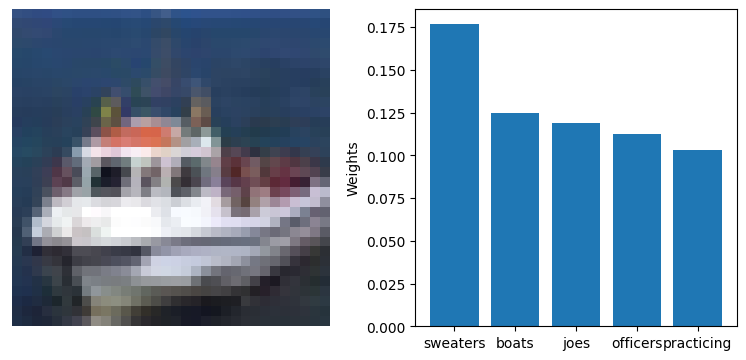

In [81]:
def display_image_and_chart(image, y_values, labels):
    # Create a new figure and set the size
    fig, ax = plt.subplots(figsize=(8, 4))

    # Create a grid layout with 1 row and 2 columns
    grid_spec = fig.add_gridspec(1, 2)

    # Display the image in the left subplot
    ax_img = fig.add_subplot(grid_spec[0, 0])
    ax_img.imshow(image)
    ax_img.axis('off')  # Hide the axes

    # Display the bar chart in the right subplot
    ax_chart = fig.add_subplot(grid_spec[0, 1])
    ax_chart.bar(labels, y_values)
    ax_chart.set_ylabel("Weights")
    ax_chart.set_xticks(range(len(labels)))  # Set x-ticks at positions of labels
    ax_chart.set_xticklabels(labels)  # Set the corresponding labels

    # Show the plot
    plt.tight_layout()
    ax.axis("off")
    plt.show()



def Activation_Visualizer(zc, A_c, level):
    zc = normalize(torch.tensor(zc))
    # zc = CudaToNumpy(zc)
    A_c = A_c.numpy()


    sparser = Lasso(alpha=level, fit_intercept=False)
    sparser.fit(A_c.T, zc.T)
    w = sparser.coef_
    ones = np.ones((1, 768)) # Might have to change this if z changes
    uc = mean_A * ones # Mean Scalar of Original Concept Matrix

    z_sparse = A_c.T @ w

    activations = np.nonzero(w)[0]

    print("Z Sparse: ", np.count_nonzero(z_sparse))

    print("Sparse %: ", 100 * (1 - np.count_nonzero(w)/4539))

    # z = np.add(z_sparse, uc)
    # z = torch.tensor(z)

    return activations, w


controller = 8975

img = test_dataset["img"][controller]
inputs = main_processor(text=labels, images=img, padding="max_length", return_tensors="pt")
inputs = inputs.to(device)

with torch.no_grad():
    outputs = main_model(**inputs, return_dict=True)

txt_embs = outputs.text_embeds
img_emb = outputs.image_embeds


txt_embs = CudaToNumpy(txt_embs)
img_emb = CudaToNumpy(img_emb)


activations, weights = Activation_Visualizer(img_emb, A_c, 1e-5)


# print(activations)
# print(weights[activations])

# print(t100indices)
# print(t100weights)

wt = weights[activations]

sorted_indices = np.argsort(wt)[::-1]
weights_sorted = (wt)[sorted_indices]
indices_sorted = activations[sorted_indices]


probs = torch.softmax(torch.tensor(weights_sorted), dim=0)
probs = probs.numpy()

#print(indices_sorted)

activated_words = []
for index in indices_sorted:
  activated_words.append(words[index])

# print(weights_sorted)
# print(probs)
# print(activated_words)

print(labels[test_dataset["label"][controller]])

display_image_and_chart(test_dataset["img"][controller], weights_sorted[0:5], activated_words[0:5])



Plotting Accuracies & F1 Scores

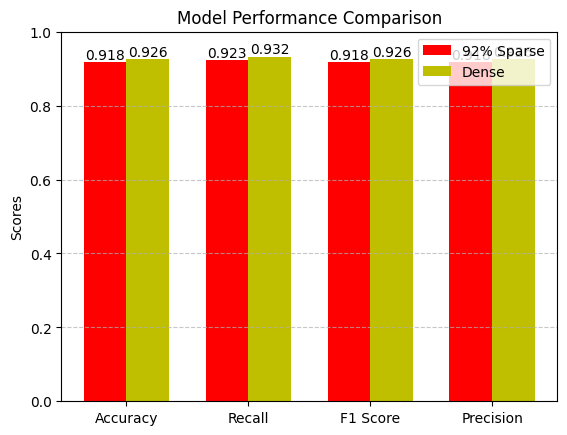

0     1      2      3
0  91.79  92.3  91.79  91.81

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for two models
metrics = ['Accuracy', 'Recall', 'F1 Score', 'Precision']
model_1_scores = [0.9179, 0.923, 0.9179, 0.9181]  # Scores for Model 1
model_2_scores = [0.926, 0.9325, 0.926, 0.9261]  # Scores for Model 2

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

# Creating bars for both models
bars1 = ax.bar(x - width/2, model_1_scores, width, label='92% Sparse', color='r')
bars2 = ax.bar(x + width/2, model_2_scores, width, label='Dense', color='y')

# Adding labels, title, and custom x-axis tick labels
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Adding value labels on top of the bars
def add_value_labels(bars):
    """Add labels on top of the bars"""
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.3f}', ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)

# Display the plot
plt.ylim(0, 1)  # Set y-axis limits for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
import io
import pandas as pd
pd.read_csv(io.StringIO('''
91.79,92.3,91.79,91.81
'''), header=None)
import io
import pandas as pd
pd.read_csv(io.StringIO('''
91.79,92.3,91.79,91.81
'''), header=None)


Analyzing Memory Footprint

# Task 3: ISTA for Sparse Vector Recovery

## Section 1: Optimization

We first start by considering a well formulated problem:

Consider some noisy observations $\mathbf{x} \in \mathbb{R}^{m}$ generated from the following process:

$$
\begin{align}
\mathbf{x} = \mathbf{Az} + \mathbf{n}
\end{align}
$$

where $\mathbf{z} \in \mathbb{R}^{m}$ is our target signal, $\mathbf{A} \in \mathbb{R}^{m \times n}$ is a linear operator representing the process by which the signal has been measured, and $\mathbf{n} \in \mathbb{R}^{n}$ represents additive noise. Our objective is to recover $\mathbf{x}$.


This can be formulated as an optimization problem as follows:
$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2}
\end{align}
$$

This is the well known, least squares regression problem and there are various methods to solve it. We make our problem more interesting by adding the constraint that $\mathbf{x}$ is **sparse**. Noting that the $l_{0}$ norm measures sparsity, our new optimization problem is:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{0}
\end{align}
$$

This problem is **not** convex and hence cannot be solved using conventional gradient based methods.

We relax the $l_{0}$ norm to the $l_{1}$ norm in order to bring our problem in the domain of convex problems:

$$
\begin{align}
\min_{\mathbf{z}} ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + \lambda||\mathbf{z}||_{1}
\end{align}
$$

You may know this as lasso regression. Note that this problem is not solvable via gradient descent since the $l_{1}$ norm is not differentiable. Many solvers exist for this problem, but we shall take a different approach known as the **Iterative Soft Thresholding Algorithm (ISTA)**.

We can write our optimization objective as a sum of two functions:

$$
\begin{align}
\min_{\mathbf{z}}{h(\mathbf{z}) = f(\mathbf{z}) + g(\mathbf{z})}
\end{align}
$$

where $f$ is convex and differentiable while $g$ is convex but not necessarily differentiable.

Note that if $g$ was differentiable, we could use a gradient based approach (e.g. gradient descent) to minimize it. Our approach is to design an iterative algorithm such that at iteration $k$ where the algorithm is at point $\mathbf{z}_k$, we minimize another convex function $m_{k}$ fulfilling the following conditions:

$$
\begin{align}
m_{k}(\mathbf{z}) &\geq h(\mathbf{z}) \; \; ∀ \mathbf{z} \\
m_{k}(\mathbf{z}_{k}) &= h(\mathbf{z}_{k})
\end{align}
$$

Our update equation then becomes:
$$
\begin{align}
\mathbf{z}_{k+1} = \min_{\mathbf{z}}{m_{k}({\mathbf{z}})}
\end{align}
$$

Coming back to our problem, we define the following function:
$$
\begin{align}
m_{k}(\mathbf{z}) = ||\mathbf{x} - \mathbf{Az}||_{2}^{2} + λ||\mathbf{z}||_{1} + (\mathbf{z} - \mathbf{z}_{k})^{T}(α\mathbf{I} - \mathbf{A}^{T}\mathbf{A})(\mathbf{x} - \mathbf{z}_{k})
\end{align}
$$

Note that at $\mathbf{z} = \mathbf{z}_{k}$, the additional quadratic term becomes 0 while for all other $\mathbf{z}$, the additional term is positive as long as $α > \max(\text{eig}(\mathbf{A}^{T}\mathbf{A}))$ thereby satisfying the two conditions defined above. Each iterative step that minimizes this function, also minimizes the original objective function.
The expression for $\min_{\mathbf{z}}m_{k}(\mathbf{z}_{k})$ can be written as follows:

$$
\begin{align}
\min_{\mathbf{z}}{||\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}^{T}(\mathbf{x} - \mathbf{A}\mathbf{z}_{k}) - \mathbf{z}||_{2}^{2} + \frac{λ}{\alpha}||\mathbf{z}||_{1}}
\end{align}
$$
While an exact solution for the miniimzation problem does not exist, by finding a minimizer at each $k$, we can approach the global minimizer of the original problem.

Each update iteration looks as follows:
$$
\begin{align}
\mathbf{z}_{k+1} = \text{soft}(\mathbf{z}_{k} + \frac{1}{\alpha}\mathbf{A}(\mathbf{x} - \mathbf{A}^{T}\mathbf{z}_{k}), \frac{\lambda}{2\alpha})
\end{align}
$$

Where:
$$
\begin{align}
\text{soft}(\mathbf{x}, \tau) := \text{sign}(\mathbf{x})\max(0, |\mathbf{x}| - \tau)
\end{align}
$$

The soft thresholding operator is also known as the proximal gradient operator for the $l_{1}$ norm.

Consider the following example where $\mathbf{z} \in \mathbb{R}^{100}$,  $\mathbf{A} \in \mathbb{R}^{100 \times 100}$ and $\mathbf{n} \sim \mathcal{N}(0, 0.05^{2}\mathbf{I}) \in \mathbb{R}^{100}$:

In [ ]:
t = np.arange(0, 100, 1)
z = 1.5 * np.random.rand(len(t))
z = z * np.array([0 if np.random.rand() < 0.8 else 1 for i in range(len(t))])

A = np.random.rand(100, 100)

sigma = 0.05
noise = np.random.normal(0, sigma)
x = A @ z + noise


fig = plt.figure(1, dpi=100, figsize=(12, 5))
ax  = fig.subplots(nrows=1, ncols=2)
_   = ax[0].stem(t, z, "k", basefmt="ko")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, x, "b", basefmt="bo")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$x$')
_   = ax[1].set_title("Noisy Measurement")

### Task 3.1:

Implement the ISTA class for a fixed number of iterations. For the given signal, plot the total loss and sparse loss as a function of iterations. Also plot the recovered and original signals on a $2 \times 1$ grid.

In [ ]:
class ISTA:
    def __init__(self, lambd: float, max_iter=1000):
        """Initialize the ISTA algorithm parameters."""
        self.lambd = lambd
        self.max_iter = max_iter
        self.loss_history_reconstruction = []
        self.loss_history_sparse = []
        self.loss_history_combined = []

    def _soft(self, z: np.ndarray, T: float) -> np.ndarray:
        """Apply soft-thresholding to the input vector."""
        pass  # To be implemented

    def _run_one_iter(self, z: np.ndarray, x: np.ndarray, A: np.ndarray, alpha: float):
        """Run one iteration of the ISTA algorithm."""
        pass  # To be implemented

    def optimize(self, A: np.ndarray, x: np.ndarray, alpha: float) -> np.ndarray:
        """Optimize the solution using the ISTA algorithm."""
        pass  # To be implemented

    def visualize_loss_history(self):
        """Visualize the loss history over the iterations."""
        pass  # To be implemented


In [ ]:
opt = ISTA(2.5, max_iter=5000)
eigs, _ = np.linalg.eig(A.T @ A)
alpha = max(eigs) + 100
z_recovered = opt.optimize(A, x, alpha)
opt.visualize_loss_history()

In [ ]:
fig = plt.figure(dpi=100, figsize=(15, 10))
ax  = fig.subplots(2, 1)
_   = ax[0].stem(t, x, "k", label="Original Signal")
_   = ax[0].set_xlabel(r'$t$')
_   = ax[0].set_ylabel(r'$z$')
_   = ax[0].set_title("Original Signal")

_   = ax[1].stem(t, z_recovered, "b", label="Recovered Signal")
_   = ax[1].set_xlabel(r'$t$')
_   = ax[1].set_ylabel(r'$\hat{z}$')
_   = ax[1].set_title("Recovered Signal")

### Task 3.2

Add in your response to Task 3.2 from the manual in the cells below.

## Section 2: Unfolding

In section 1, we had the luxury of knowing what our measurement matrix $A$ was. Yet, we had to choose values of $\alpha$ and $\lambda$ manually and a little experimentation will show you that their choice impacts the performance of the algorithm greatly. Our new problem setup assumes that we only have access to some noisy measurements $\mathbf{z}$ and our objective is to recover the underlying sparse signal $\mathbf{z}$ with no knowledge of $\mathbf{A}$.

To do so, we turn our attention towards neural networks.


The following code will help you load and create a dataset from the given `sparse_signals.pkl` file. Do not change it.

The training data comprises of 9000 input $\mathbf{z} \in \mathbb{R}^{100}$ and output $\mathbf{x} \in \mathbb{R}^{100}$ signal pairs while test set contains 1000 samples.

In [ ]:
class SparseSignalsDataset(Dataset):
  def __init__(self, Z, X):
    self.z = torch.tensor(np.array(Z), dtype=torch.float32)
    self.x = torch.tensor(np.array(X), dtype=torch.float32)

  def __len__(self):
    return len(self.z)

  def __getitem__(self, idx):
    return self.z[idx], self.x[idx]

In [ ]:
def load_file(filename='signals.pkl'):
    with open(filename, 'rb') as f:
        Z, X = pickle.load(f)
    return Z, X

In [ ]:
# DO NOT MODIFY
filename = "/content/sparse_signals.pkl"
Z, X = load_file(filename=filename)
dataset = SparseSignalsDataset(Z, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 3.3

Refer to the manual for this task.

In [ ]:
def visualize(model, test_loader, num_samples, configs):
  model.eval()
  fig = plt.figure(figsize=(12, 5))
  axs = fig.subplots(2, num_samples)
  t = np.arange(0, 100, 1)
  with torch.no_grad():
    for i, (z, x) in enumerate(test_loader):
      if i == num_samples:
        break
      z, x = z.to(configs["device"]), x.to(configs["device"])
      z_hat = model(x)[0, :].cpu().numpy()
      z = z[0, :].cpu().numpy()
      _   = axs[0, i].stem(t, z, "k")
      _   = axs[0, i].set_xlabel(r'$t$')
      _   = axs[0, i].set_ylabel(r'$z$')
      _   = axs[0, i].set_title("Original Signal")

      _   = axs[1, i].stem(t, z_hat, "b")
      _   = axs[1, i].set_xlabel(r'$t$')
      _   = axs[1, i].set_ylabel(r'$\hat{z}$')
      _   = axs[1, i].set_title("Recovered Signal")
  plt.tight_layout()
  plt.show()
  return axs

In [ ]:
# Ignore the use of x, y here - those are just placeholders

def train(model, train_loader, loss_fn, optimizer, configs):
  model.train()
  for epoch in range(configs["epochs"]):
    running_loss = 0.0
    for x, y in train_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      optimizer.zero_grad()
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * y.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

def evaluate(model, test_loader, loss_fn, configs, tol=1e-6):
  model.eval()
  running_loss = 0.0
  sparsities = []
  with torch.no_grad():
    for x, y in test_loader:
      x, y = x.to(configs["device"]), y.to(configs["device"])
      x_hat = model(y)
      loss = loss_fn(x_hat, x)
      running_loss += loss.item() * y.size(0)
      sparsities.append(torch.sum(torch.abs(x_hat) < tol).item()/x_hat.numel())
  avg_loss = running_loss / len(test_loader.dataset)
  avg_sparsity = np.mean(sparsities)
  print(f"Test Loss: {avg_loss:.4f}")
  print(f"Average Sparsity: {avg_sparsity:.4f}")
  return avg_loss, avg_sparsity

In [ ]:
class ISTABlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        """Initialize the ISTA block with a learnable threshold and a linear layer."""
        super().__init__()
        pass  # To be implemented

    def _soft(self, x, T):
        """Apply soft-thresholding with threshold T."""
        pass  # To be implemented

    def forward(self, x):
        """Perform the forward pass through the ISTA block."""
        pass  # To be implemented


class UnfoldedNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with multiple ISTA blocks."""
        super().__init__()
        pass  # To be implemented

    def forward(self, x):
        """Perform the forward pass through the unfolded neural network."""
        pass  # To be implemented

In [ ]:
configs_unfolded = {
    "input_dim": 100,
    "hidden_dims": [256, 256],
    "output_dim": 100,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

In [ ]:
model_unfolded = UnfoldedNN(configs_unfolded).to(configs_unfolded["device"])
optimizer = Adam(model_unfolded.parameters(), lr=configs_unfolded["lr"])
L1 = nn.L1Loss()
train(model=model_unfolded, train_loader=train_loader, loss_fn=L1, optimizer=optimizer, configs=configs_unfolded)

In [ ]:
avg_eval_loss_unfolded, avg_eval_sparsity_unfolded = evaluate(model_unfolded, test_loader, L1, configs_unfolded)
_ = visualize(model_unfolded, test_loader, 3, configs_unfolded)

### Task 3.4

Add in your solution to Task 3.4 from the manual in the cells below.

# Task 4: ISTA Extension to Matrices and Inclusion of Rank Constraints

So far, we have been working with vectors and sparsity constraints. We now introduce two new challenges:

1. Introducing rank constraints into our problem formulation.
2. Extending our algorithms to matrices (can be used to deal with images, videos etc.)

Note that the rank of a matrix describes the degree of correlation between its rows or columns. A low rank means that most of its rows or columns are similar. In the context of images, a low rank component could be used to represent a background (e.g. a grassy background would have large regions of highly similar pixel values). In the context of videos (assume that each frame is being treated as a vector of dimension $hw$ (height $\times$ width) so that the columns of a matrix represent each frame), a low rank component could represent similarities between successive frames. In other words, such an approach could help us identify constant features and isolating things that change. This is used frequently in medical imaging techniques to isolate outliers from largely similar video/image frames that show blood or tissue.

Mathematically, the rank of a matrix can be captured by the nuclear norm of a matrix $||\mathbf{M}||_{*}$ which basically counts the number of non-zero singular values of $\mathbf{M}$.
The singular values are the non zero elements of the diagonal matrix $\mathbf{\Sigma}$ in the singular value decomposition (SVD) of $\mathbf{M} = \mathbf{U \Sigma V}^{T}$.

Our problem is that we are given some observation $\mathbf{X} \in \mathbb{R}^{a \times b}$ (an image or a video for example) and our objective is to recover a low rank component $\mathbf{L} \in \mathbb{R}^{a \times b}$ and sparse component $\mathbf{S} \in \mathbb{R}^{a \times b}$ such that $\mathbf{X} = \mathbf{AL} + \mathbf{BS}$ where $\mathbf{A}$ and $\mathbf{B}$ represent some linear operations (this is similar to $\mathbf{A}$ in the original least squares regression problem. Also note that in many cases it may be sufficient to for these to be identity matrices, but we shall generalize our formulation). Overall, our optimization problem is:

$$
\begin{align}
\arg \min_{\mathbf{L, S}}{\lambda_{1}||\mathbf{L}||_{*} + \lambda_{2}||\mathbf{S}||_{1} + ||\mathbf{X} - \mathbf{AL} - \mathbf{BS}||_{F}^{2}}
\end{align}
$$

This is also known as Robust Principal Component Analysis (RPCA).

Without going into more details here, the ISTA approach can be extended to this problem formulation via the following two update equations:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(
(\mathbf{I} - \frac{1}{L_f} \mathbf{A}^T \mathbf{A}) \mathbf{L}_k - \mathbf{A}^T \mathbf{B} \mathbf{S}_k + \mathbf{A}^T \mathbf{X}, \frac{\lambda_1}{L_f}) \\
\mathbf{S}_{k+1} &= \text{soft}((\mathbf{I} - \frac{1}{L_f} \mathbf{B}^T \mathbf{B}) \mathbf{S}_k - \mathbf{B}^T \mathbf{A} \mathbf{L}_k + \mathbf{B}^T \mathbf{X}, \frac{\lambda_2}{L_f})
\end{align}
$$

You have already seen the soft thresholding operator, the singular value thresholding operator is the proximal gradient operator for the nuclear norm and is defined as follows:

$$
\begin{align}
\text{svt}(\mathbf{X}, \kappa) := \mathbf{U} \, \max(\mathbf{0}, \mathbf{\Sigma} - \kappa\mathbf{I}) \, \mathbf{V}^T
\end{align}
$$

where $\mathbf{U \Sigma V}^{T} = \text{SVD}(\mathbf{X})$

Our focus is not on the details of this optimization algorithm. We shall instead focus on designing a neural network inspired by it.

Note that for each update equation, we can replace the multiplicative matrices by learnable convolutional kernels and thresholds by learnable parameters so that each iteration (layer) looks as follows:

$$
\begin{align}
\mathbf{L}_{k+1} &= \text{svt}(C_{1}^{k} * \mathbf{L}_{k} + C_{2}^{k} * \mathbf{S}_{k} + C_{3}^{k} * \mathbf{X}, \mu_{1})\\
\mathbf{S}_{k+1} &= \text{soft}(K_{1}^{k} * \mathbf{L}_{k} + K_{2}^{k} * \mathbf{S}_{k} + K_{3}^{k} * \mathbf{X}, \mu_{2})
\end{align}
$$

where $C_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{L}$ network and $K_{i}^{k}$ is the $i^\text{th}$ convolutional kernel of layer $k$ in the $\mathbf{S}$ network.

You will be working with the moving MNIST dataset for this problem. Each sample $\mathbf{X} \in \mathbb{R}^{64 \times 64}$ represents a frame from a video containing two mnist digits superimposed on a noisy, low rank background. The functions given below will help you load and visualize the dataset.

In [ ]:
class MovingMNISTDataset(Dataset):
    def __init__(self, L, S, X):
        self.L = torch.tensor(np.array(L), dtype=torch.float32)
        self.S = torch.tensor(np.array(S), dtype=torch.float32)
        self.X = torch.tensor(np.array(X), dtype=torch.float32)

        self.L = self.L.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.S = self.S.view(10, 1000, 64 * 64).permute(1, 2, 0)
        self.X = self.X.view(10, 1000, 64 * 64).permute(1, 2, 0)

        self.L = self.L.unsqueeze(1)
        self.S = self.S.unsqueeze(1)
        self.X = self.X.unsqueeze(1)

        print("L shape:", self.L.shape)
        print("S shape:", self.S.shape)
        print("X shape:", self.X.shape)

    def __len__(self):
        return self.L.size(0)

    def __getitem__(self, idx):
        L_seq = self.L[idx]
        S_seq = self.S[idx]
        X_seq = self.X[idx]

        return L_seq, S_seq, X_seq


In [ ]:
def load_mnist(filename='moving_mnist.pkl'):
    with open(filename, 'rb') as f:
        L, S, X = pickle.load(f)
    return L, S, X

In [ ]:
# DO NOT MODIFY
filename = "/content/moving_mnist.pkl"
L, S, X = load_mnist(filename=filename)
dataset = MovingMNISTDataset(L, S, X)

batch_size = 32

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=gen)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, generator=gen)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Display the shape of original data (X)
print("Original X shape:", X.shape)
print("Original L shape:", L.shape)
print("Original S shape:", S.shape)

# Plot the first video frames of original X, L, and S
def plot_video_frames(data, title):
    video_idx = 0  # Selecting the first video (index 0)
    frames = data[:, video_idx, :, :]  # Shape: (10, 64, 64)

    # Create a figure with 10 subplots (one for each frame)
    fig, axs = plt.subplots(1, 10, figsize=(20, 2))
    fig.suptitle(title, fontsize=16)

    for i in range(10):
        axs[i].imshow(frames[i], cmap='gray')
        axs[i].axis('off')

    plt.show()

# Plot original X, L, and S
print("\nPlots for Original")
plot_video_frames(X, "Original X (Original Video)")
plot_video_frames(L, "Original L (Background)")
plot_video_frames(S, "Original S (Foreground)")

# Simulating transformation via the dataset
# L_new, S_new, X_new represent transformed data after the dataloader
L_new, S_new, X_new = dataset[0]  # Dataset returns transformed tensors

# Display the shape of transformed data (L_new, S_new, X_new)
print("\n")
print("Transformed L_new shape:", L_new.shape)
print("Transformed S_new shape:", S_new.shape)
print("Transformed X_new shape:", X_new.shape)


Now design a neural network with up to 5 layers based on the intuition for low rank and sparse solutions developed above. Each layer should contain two branches for performing proximal operations for the low rank and sparse component respectively.

During training, plot the following:
1. MSE Loss as a function of the number of epochs.
2. Final values of learnt thresholding parameters for the L and S brances as a function of layer number.

For the test data, plot the following two charts by averaging over all points:
1. Low Rank:
  - 3D plot showing layer number and index of singular value on the x and y axes and the singular values themselves on the z axis.

2. Sparse:
  - 2D plot showing layer number on the x axis and number of sparse values on the y axis.

In [ ]:
class ISTABlock(nn.Module):
    def __init__(self, branch, kernel_size=3):
        """Initialize the ISTA block with a convolution layer and a learnable threshold."""
        super(ISTABlock, self).__init__()
        pass  # To be implemented

    def _soft(self, X, thr):
        """Apply soft-thresholding to the input tensor."""
        pass  # To be implemented

    def _svt(self, X, thr):
        """Apply Singular Value Thresholding (SVT) to the input tensor."""
        pass  # To be implemented

    def forward(self, X):
        """Perform the forward pass through the ISTA block based on the branch type."""
        pass  # To be implemented


class UnfoldedDNN(nn.Module):
    def __init__(self, configs):
        """Initialize the unfolded neural network with ISTA blocks for both 'S' and 'L' branches."""
        super(UnfoldedDNN, self).__init__()
        pass  # To be implemented

    def get_thresholds(self):
        """Return the thresholds from both branches of the network."""
        pass  # To be implemented

    def forward(self, D):
        """Perform the forward pass through the unfolded neural network and return activations."""
        pass  # To be implemented


Now Train the Model and evaluate the outputs. Complete the plotting functions and feel free to change the configurations or training settings

In [ ]:
def plot_mse_loss(epoch_losses):
    """
    Plot MSE loss over epochs.
    """
    pass  # To be implemented


def plot_threshold_params(L_params, S_params):
    """
    Plot threshold parameters for L and S branches across layers.
    """
    pass  # To be implemented


def get_singular_values(L_):
    """
    Calculate singular values from the low-rank component.
    """
    pass  # To be implemented


def get_sparsity(S_, tol=1e-6):
    """
    Calculate sparsity (number of non-zero elements with tolerance 10^-6) from the sparse component.
    """
    pass  # To be implemented


def plot_singular_values_over_layers(singular_values):
    """
    Plot singular values for each layer as a 3D surface plot.
    """
    pass  # To be implemented


def plot_sparse_values_over_layers(sparse_values):
    """
    Plot average number of sparse values across layers.
    """
    pass  # To be implemented


In [ ]:
from tqdm import tqdm

def train(model, train_loader, loss_fn, optimizer, configs):
    model.train()
    epoch_losses = []
    L_params = []
    S_params = []

    for epoch in range(configs["epochs"]):
        running_loss = 0.0
        with tqdm(train_loader, desc=f"Epoch [{epoch+1}/{configs['epochs']}]", unit="batch") as pbar:
            for L, S, X in pbar:
                L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
                optimizer.zero_grad()
                _, (L_, S_) = model(X)
                loss = loss_fn(L_, S_, L, S, X)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * L.size(0)
                pbar.set_postfix(loss=running_loss / len(train_loader.dataset))

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_losses.append(epoch_loss)

        thresholds_S, thresholds_L = model.get_thresholds()
        L_params.append(thresholds_L)
        S_params.append(thresholds_S)

        print(f"Epoch: [{epoch+1}/{configs['epochs']}], Loss: {epoch_loss:.4f}")

    plot_mse_loss(epoch_losses)
    print("\n")
    plot_threshold_params(L_params, S_params)


def evaluate(model, test_loader, loss_fn, configs):
    model.eval()
    running_loss = 0.0
    all_sparsities = []
    all_singular_values = []

    with torch.no_grad():
        for batch_idx, (L, S, X) in enumerate(test_loader):
            L, S, X = L.to(configs["device"]), S.to(configs["device"]), X.to(configs["device"])
            (activations_L, activations_S), (L_ , S_)= model(X)
            loss = loss_fn(L, S, L_, S_, X)
            running_loss += loss.item() * L.size(0)

            print(f"Plot for random frame in {batch_idx}")
            plot_first_frame(L, S, X)

            batch_singular_values = []
            batch_sparsities = []
            layer_idx = 0
            for L_layer, S_layer in zip(activations_L, activations_S):
                layer_idx += 1
                singular_values = get_singular_values(L_layer)
                sparsity = get_sparsity(S_layer)
                batch_singular_values.append(singular_values)
                batch_sparsities.append(sparsity)

            all_singular_values.append(batch_singular_values)
            all_sparsities.append(batch_sparsities)

    avg_loss = running_loss / len(test_loader.dataset)
    print(f"Test Loss: {avg_loss:.4f}")

    avg_singular_values = np.mean(all_singular_values, axis=0)
    avg_sparsities = np.mean(all_sparsities, axis=0)

    plot_singular_values_over_layers(avg_singular_values)
    print("\n")
    plot_sparse_values_over_layers(avg_sparsities)

    return avg_loss


def plot_first_frame(L, S, X):
  L_frame_flat = L[0, 0, :, 0]  # Shape: (4096,)
  S_frame_flat = S[0, 0, :, 0]  # Shape: (4096,)
  X_frame_flat = X[0, 0, :, 0]  # Shape: (4096,)

  L_frame = L_frame_flat.view(64, 64).cpu().numpy()
  S_frame = S_frame_flat.view(64, 64).cpu().numpy()
  X_frame = X_frame_flat.view(64, 64).cpu().numpy()

  fig, axs = plt.subplots(1, 3, figsize=(12, 4))

  axs[0].imshow(L_frame, cmap='gray')
  axs[0].set_title('Background (L)')
  axs[0].axis('off')

  axs[1].imshow(S_frame, cmap='gray')
  axs[1].set_title('Foreground (S)')
  axs[1].axis('off')

  axs[2].imshow(X_frame, cmap='gray')
  axs[2].set_title('Original (D)')
  axs[2].axis('off')

  plt.show()


def loss_fn(L_, S_, L, S, X):
  loss_L = torch.nn.functional.mse_loss(L_, L)
  loss_S = torch.nn.functional.mse_loss(S_, S)
  return loss_L + loss_S


In [ ]:
# Model and training configurations
configs = {
    "num_layers": 4,
    "kernel_size": 3,
    "lr": 1e-4,
    "epochs": 30,
    "batch_size": 32,
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

# Initialize the model, optimizer, and datasets
model = UnfoldedDNN(configs).to(configs["device"])
optimizer = Adam(model.parameters(), lr=configs["lr"])

# Train the model
train(model, train_loader, loss_fn, optimizer, configs)

In [ ]:
# Evaluate the model
evaluate(model, test_loader, loss_fn, configs)

# Task 5: RPCA with Mixed Norms

Add your solution to this task from the manual in the cells below.